# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))


C:\Users\arnol\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


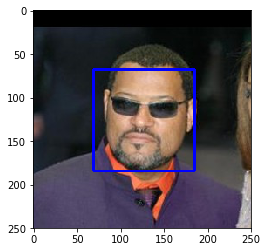

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# Number of faces
num_faces_human = sum(face_detector(f) for f in human_files_short)
num_faces_dogs = sum(face_detector(f) for f in dog_files_short)

#Percent:
num_faces_human_percentages = num_faces_human/len(human_files_short)*100
num_faces_dogs_percentages = num_faces_dogs/len(dog_files_short)*100

print("Answer 1: {}% percentage (or {} images) of the first 100 images in human_files have a detected human face".format(num_faces_human_percentages, num_faces_human))
print("Answer 2: {}% percentage (or {} images) of the first 100 images in dog_files have a detected human face".format(num_faces_dogs_percentages, num_faces_dogs))


Answer 1: 99.0% percentage (or 99 images) of the first 100 images in human_files have a detected human face
Answer 2: 11.0% percentage (or 11 images) of the first 100 images in dog_files have a detected human face


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
import random
from glob import glob


from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing import image          
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

# define function to load train, test, and validation datasets
def _load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return dog_files, dog_targets

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

def PrepWeights(train_file, model):
    ## Calculate bottleneck_features manually:
    X = preprocess_input(paths_to_tensor(train_file))
    train_Resnet50 = model.predict(X)
    return train_Resnet50

def Predict_photo(img_path):
    X = PrepWeights(img_path, RN50_model)
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=X.shape[1:]))
    model.add(Dense(2, activation='softmax'))
    model.load_weights('saved_models/weights.best.FaceRecR50.hdf5')
    # MODELL

face_train_files, face_train_targets = _load_dataset('FaceRecognizer/train/')
face_valid_files, face_valid_targets = _load_dataset('FaceRecognizer/val/')
face_test_files, face_test_targets = _load_dataset('FaceRecognizer/test/')


RN50_model = ResNet50(weights='imagenet', include_top=False)


face_train_Resnet50 = PrepWeights(face_train_files, RN50_model)
face_valid_Resnet50 = PrepWeights(face_valid_files, RN50_model)
face_test_Resnet50 = PrepWeights(face_test_files, RN50_model)

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=face_train_Resnet50.shape[1:]))
model.add(Dense(2, activation='softmax'))
# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Train the Model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.FaceRecR50.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(face_train_Resnet50, face_train_targets, 
          validation_data=(face_valid_Resnet50, face_valid_targets),
          epochs=3, batch_size=50, callbacks=[checkpointer], verbose=1)

model.load_weights('saved_models/weights.best.FaceRecR50.hdf5')

face_model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in face_test_Resnet50]


# report test accuracy
test_accuracy = 100*np.sum(np.array(face_model_predictions)==np.argmax(face_test_targets, axis=1))/len(face_model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)


100%|███████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 176.45it/s]


Train on 18097 samples, validate on 2536 samples
Epoch 1/3
18097/18097 [==============================] - ETA: 7:11 - loss: 1.0517 - acc: 0.380 - ETA: 3:47 - loss: 0.8160 - acc: 0.550 - ETA: 1:59 - loss: 0.5961 - acc: 0.695 - ETA: 1:22 - loss: 0.4490 - acc: 0.786 - ETA: 1:04 - loss: 0.3706 - acc: 0.830 - ETA: 52s - loss: 0.3168 - acc: 0.862 - ETA: 45s - loss: 0.2719 - acc: 0.88 - ETA: 43s - loss: 0.2558 - acc: 0.89 - ETA: 38s - loss: 0.2268 - acc: 0.90 - ETA: 35s - loss: 0.2065 - acc: 0.91 - ETA: 32s - loss: 0.1877 - acc: 0.92 - ETA: 29s - loss: 0.1724 - acc: 0.93 - ETA: 28s - loss: 0.1591 - acc: 0.93 - ETA: 26s - loss: 0.1476 - acc: 0.94 - ETA: 25s - loss: 0.1376 - acc: 0.94 - ETA: 23s - loss: 0.1293 - acc: 0.95 - ETA: 22s - loss: 0.1219 - acc: 0.95 - ETA: 21s - loss: 0.1153 - acc: 0.95 - ETA: 21s - loss: 0.1095 - acc: 0.95 - ETA: 20s - loss: 0.1040 - acc: 0.96 - ETA: 19s - loss: 0.0991 - acc: 0.96 - ETA: 18s - loss: 0.0945 - acc: 0.96 - ETA: 18s - loss: 0.0905 - acc: 0.96 - ETA: 17s 

18097/18097 [==============================] - ETA: 6s - loss: 3.6432e-06 - acc: 1.000 - ETA: 7s - loss: 4.2665e-06 - acc: 1.000 - ETA: 7s - loss: 2.8893e-06 - acc: 1.000 - ETA: 7s - loss: 3.6588e-06 - acc: 1.000 - ETA: 7s - loss: 2.9180e-06 - acc: 1.000 - ETA: 6s - loss: 2.9764e-06 - acc: 1.000 - ETA: 6s - loss: 3.1599e-06 - acc: 1.000 - ETA: 6s - loss: 2.9237e-06 - acc: 1.000 - ETA: 6s - loss: 2.6911e-06 - acc: 1.000 - ETA: 6s - loss: 2.4676e-06 - acc: 1.000 - ETA: 6s - loss: 2.3723e-06 - acc: 1.000 - ETA: 6s - loss: 2.5220e-06 - acc: 1.000 - ETA: 6s - loss: 2.3831e-06 - acc: 1.000 - ETA: 6s - loss: 2.3006e-06 - acc: 1.000 - ETA: 6s - loss: 2.2283e-06 - acc: 1.000 - ETA: 6s - loss: 2.2862e-06 - acc: 1.000 - ETA: 6s - loss: 2.1690e-06 - acc: 1.000 - ETA: 6s - loss: 2.0648e-06 - acc: 1.000 - ETA: 6s - loss: 2.1461e-06 - acc: 1.000 - ETA: 6s - loss: 2.0834e-06 - acc: 1.000 - ETA: 6s - loss: 2.1458e-06 - acc: 1.000 - ETA: 5s - loss: 2.0737e-06 - acc: 1.000 - ETA: 5s - loss: 2.0141e-06 - 

18097/18097 [==============================] - ETA: 7s - loss: 1.5974e-07 - acc: 1.000 - ETA: 7s - loss: 1.4544e-07 - acc: 1.000 - ETA: 6s - loss: 1.5582e-07 - acc: 1.000 - ETA: 6s - loss: 2.0540e-07 - acc: 1.000 - ETA: 6s - loss: 1.9101e-07 - acc: 1.000 - ETA: 6s - loss: 1.9200e-07 - acc: 1.000 - ETA: 6s - loss: 1.9017e-07 - acc: 1.000 - ETA: 6s - loss: 2.3961e-07 - acc: 1.000 - ETA: 6s - loss: 2.4061e-07 - acc: 1.000 - ETA: 6s - loss: 2.3455e-07 - acc: 1.000 - ETA: 6s - loss: 2.2369e-07 - acc: 1.000 - ETA: 6s - loss: 2.1472e-07 - acc: 1.000 - ETA: 6s - loss: 2.1207e-07 - acc: 1.000 - ETA: 6s - loss: 2.0769e-07 - acc: 1.000 - ETA: 6s - loss: 2.0302e-07 - acc: 1.000 - ETA: 6s - loss: 1.9794e-07 - acc: 1.000 - ETA: 6s - loss: 1.9536e-07 - acc: 1.000 - ETA: 6s - loss: 1.9142e-07 - acc: 1.000 - ETA: 6s - loss: 1.8790e-07 - acc: 1.000 - ETA: 5s - loss: 1.8475e-07 - acc: 1.000 - ETA: 5s - loss: 1.8222e-07 - acc: 1.000 - ETA: 5s - loss: 1.9047e-07 - acc: 1.000 - ETA: 5s - loss: 1.9186e-07 - 

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# Number of faces
num_faces_human = sum(dog_detector(f) for f in human_files_short)
num_faces_dogs = sum(dog_detector(f) for f in dog_files_short)

#Percent:
num_faces_human_percentages = num_faces_human/len(human_files_short)*100
num_faces_dogs_percentages = num_faces_dogs/len(dog_files_short)*100

print("Answer 1: {}% percentage (or {} images) of the first 100 images in human_files have a detected human face".format(num_faces_human_percentages, num_faces_human))
print("Answer 2: {}% percentage (or {} images) of the first 100 images in dog_files have a detected human face".format(num_faces_dogs_percentages, num_faces_dogs))


Answer 1: 1.0% percentage (or 1 images) of the first 100 images in human_files have a detected human face
Answer 2: 100.0% percentage (or 100 images) of the first 100 images in dog_files have a detected human face


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:08<00:00, 97.22it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
#model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
#model.add(Conv2D(filters=70, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=90, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=124, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 90)      23130     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 90)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 124)       44764     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 124)       0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [15]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

b_size = 32
epochs = 100

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100


4240/6680 [==================>...........] - ETA: 11:50 - loss: 4.9203 - acc: 0.05 - ETA: 6:09 - loss: 9.1865 - acc: 0.0250 - ETA: 4:15 - loss: 7.9044 - acc: 0.033 - ETA: 3:18 - loss: 7.1866 - acc: 0.025 - ETA: 2:44 - loss: 6.7205 - acc: 0.020 - ETA: 2:21 - loss: 6.4185 - acc: 0.016 - ETA: 2:04 - loss: 6.1982 - acc: 0.014 - ETA: 1:52 - loss: 6.0410 - acc: 0.012 - ETA: 1:43 - loss: 5.9146 - acc: 0.011 - ETA: 1:35 - loss: 5.8133 - acc: 0.010 - ETA: 1:29 - loss: 5.7286 - acc: 0.009 - ETA: 1:23 - loss: 5.6598 - acc: 0.008 - ETA: 1:19 - loss: 5.6010 - acc: 0.007 - ETA: 1:15 - loss: 5.5502 - acc: 0.007 - ETA: 1:12 - loss: 5.5058 - acc: 0.006 - ETA: 1:09 - loss: 5.4664 - acc: 0.006 - ETA: 1:06 - loss: 5.4381 - acc: 0.005 - ETA: 1:04 - loss: 5.4069 - acc: 0.005 - ETA: 1:02 - loss: 5.3787 - acc: 0.005 - ETA: 1:00 - loss: 5.3531 - acc: 0.005 - ETA: 58s - loss: 5.3364 - acc: 0.004 - ETA: 57s - loss: 5.3173 - acc: 0.00 - ETA: 56s - loss: 5.2986 - acc: 0.00 - ETA: 54s - loss: 5.2818 - acc: 0.00 - E

6680/6680 [==============================] - ETA: 12s - loss: 4.9300 - acc: 0.01 - ETA: 12s - loss: 4.9296 - acc: 0.01 - ETA: 12s - loss: 4.9296 - acc: 0.01 - ETA: 11s - loss: 4.9291 - acc: 0.01 - ETA: 11s - loss: 4.9289 - acc: 0.01 - ETA: 11s - loss: 4.9285 - acc: 0.01 - ETA: 11s - loss: 4.9285 - acc: 0.01 - ETA: 11s - loss: 4.9281 - acc: 0.01 - ETA: 11s - loss: 4.9284 - acc: 0.01 - ETA: 11s - loss: 4.9281 - acc: 0.01 - ETA: 11s - loss: 4.9279 - acc: 0.01 - ETA: 11s - loss: 4.9276 - acc: 0.01 - ETA: 10s - loss: 4.9273 - acc: 0.01 - ETA: 10s - loss: 4.9267 - acc: 0.01 - ETA: 10s - loss: 4.9258 - acc: 0.01 - ETA: 10s - loss: 4.9264 - acc: 0.01 - ETA: 10s - loss: 4.9264 - acc: 0.01 - ETA: 10s - loss: 4.9258 - acc: 0.01 - ETA: 10s - loss: 4.9254 - acc: 0.01 - ETA: 10s - loss: 4.9249 - acc: 0.01 - ETA: 10s - loss: 4.9238 - acc: 0.01 - ETA: 10s - loss: 4.9230 - acc: 0.01 - ETA: 9s - loss: 4.9220 - acc: 0.0157 - ETA: 9s - loss: 4.9219 - acc: 0.015 - ETA: 9s - loss: 4.9216 - acc: 0.015 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 4.3237 - acc: 0.05 - ETA: 30s - loss: 4.3629 - acc: 0.07 - ETA: 29s - loss: 4.5226 - acc: 0.06 - ETA: 29s - loss: 4.5470 - acc: 0.05 - ETA: 29s - loss: 4.5128 - acc: 0.06 - ETA: 29s - loss: 4.5188 - acc: 0.05 - ETA: 29s - loss: 4.5184 - acc: 0.05 - ETA: 29s - loss: 4.5569 - acc: 0.05 - ETA: 29s - loss: 4.5288 - acc: 0.06 - ETA: 29s - loss: 4.5551 - acc: 0.06 - ETA: 28s - loss: 4.5564 - acc: 0.06 - ETA: 28s - loss: 4.5761 - acc: 0.06 - ETA: 28s - loss: 4.5690 - acc: 0.05 - ETA: 28s - loss: 4.5671 - acc: 0.05 - ETA: 28s - loss: 4.5505 - acc: 0.06 - ETA: 28s - loss: 4.5573 - acc: 0.05 - ETA: 28s - loss: 4.5661 - acc: 0.05 - ETA: 28s - loss: 4.5879 - acc: 0.05 - ETA: 28s - loss: 4.5836 - acc: 0.05 - ETA: 28s - loss: 4.5860 - acc: 0.05 - ETA: 27s - loss: 4.5841 - acc: 0.05 - ETA: 27s - loss: 4.6013 - acc: 0.05 - ETA: 27s - loss: 4.6011 - acc: 0.05 - ETA: 27s - loss: 4.5946 - acc: 0.05 - ETA: 27s - loss: 4.5820 - acc: 0.05 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 4.4552 - acc: 0.05 - ETA: 10s - loss: 4.4551 - acc: 0.05 - ETA: 10s - loss: 4.4550 - acc: 0.05 - ETA: 10s - loss: 4.4544 - acc: 0.05 - ETA: 10s - loss: 4.4552 - acc: 0.05 - ETA: 10s - loss: 4.4544 - acc: 0.05 - ETA: 10s - loss: 4.4538 - acc: 0.05 - ETA: 10s - loss: 4.4531 - acc: 0.05 - ETA: 10s - loss: 4.4527 - acc: 0.05 - ETA: 10s - loss: 4.4524 - acc: 0.05 - ETA: 10s - loss: 4.4509 - acc: 0.05 - ETA: 10s - loss: 4.4507 - acc: 0.05 - ETA: 9s - loss: 4.4528 - acc: 0.0533 - ETA: 9s - loss: 4.4516 - acc: 0.053 - ETA: 9s - loss: 4.4514 - acc: 0.053 - ETA: 9s - loss: 4.4510 - acc: 0.052 - ETA: 9s - loss: 4.4487 - acc: 0.053 - ETA: 9s - loss: 4.4500 - acc: 0.053 - ETA: 9s - loss: 4.4481 - acc: 0.053 - ETA: 9s - loss: 4.4499 - acc: 0.053 - ETA: 9s - loss: 4.4479 - acc: 0.053 - ETA: 9s - loss: 4.4470 - acc: 0.053 - ETA: 8s - loss: 4.4463 - acc: 0.054 - ETA: 8s - loss: 4.4469 - acc: 0.054 - ETA: 8s - loss: 4.4463 - acc: 0.053 - ETA:

4300/6680 [==================>...........] - ETA: 30s - loss: 3.7895 - acc: 0.15 - ETA: 30s - loss: 3.6253 - acc: 0.15 - ETA: 30s - loss: 3.9129 - acc: 0.15 - ETA: 30s - loss: 3.9192 - acc: 0.13 - ETA: 31s - loss: 3.9266 - acc: 0.14 - ETA: 31s - loss: 3.9675 - acc: 0.11 - ETA: 30s - loss: 3.9640 - acc: 0.12 - ETA: 30s - loss: 4.0225 - acc: 0.11 - ETA: 30s - loss: 4.0190 - acc: 0.11 - ETA: 30s - loss: 4.0413 - acc: 0.10 - ETA: 30s - loss: 4.0808 - acc: 0.10 - ETA: 30s - loss: 4.1052 - acc: 0.10 - ETA: 30s - loss: 4.1134 - acc: 0.10 - ETA: 30s - loss: 4.0898 - acc: 0.10 - ETA: 30s - loss: 4.0679 - acc: 0.10 - ETA: 30s - loss: 4.0340 - acc: 0.11 - ETA: 30s - loss: 4.0390 - acc: 0.11 - ETA: 30s - loss: 4.0054 - acc: 0.11 - ETA: 29s - loss: 4.0087 - acc: 0.11 - ETA: 29s - loss: 3.9979 - acc: 0.11 - ETA: 29s - loss: 3.9816 - acc: 0.11 - ETA: 29s - loss: 3.9936 - acc: 0.11 - ETA: 29s - loss: 3.9773 - acc: 0.11 - ETA: 29s - loss: 3.9855 - acc: 0.11 - ETA: 29s - loss: 3.9743 - acc: 0.11 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 3.8966 - acc: 0.12 - ETA: 10s - loss: 3.8971 - acc: 0.12 - ETA: 10s - loss: 3.8976 - acc: 0.12 - ETA: 10s - loss: 3.8984 - acc: 0.12 - ETA: 10s - loss: 3.8989 - acc: 0.12 - ETA: 10s - loss: 3.8972 - acc: 0.12 - ETA: 10s - loss: 3.8958 - acc: 0.12 - ETA: 10s - loss: 3.8968 - acc: 0.12 - ETA: 10s - loss: 3.8966 - acc: 0.12 - ETA: 10s - loss: 3.8947 - acc: 0.12 - ETA: 10s - loss: 3.8951 - acc: 0.12 - ETA: 10s - loss: 3.8931 - acc: 0.12 - ETA: 9s - loss: 3.8930 - acc: 0.1289 - ETA: 9s - loss: 3.8925 - acc: 0.129 - ETA: 9s - loss: 3.8886 - acc: 0.129 - ETA: 9s - loss: 3.8880 - acc: 0.130 - ETA: 9s - loss: 3.8871 - acc: 0.130 - ETA: 9s - loss: 3.8861 - acc: 0.130 - ETA: 9s - loss: 3.8865 - acc: 0.130 - ETA: 9s - loss: 3.8855 - acc: 0.130 - ETA: 9s - loss: 3.8850 - acc: 0.130 - ETA: 9s - loss: 3.8869 - acc: 0.129 - ETA: 8s - loss: 3.8875 - acc: 0.129 - ETA: 8s - loss: 3.8882 - acc: 0.129 - ETA: 8s - loss: 3.8908 - acc: 0.129 - ETA:

4300/6680 [==================>...........] - ETA: 33s - loss: 3.3894 - acc: 0.20 - ETA: 31s - loss: 3.0808 - acc: 0.30 - ETA: 31s - loss: 3.0975 - acc: 0.26 - ETA: 30s - loss: 3.1409 - acc: 0.23 - ETA: 30s - loss: 3.1012 - acc: 0.22 - ETA: 30s - loss: 3.0364 - acc: 0.22 - ETA: 30s - loss: 3.0640 - acc: 0.22 - ETA: 29s - loss: 3.0555 - acc: 0.23 - ETA: 29s - loss: 3.0472 - acc: 0.23 - ETA: 29s - loss: 3.0250 - acc: 0.23 - ETA: 29s - loss: 2.9745 - acc: 0.23 - ETA: 29s - loss: 3.0311 - acc: 0.22 - ETA: 29s - loss: 3.0150 - acc: 0.23 - ETA: 29s - loss: 3.0153 - acc: 0.23 - ETA: 29s - loss: 3.0586 - acc: 0.23 - ETA: 29s - loss: 3.0788 - acc: 0.22 - ETA: 29s - loss: 3.0910 - acc: 0.22 - ETA: 29s - loss: 3.1078 - acc: 0.22 - ETA: 29s - loss: 3.1104 - acc: 0.22 - ETA: 29s - loss: 3.1077 - acc: 0.23 - ETA: 29s - loss: 3.1004 - acc: 0.23 - ETA: 28s - loss: 3.0752 - acc: 0.23 - ETA: 28s - loss: 3.0368 - acc: 0.24 - ETA: 28s - loss: 3.0531 - acc: 0.24 - ETA: 28s - loss: 3.0557 - acc: 0.24 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 3.0746 - acc: 0.26 - ETA: 10s - loss: 3.0757 - acc: 0.26 - ETA: 10s - loss: 3.0738 - acc: 0.26 - ETA: 10s - loss: 3.0715 - acc: 0.26 - ETA: 10s - loss: 3.0715 - acc: 0.26 - ETA: 10s - loss: 3.0717 - acc: 0.26 - ETA: 10s - loss: 3.0700 - acc: 0.26 - ETA: 10s - loss: 3.0696 - acc: 0.26 - ETA: 10s - loss: 3.0683 - acc: 0.26 - ETA: 9s - loss: 3.0690 - acc: 0.2676 - ETA: 9s - loss: 3.0689 - acc: 0.267 - ETA: 9s - loss: 3.0684 - acc: 0.267 - ETA: 9s - loss: 3.0657 - acc: 0.268 - ETA: 9s - loss: 3.0658 - acc: 0.267 - ETA: 9s - loss: 3.0658 - acc: 0.267 - ETA: 9s - loss: 3.0664 - acc: 0.267 - ETA: 9s - loss: 3.0660 - acc: 0.267 - ETA: 9s - loss: 3.0686 - acc: 0.267 - ETA: 9s - loss: 3.0706 - acc: 0.267 - ETA: 9s - loss: 3.0728 - acc: 0.266 - ETA: 8s - loss: 3.0726 - acc: 0.266 - ETA: 8s - loss: 3.0709 - acc: 0.266 - ETA: 8s - loss: 3.0715 - acc: 0.266 - ETA: 8s - loss: 3.0716 - acc: 0.266 - ETA: 8s - loss: 3.0790 - acc: 0.265 - ETA:

4300/6680 [==================>...........] - ETA: 28s - loss: 2.3359 - acc: 0.60 - ETA: 29s - loss: 2.1216 - acc: 0.55 - ETA: 29s - loss: 2.2377 - acc: 0.46 - ETA: 29s - loss: 2.0761 - acc: 0.48 - ETA: 29s - loss: 2.0938 - acc: 0.48 - ETA: 29s - loss: 2.0665 - acc: 0.48 - ETA: 29s - loss: 2.0333 - acc: 0.47 - ETA: 29s - loss: 1.9848 - acc: 0.51 - ETA: 29s - loss: 1.9693 - acc: 0.53 - ETA: 29s - loss: 1.9396 - acc: 0.54 - ETA: 29s - loss: 1.9231 - acc: 0.53 - ETA: 29s - loss: 1.9436 - acc: 0.53 - ETA: 28s - loss: 1.9295 - acc: 0.53 - ETA: 28s - loss: 1.9301 - acc: 0.54 - ETA: 28s - loss: 1.9260 - acc: 0.54 - ETA: 28s - loss: 1.9568 - acc: 0.53 - ETA: 28s - loss: 1.9563 - acc: 0.53 - ETA: 28s - loss: 1.9558 - acc: 0.53 - ETA: 28s - loss: 1.9316 - acc: 0.53 - ETA: 28s - loss: 1.9290 - acc: 0.52 - ETA: 28s - loss: 1.8823 - acc: 0.53 - ETA: 28s - loss: 1.8798 - acc: 0.53 - ETA: 27s - loss: 1.8977 - acc: 0.53 - ETA: 27s - loss: 1.8955 - acc: 0.53 - ETA: 27s - loss: 1.8756 - acc: 0.54 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 1.9566 - acc: 0.50 - ETA: 10s - loss: 1.9544 - acc: 0.50 - ETA: 10s - loss: 1.9552 - acc: 0.50 - ETA: 10s - loss: 1.9545 - acc: 0.50 - ETA: 10s - loss: 1.9544 - acc: 0.50 - ETA: 10s - loss: 1.9532 - acc: 0.50 - ETA: 10s - loss: 1.9526 - acc: 0.50 - ETA: 10s - loss: 1.9533 - acc: 0.50 - ETA: 10s - loss: 1.9541 - acc: 0.50 - ETA: 9s - loss: 1.9564 - acc: 0.5062 - ETA: 9s - loss: 1.9532 - acc: 0.507 - ETA: 9s - loss: 1.9533 - acc: 0.506 - ETA: 9s - loss: 1.9538 - acc: 0.505 - ETA: 9s - loss: 1.9523 - acc: 0.505 - ETA: 9s - loss: 1.9523 - acc: 0.505 - ETA: 9s - loss: 1.9527 - acc: 0.506 - ETA: 9s - loss: 1.9532 - acc: 0.505 - ETA: 9s - loss: 1.9504 - acc: 0.506 - ETA: 9s - loss: 1.9500 - acc: 0.506 - ETA: 9s - loss: 1.9533 - acc: 0.506 - ETA: 8s - loss: 1.9527 - acc: 0.506 - ETA: 8s - loss: 1.9525 - acc: 0.506 - ETA: 8s - loss: 1.9534 - acc: 0.506 - ETA: 8s - loss: 1.9533 - acc: 0.506 - ETA: 8s - loss: 1.9561 - acc: 0.505 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.8662 - acc: 0.80 - ETA: 29s - loss: 0.7831 - acc: 0.85 - ETA: 29s - loss: 0.8353 - acc: 0.80 - ETA: 29s - loss: 0.7572 - acc: 0.82 - ETA: 29s - loss: 0.7780 - acc: 0.80 - ETA: 29s - loss: 0.7626 - acc: 0.80 - ETA: 29s - loss: 0.7636 - acc: 0.80 - ETA: 29s - loss: 0.8386 - acc: 0.78 - ETA: 29s - loss: 0.8683 - acc: 0.78 - ETA: 29s - loss: 0.8605 - acc: 0.78 - ETA: 28s - loss: 0.8451 - acc: 0.78 - ETA: 28s - loss: 0.8729 - acc: 0.77 - ETA: 28s - loss: 0.8966 - acc: 0.77 - ETA: 28s - loss: 0.8735 - acc: 0.78 - ETA: 28s - loss: 0.9016 - acc: 0.78 - ETA: 28s - loss: 0.9474 - acc: 0.77 - ETA: 28s - loss: 0.9632 - acc: 0.77 - ETA: 28s - loss: 0.9497 - acc: 0.78 - ETA: 28s - loss: 0.9121 - acc: 0.78 - ETA: 28s - loss: 0.9164 - acc: 0.78 - ETA: 28s - loss: 0.9364 - acc: 0.78 - ETA: 28s - loss: 0.9134 - acc: 0.78 - ETA: 28s - loss: 0.9105 - acc: 0.78 - ETA: 28s - loss: 0.9101 - acc: 0.78 - ETA: 28s - loss: 0.9011 - acc: 0.78 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.9276 - acc: 0.76 - ETA: 10s - loss: 0.9312 - acc: 0.76 - ETA: 10s - loss: 0.9298 - acc: 0.76 - ETA: 10s - loss: 0.9285 - acc: 0.76 - ETA: 10s - loss: 0.9257 - acc: 0.76 - ETA: 10s - loss: 0.9273 - acc: 0.76 - ETA: 10s - loss: 0.9263 - acc: 0.76 - ETA: 10s - loss: 0.9267 - acc: 0.76 - ETA: 10s - loss: 0.9261 - acc: 0.76 - ETA: 9s - loss: 0.9244 - acc: 0.7638 - ETA: 9s - loss: 0.9241 - acc: 0.763 - ETA: 9s - loss: 0.9236 - acc: 0.763 - ETA: 9s - loss: 0.9227 - acc: 0.764 - ETA: 9s - loss: 0.9235 - acc: 0.764 - ETA: 9s - loss: 0.9213 - acc: 0.764 - ETA: 9s - loss: 0.9214 - acc: 0.764 - ETA: 9s - loss: 0.9207 - acc: 0.764 - ETA: 9s - loss: 0.9201 - acc: 0.764 - ETA: 9s - loss: 0.9222 - acc: 0.763 - ETA: 9s - loss: 0.9236 - acc: 0.763 - ETA: 8s - loss: 0.9247 - acc: 0.763 - ETA: 8s - loss: 0.9268 - acc: 0.763 - ETA: 8s - loss: 0.9285 - acc: 0.763 - ETA: 8s - loss: 0.9287 - acc: 0.763 - ETA: 8s - loss: 0.9293 - acc: 0.762 - ETA:

4300/6680 [==================>...........] - ETA: 28s - loss: 0.3861 - acc: 0.90 - ETA: 29s - loss: 0.3469 - acc: 0.92 - ETA: 29s - loss: 0.4047 - acc: 0.90 - ETA: 29s - loss: 0.3774 - acc: 0.91 - ETA: 30s - loss: 0.4483 - acc: 0.90 - ETA: 30s - loss: 0.4251 - acc: 0.90 - ETA: 30s - loss: 0.4028 - acc: 0.91 - ETA: 30s - loss: 0.3846 - acc: 0.91 - ETA: 30s - loss: 0.3744 - acc: 0.92 - ETA: 30s - loss: 0.4313 - acc: 0.90 - ETA: 29s - loss: 0.4235 - acc: 0.90 - ETA: 29s - loss: 0.4114 - acc: 0.90 - ETA: 29s - loss: 0.4185 - acc: 0.90 - ETA: 29s - loss: 0.4074 - acc: 0.90 - ETA: 29s - loss: 0.4063 - acc: 0.90 - ETA: 29s - loss: 0.3962 - acc: 0.90 - ETA: 29s - loss: 0.3997 - acc: 0.90 - ETA: 28s - loss: 0.3832 - acc: 0.90 - ETA: 28s - loss: 0.3805 - acc: 0.90 - ETA: 28s - loss: 0.3891 - acc: 0.90 - ETA: 28s - loss: 0.3941 - acc: 0.90 - ETA: 28s - loss: 0.3857 - acc: 0.90 - ETA: 28s - loss: 0.3969 - acc: 0.89 - ETA: 28s - loss: 0.4106 - acc: 0.89 - ETA: 28s - loss: 0.4053 - acc: 0.89 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.4684 - acc: 0.87 - ETA: 10s - loss: 0.4666 - acc: 0.87 - ETA: 10s - loss: 0.4658 - acc: 0.87 - ETA: 10s - loss: 0.4644 - acc: 0.88 - ETA: 10s - loss: 0.4648 - acc: 0.88 - ETA: 10s - loss: 0.4649 - acc: 0.87 - ETA: 10s - loss: 0.4649 - acc: 0.87 - ETA: 10s - loss: 0.4638 - acc: 0.87 - ETA: 10s - loss: 0.4654 - acc: 0.87 - ETA: 9s - loss: 0.4660 - acc: 0.8793 - ETA: 9s - loss: 0.4663 - acc: 0.879 - ETA: 9s - loss: 0.4651 - acc: 0.879 - ETA: 9s - loss: 0.4653 - acc: 0.879 - ETA: 9s - loss: 0.4659 - acc: 0.879 - ETA: 9s - loss: 0.4667 - acc: 0.878 - ETA: 9s - loss: 0.4658 - acc: 0.879 - ETA: 9s - loss: 0.4670 - acc: 0.878 - ETA: 9s - loss: 0.4673 - acc: 0.878 - ETA: 9s - loss: 0.4678 - acc: 0.878 - ETA: 9s - loss: 0.4669 - acc: 0.878 - ETA: 8s - loss: 0.4676 - acc: 0.878 - ETA: 8s - loss: 0.4683 - acc: 0.878 - ETA: 8s - loss: 0.4690 - acc: 0.878 - ETA: 8s - loss: 0.4673 - acc: 0.878 - ETA: 8s - loss: 0.4696 - acc: 0.877 - ETA:

4300/6680 [==================>...........] - ETA: 30s - loss: 0.1201 - acc: 1.00 - ETA: 30s - loss: 0.1175 - acc: 0.97 - ETA: 30s - loss: 0.0828 - acc: 0.98 - ETA: 31s - loss: 0.1675 - acc: 0.97 - ETA: 31s - loss: 0.2667 - acc: 0.96 - ETA: 31s - loss: 0.2546 - acc: 0.95 - ETA: 31s - loss: 0.2657 - acc: 0.95 - ETA: 30s - loss: 0.2443 - acc: 0.95 - ETA: 30s - loss: 0.2320 - acc: 0.95 - ETA: 30s - loss: 0.2368 - acc: 0.95 - ETA: 30s - loss: 0.2322 - acc: 0.95 - ETA: 30s - loss: 0.2502 - acc: 0.94 - ETA: 29s - loss: 0.2396 - acc: 0.94 - ETA: 29s - loss: 0.2377 - acc: 0.95 - ETA: 29s - loss: 0.2241 - acc: 0.95 - ETA: 29s - loss: 0.2321 - acc: 0.94 - ETA: 29s - loss: 0.2286 - acc: 0.94 - ETA: 29s - loss: 0.2274 - acc: 0.94 - ETA: 29s - loss: 0.2158 - acc: 0.94 - ETA: 29s - loss: 0.2395 - acc: 0.94 - ETA: 29s - loss: 0.2433 - acc: 0.94 - ETA: 29s - loss: 0.2351 - acc: 0.94 - ETA: 28s - loss: 0.2291 - acc: 0.94 - ETA: 28s - loss: 0.2287 - acc: 0.94 - ETA: 28s - loss: 0.2260 - acc: 0.94 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.3162 - acc: 0.92 - ETA: 10s - loss: 0.3148 - acc: 0.92 - ETA: 10s - loss: 0.3181 - acc: 0.92 - ETA: 10s - loss: 0.3218 - acc: 0.91 - ETA: 10s - loss: 0.3207 - acc: 0.91 - ETA: 10s - loss: 0.3194 - acc: 0.91 - ETA: 10s - loss: 0.3196 - acc: 0.91 - ETA: 10s - loss: 0.3218 - acc: 0.91 - ETA: 10s - loss: 0.3209 - acc: 0.91 - ETA: 10s - loss: 0.3207 - acc: 0.91 - ETA: 9s - loss: 0.3208 - acc: 0.9186 - ETA: 9s - loss: 0.3208 - acc: 0.918 - ETA: 9s - loss: 0.3213 - acc: 0.918 - ETA: 9s - loss: 0.3208 - acc: 0.918 - ETA: 9s - loss: 0.3218 - acc: 0.918 - ETA: 9s - loss: 0.3208 - acc: 0.918 - ETA: 9s - loss: 0.3198 - acc: 0.919 - ETA: 9s - loss: 0.3199 - acc: 0.919 - ETA: 9s - loss: 0.3204 - acc: 0.919 - ETA: 9s - loss: 0.3200 - acc: 0.919 - ETA: 9s - loss: 0.3188 - acc: 0.919 - ETA: 8s - loss: 0.3186 - acc: 0.919 - ETA: 8s - loss: 0.3174 - acc: 0.919 - ETA: 8s - loss: 0.3198 - acc: 0.919 - ETA: 8s - loss: 0.3198 - acc: 0.919 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.2316 - acc: 0.85 - ETA: 29s - loss: 0.1583 - acc: 0.90 - ETA: 29s - loss: 0.1708 - acc: 0.91 - ETA: 29s - loss: 0.1471 - acc: 0.93 - ETA: 29s - loss: 0.1272 - acc: 0.95 - ETA: 29s - loss: 0.1452 - acc: 0.94 - ETA: 29s - loss: 0.1745 - acc: 0.92 - ETA: 29s - loss: 0.1583 - acc: 0.93 - ETA: 29s - loss: 0.1428 - acc: 0.94 - ETA: 29s - loss: 0.1358 - acc: 0.95 - ETA: 29s - loss: 0.1269 - acc: 0.95 - ETA: 29s - loss: 0.1261 - acc: 0.95 - ETA: 28s - loss: 0.1183 - acc: 0.95 - ETA: 28s - loss: 0.1200 - acc: 0.95 - ETA: 28s - loss: 0.1277 - acc: 0.95 - ETA: 28s - loss: 0.1275 - acc: 0.95 - ETA: 28s - loss: 0.1457 - acc: 0.95 - ETA: 28s - loss: 0.1516 - acc: 0.95 - ETA: 28s - loss: 0.1485 - acc: 0.95 - ETA: 28s - loss: 0.1668 - acc: 0.94 - ETA: 28s - loss: 0.1595 - acc: 0.95 - ETA: 28s - loss: 0.1595 - acc: 0.95 - ETA: 28s - loss: 0.1662 - acc: 0.95 - ETA: 28s - loss: 0.1847 - acc: 0.94 - ETA: 28s - loss: 0.1836 - acc: 0.94 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2514 - acc: 0.94 - ETA: 10s - loss: 0.2510 - acc: 0.94 - ETA: 10s - loss: 0.2502 - acc: 0.94 - ETA: 10s - loss: 0.2495 - acc: 0.94 - ETA: 10s - loss: 0.2485 - acc: 0.94 - ETA: 10s - loss: 0.2477 - acc: 0.94 - ETA: 10s - loss: 0.2477 - acc: 0.94 - ETA: 10s - loss: 0.2468 - acc: 0.94 - ETA: 9s - loss: 0.2458 - acc: 0.9415 - ETA: 9s - loss: 0.2450 - acc: 0.941 - ETA: 9s - loss: 0.2446 - acc: 0.941 - ETA: 9s - loss: 0.2439 - acc: 0.941 - ETA: 9s - loss: 0.2457 - acc: 0.941 - ETA: 9s - loss: 0.2466 - acc: 0.940 - ETA: 9s - loss: 0.2460 - acc: 0.940 - ETA: 9s - loss: 0.2469 - acc: 0.940 - ETA: 9s - loss: 0.2481 - acc: 0.940 - ETA: 9s - loss: 0.2491 - acc: 0.940 - ETA: 9s - loss: 0.2486 - acc: 0.940 - ETA: 8s - loss: 0.2486 - acc: 0.940 - ETA: 8s - loss: 0.2507 - acc: 0.940 - ETA: 8s - loss: 0.2511 - acc: 0.939 - ETA: 8s - loss: 0.2509 - acc: 0.939 - ETA: 8s - loss: 0.2507 - acc: 0.940 - ETA: 8s - loss: 0.2505 - acc: 0.940 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.1060 - acc: 1.00 - ETA: 29s - loss: 0.3103 - acc: 0.97 - ETA: 29s - loss: 0.2340 - acc: 0.96 - ETA: 29s - loss: 0.1974 - acc: 0.96 - ETA: 29s - loss: 0.2341 - acc: 0.95 - ETA: 29s - loss: 0.2284 - acc: 0.95 - ETA: 29s - loss: 0.1991 - acc: 0.95 - ETA: 29s - loss: 0.1752 - acc: 0.96 - ETA: 28s - loss: 0.1597 - acc: 0.96 - ETA: 28s - loss: 0.1448 - acc: 0.97 - ETA: 28s - loss: 0.1326 - acc: 0.97 - ETA: 28s - loss: 0.1290 - acc: 0.97 - ETA: 28s - loss: 0.1241 - acc: 0.96 - ETA: 28s - loss: 0.1298 - acc: 0.96 - ETA: 28s - loss: 0.1243 - acc: 0.97 - ETA: 28s - loss: 0.1588 - acc: 0.96 - ETA: 28s - loss: 0.1571 - acc: 0.96 - ETA: 28s - loss: 0.1723 - acc: 0.95 - ETA: 28s - loss: 0.1640 - acc: 0.95 - ETA: 28s - loss: 0.1644 - acc: 0.95 - ETA: 28s - loss: 0.1649 - acc: 0.95 - ETA: 28s - loss: 0.1594 - acc: 0.95 - ETA: 27s - loss: 0.1581 - acc: 0.95 - ETA: 27s - loss: 0.1525 - acc: 0.96 - ETA: 27s - loss: 0.1510 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2366 - acc: 0.94 - ETA: 10s - loss: 0.2382 - acc: 0.94 - ETA: 10s - loss: 0.2385 - acc: 0.94 - ETA: 10s - loss: 0.2377 - acc: 0.94 - ETA: 10s - loss: 0.2374 - acc: 0.94 - ETA: 10s - loss: 0.2368 - acc: 0.94 - ETA: 10s - loss: 0.2358 - acc: 0.94 - ETA: 10s - loss: 0.2354 - acc: 0.94 - ETA: 10s - loss: 0.2348 - acc: 0.94 - ETA: 9s - loss: 0.2343 - acc: 0.9469 - ETA: 9s - loss: 0.2334 - acc: 0.947 - ETA: 9s - loss: 0.2325 - acc: 0.947 - ETA: 9s - loss: 0.2326 - acc: 0.947 - ETA: 9s - loss: 0.2329 - acc: 0.946 - ETA: 9s - loss: 0.2320 - acc: 0.947 - ETA: 9s - loss: 0.2322 - acc: 0.947 - ETA: 9s - loss: 0.2322 - acc: 0.947 - ETA: 9s - loss: 0.2323 - acc: 0.947 - ETA: 9s - loss: 0.2330 - acc: 0.946 - ETA: 9s - loss: 0.2326 - acc: 0.946 - ETA: 8s - loss: 0.2320 - acc: 0.946 - ETA: 8s - loss: 0.2311 - acc: 0.947 - ETA: 8s - loss: 0.2331 - acc: 0.946 - ETA: 8s - loss: 0.2338 - acc: 0.946 - ETA: 8s - loss: 0.2328 - acc: 0.946 - ETA:

4300/6680 [==================>...........] - ETA: 33s - loss: 0.0067 - acc: 1.00 - ETA: 32s - loss: 0.0648 - acc: 0.97 - ETA: 33s - loss: 0.0867 - acc: 0.96 - ETA: 32s - loss: 0.0664 - acc: 0.97 - ETA: 32s - loss: 0.0747 - acc: 0.97 - ETA: 32s - loss: 0.0696 - acc: 0.97 - ETA: 31s - loss: 0.0769 - acc: 0.97 - ETA: 31s - loss: 0.0847 - acc: 0.96 - ETA: 31s - loss: 0.0779 - acc: 0.97 - ETA: 30s - loss: 0.0702 - acc: 0.97 - ETA: 30s - loss: 0.0654 - acc: 0.97 - ETA: 30s - loss: 0.0620 - acc: 0.97 - ETA: 30s - loss: 0.1188 - acc: 0.97 - ETA: 30s - loss: 0.1486 - acc: 0.97 - ETA: 29s - loss: 0.1693 - acc: 0.96 - ETA: 29s - loss: 0.1806 - acc: 0.96 - ETA: 29s - loss: 0.1730 - acc: 0.96 - ETA: 29s - loss: 0.1714 - acc: 0.96 - ETA: 29s - loss: 0.1654 - acc: 0.96 - ETA: 29s - loss: 0.1581 - acc: 0.96 - ETA: 29s - loss: 0.1513 - acc: 0.96 - ETA: 29s - loss: 0.1463 - acc: 0.96 - ETA: 28s - loss: 0.1407 - acc: 0.96 - ETA: 28s - loss: 0.1349 - acc: 0.96 - ETA: 28s - loss: 0.1344 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.1686 - acc: 0.96 - ETA: 10s - loss: 0.1691 - acc: 0.96 - ETA: 10s - loss: 0.1689 - acc: 0.96 - ETA: 10s - loss: 0.1691 - acc: 0.96 - ETA: 10s - loss: 0.1705 - acc: 0.96 - ETA: 10s - loss: 0.1707 - acc: 0.96 - ETA: 10s - loss: 0.1704 - acc: 0.96 - ETA: 10s - loss: 0.1710 - acc: 0.96 - ETA: 9s - loss: 0.1717 - acc: 0.9605 - ETA: 9s - loss: 0.1749 - acc: 0.960 - ETA: 9s - loss: 0.1744 - acc: 0.960 - ETA: 9s - loss: 0.1740 - acc: 0.960 - ETA: 9s - loss: 0.1733 - acc: 0.960 - ETA: 9s - loss: 0.1732 - acc: 0.960 - ETA: 9s - loss: 0.1725 - acc: 0.960 - ETA: 9s - loss: 0.1723 - acc: 0.960 - ETA: 9s - loss: 0.1719 - acc: 0.960 - ETA: 9s - loss: 0.1719 - acc: 0.960 - ETA: 9s - loss: 0.1713 - acc: 0.960 - ETA: 8s - loss: 0.1705 - acc: 0.960 - ETA: 8s - loss: 0.1699 - acc: 0.960 - ETA: 8s - loss: 0.1704 - acc: 0.960 - ETA: 8s - loss: 0.1699 - acc: 0.960 - ETA: 8s - loss: 0.1701 - acc: 0.960 - ETA: 8s - loss: 0.1730 - acc: 0.960 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.4070 - acc: 0.90 - ETA: 29s - loss: 0.2291 - acc: 0.95 - ETA: 29s - loss: 0.1547 - acc: 0.96 - ETA: 29s - loss: 0.3060 - acc: 0.95 - ETA: 29s - loss: 0.3349 - acc: 0.94 - ETA: 29s - loss: 0.3181 - acc: 0.94 - ETA: 29s - loss: 0.2960 - acc: 0.94 - ETA: 29s - loss: 0.2610 - acc: 0.95 - ETA: 29s - loss: 0.2631 - acc: 0.94 - ETA: 28s - loss: 0.2913 - acc: 0.93 - ETA: 28s - loss: 0.2649 - acc: 0.94 - ETA: 28s - loss: 0.2477 - acc: 0.94 - ETA: 28s - loss: 0.2391 - acc: 0.94 - ETA: 28s - loss: 0.2233 - acc: 0.94 - ETA: 28s - loss: 0.2091 - acc: 0.95 - ETA: 28s - loss: 0.2104 - acc: 0.94 - ETA: 28s - loss: 0.2171 - acc: 0.94 - ETA: 28s - loss: 0.2110 - acc: 0.94 - ETA: 28s - loss: 0.2058 - acc: 0.94 - ETA: 28s - loss: 0.2425 - acc: 0.94 - ETA: 28s - loss: 0.2358 - acc: 0.94 - ETA: 27s - loss: 0.2752 - acc: 0.93 - ETA: 27s - loss: 0.2806 - acc: 0.93 - ETA: 27s - loss: 0.2845 - acc: 0.93 - ETA: 27s - loss: 0.2979 - acc: 0.93 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.1735 - acc: 0.96 - ETA: 10s - loss: 0.1727 - acc: 0.96 - ETA: 10s - loss: 0.1720 - acc: 0.96 - ETA: 10s - loss: 0.1724 - acc: 0.96 - ETA: 10s - loss: 0.1724 - acc: 0.96 - ETA: 10s - loss: 0.1720 - acc: 0.96 - ETA: 10s - loss: 0.1717 - acc: 0.96 - ETA: 10s - loss: 0.1710 - acc: 0.96 - ETA: 10s - loss: 0.1705 - acc: 0.96 - ETA: 9s - loss: 0.1700 - acc: 0.9620 - ETA: 9s - loss: 0.1700 - acc: 0.961 - ETA: 9s - loss: 0.1695 - acc: 0.961 - ETA: 9s - loss: 0.1688 - acc: 0.962 - ETA: 9s - loss: 0.1688 - acc: 0.962 - ETA: 9s - loss: 0.1690 - acc: 0.962 - ETA: 9s - loss: 0.1684 - acc: 0.962 - ETA: 9s - loss: 0.1677 - acc: 0.962 - ETA: 9s - loss: 0.1672 - acc: 0.962 - ETA: 9s - loss: 0.1671 - acc: 0.962 - ETA: 9s - loss: 0.1665 - acc: 0.962 - ETA: 8s - loss: 0.1694 - acc: 0.961 - ETA: 8s - loss: 0.1694 - acc: 0.961 - ETA: 8s - loss: 0.1698 - acc: 0.961 - ETA: 8s - loss: 0.1714 - acc: 0.961 - ETA: 8s - loss: 0.1711 - acc: 0.961 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 0.0161 - acc: 1.00 - ETA: 31s - loss: 0.0254 - acc: 1.00 - ETA: 31s - loss: 0.0173 - acc: 1.00 - ETA: 30s - loss: 0.0189 - acc: 1.00 - ETA: 30s - loss: 0.1245 - acc: 0.98 - ETA: 30s - loss: 0.1598 - acc: 0.97 - ETA: 30s - loss: 0.1465 - acc: 0.97 - ETA: 29s - loss: 0.1393 - acc: 0.97 - ETA: 29s - loss: 0.1283 - acc: 0.97 - ETA: 29s - loss: 0.1169 - acc: 0.98 - ETA: 29s - loss: 0.1063 - acc: 0.98 - ETA: 29s - loss: 0.1072 - acc: 0.97 - ETA: 29s - loss: 0.0995 - acc: 0.98 - ETA: 29s - loss: 0.1356 - acc: 0.97 - ETA: 28s - loss: 0.1865 - acc: 0.97 - ETA: 28s - loss: 0.1756 - acc: 0.97 - ETA: 28s - loss: 0.1686 - acc: 0.97 - ETA: 28s - loss: 0.1611 - acc: 0.97 - ETA: 28s - loss: 0.1854 - acc: 0.97 - ETA: 28s - loss: 0.1794 - acc: 0.97 - ETA: 28s - loss: 0.1731 - acc: 0.97 - ETA: 28s - loss: 0.1673 - acc: 0.97 - ETA: 28s - loss: 0.1606 - acc: 0.97 - ETA: 28s - loss: 0.1581 - acc: 0.97 - ETA: 28s - loss: 0.1523 - acc: 0.97 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.1478 - acc: 0.96 - ETA: 10s - loss: 0.1478 - acc: 0.96 - ETA: 10s - loss: 0.1477 - acc: 0.96 - ETA: 10s - loss: 0.1471 - acc: 0.96 - ETA: 10s - loss: 0.1465 - acc: 0.96 - ETA: 10s - loss: 0.1468 - acc: 0.96 - ETA: 10s - loss: 0.1464 - acc: 0.96 - ETA: 10s - loss: 0.1460 - acc: 0.96 - ETA: 10s - loss: 0.1464 - acc: 0.96 - ETA: 10s - loss: 0.1459 - acc: 0.96 - ETA: 10s - loss: 0.1456 - acc: 0.96 - ETA: 9s - loss: 0.1466 - acc: 0.9663 - ETA: 9s - loss: 0.1463 - acc: 0.966 - ETA: 9s - loss: 0.1469 - acc: 0.966 - ETA: 9s - loss: 0.1463 - acc: 0.966 - ETA: 9s - loss: 0.1472 - acc: 0.966 - ETA: 9s - loss: 0.1482 - acc: 0.965 - ETA: 9s - loss: 0.1477 - acc: 0.965 - ETA: 9s - loss: 0.1481 - acc: 0.965 - ETA: 9s - loss: 0.1481 - acc: 0.965 - ETA: 9s - loss: 0.1476 - acc: 0.965 - ETA: 9s - loss: 0.1478 - acc: 0.965 - ETA: 8s - loss: 0.1473 - acc: 0.966 - ETA: 8s - loss: 0.1470 - acc: 0.966 - ETA: 8s - loss: 0.1471 - acc: 0.966 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 0.5370 - acc: 0.85 - ETA: 30s - loss: 0.3006 - acc: 0.92 - ETA: 30s - loss: 0.2025 - acc: 0.95 - ETA: 30s - loss: 0.1599 - acc: 0.96 - ETA: 30s - loss: 0.1375 - acc: 0.97 - ETA: 30s - loss: 0.1147 - acc: 0.97 - ETA: 29s - loss: 0.0993 - acc: 0.97 - ETA: 29s - loss: 0.0887 - acc: 0.98 - ETA: 29s - loss: 0.1094 - acc: 0.97 - ETA: 29s - loss: 0.0997 - acc: 0.98 - ETA: 29s - loss: 0.0910 - acc: 0.98 - ETA: 29s - loss: 0.0836 - acc: 0.98 - ETA: 29s - loss: 0.0772 - acc: 0.98 - ETA: 29s - loss: 0.0795 - acc: 0.97 - ETA: 29s - loss: 0.0835 - acc: 0.97 - ETA: 29s - loss: 0.0793 - acc: 0.97 - ETA: 29s - loss: 0.0809 - acc: 0.97 - ETA: 28s - loss: 0.0784 - acc: 0.97 - ETA: 28s - loss: 0.1098 - acc: 0.97 - ETA: 28s - loss: 0.1350 - acc: 0.96 - ETA: 28s - loss: 0.1377 - acc: 0.96 - ETA: 28s - loss: 0.1343 - acc: 0.96 - ETA: 28s - loss: 0.1292 - acc: 0.96 - ETA: 28s - loss: 0.1361 - acc: 0.96 - ETA: 28s - loss: 0.1307 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.1852 - acc: 0.95 - ETA: 10s - loss: 0.1863 - acc: 0.95 - ETA: 10s - loss: 0.1879 - acc: 0.95 - ETA: 10s - loss: 0.1877 - acc: 0.95 - ETA: 10s - loss: 0.1895 - acc: 0.95 - ETA: 10s - loss: 0.1891 - acc: 0.95 - ETA: 10s - loss: 0.1902 - acc: 0.95 - ETA: 10s - loss: 0.1915 - acc: 0.95 - ETA: 10s - loss: 0.1917 - acc: 0.95 - ETA: 10s - loss: 0.1908 - acc: 0.95 - ETA: 10s - loss: 0.1909 - acc: 0.95 - ETA: 9s - loss: 0.1931 - acc: 0.9579 - ETA: 9s - loss: 0.1928 - acc: 0.958 - ETA: 9s - loss: 0.1926 - acc: 0.958 - ETA: 9s - loss: 0.1932 - acc: 0.957 - ETA: 9s - loss: 0.1927 - acc: 0.958 - ETA: 9s - loss: 0.1936 - acc: 0.957 - ETA: 9s - loss: 0.1930 - acc: 0.957 - ETA: 9s - loss: 0.1922 - acc: 0.957 - ETA: 9s - loss: 0.1915 - acc: 0.957 - ETA: 9s - loss: 0.1907 - acc: 0.958 - ETA: 9s - loss: 0.1901 - acc: 0.958 - ETA: 8s - loss: 0.1912 - acc: 0.958 - ETA: 8s - loss: 0.1909 - acc: 0.957 - ETA: 8s - loss: 0.1903 - acc: 0.958 - ETA:

4300/6680 [==================>...........] - ETA: 34s - loss: 0.8146 - acc: 0.95 - ETA: 33s - loss: 0.5173 - acc: 0.95 - ETA: 33s - loss: 0.3686 - acc: 0.96 - ETA: 32s - loss: 0.2768 - acc: 0.97 - ETA: 32s - loss: 0.2332 - acc: 0.97 - ETA: 31s - loss: 0.2856 - acc: 0.96 - ETA: 31s - loss: 0.2452 - acc: 0.97 - ETA: 30s - loss: 0.2179 - acc: 0.97 - ETA: 30s - loss: 0.2246 - acc: 0.96 - ETA: 30s - loss: 0.2244 - acc: 0.96 - ETA: 30s - loss: 0.2057 - acc: 0.96 - ETA: 30s - loss: 0.2157 - acc: 0.96 - ETA: 29s - loss: 0.2034 - acc: 0.96 - ETA: 29s - loss: 0.1900 - acc: 0.97 - ETA: 29s - loss: 0.1776 - acc: 0.97 - ETA: 29s - loss: 0.1667 - acc: 0.97 - ETA: 29s - loss: 0.1573 - acc: 0.97 - ETA: 29s - loss: 0.1574 - acc: 0.97 - ETA: 29s - loss: 0.1567 - acc: 0.97 - ETA: 29s - loss: 0.1547 - acc: 0.97 - ETA: 29s - loss: 0.1529 - acc: 0.97 - ETA: 29s - loss: 0.1919 - acc: 0.96 - ETA: 29s - loss: 0.1885 - acc: 0.96 - ETA: 29s - loss: 0.1808 - acc: 0.96 - ETA: 28s - loss: 0.1758 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.1596 - acc: 0.96 - ETA: 10s - loss: 0.1589 - acc: 0.96 - ETA: 10s - loss: 0.1583 - acc: 0.96 - ETA: 10s - loss: 0.1577 - acc: 0.96 - ETA: 10s - loss: 0.1571 - acc: 0.96 - ETA: 10s - loss: 0.1567 - acc: 0.96 - ETA: 10s - loss: 0.1563 - acc: 0.96 - ETA: 10s - loss: 0.1567 - acc: 0.96 - ETA: 10s - loss: 0.1564 - acc: 0.96 - ETA: 10s - loss: 0.1565 - acc: 0.96 - ETA: 10s - loss: 0.1559 - acc: 0.96 - ETA: 9s - loss: 0.1552 - acc: 0.9685 - ETA: 9s - loss: 0.1548 - acc: 0.968 - ETA: 9s - loss: 0.1560 - acc: 0.968 - ETA: 9s - loss: 0.1566 - acc: 0.968 - ETA: 9s - loss: 0.1579 - acc: 0.968 - ETA: 9s - loss: 0.1572 - acc: 0.968 - ETA: 9s - loss: 0.1566 - acc: 0.968 - ETA: 9s - loss: 0.1585 - acc: 0.967 - ETA: 9s - loss: 0.1578 - acc: 0.968 - ETA: 9s - loss: 0.1576 - acc: 0.968 - ETA: 8s - loss: 0.1583 - acc: 0.967 - ETA: 8s - loss: 0.1597 - acc: 0.967 - ETA: 8s - loss: 0.1627 - acc: 0.966 - ETA: 8s - loss: 0.1622 - acc: 0.966 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.1163 - acc: 0.95 - ETA: 29s - loss: 0.0596 - acc: 0.97 - ETA: 29s - loss: 0.0676 - acc: 0.96 - ETA: 29s - loss: 0.2282 - acc: 0.96 - ETA: 29s - loss: 0.1956 - acc: 0.97 - ETA: 29s - loss: 0.1633 - acc: 0.97 - ETA: 29s - loss: 0.2019 - acc: 0.97 - ETA: 29s - loss: 0.1777 - acc: 0.97 - ETA: 28s - loss: 0.1840 - acc: 0.96 - ETA: 29s - loss: 0.1718 - acc: 0.96 - ETA: 29s - loss: 0.1748 - acc: 0.96 - ETA: 28s - loss: 0.1886 - acc: 0.96 - ETA: 28s - loss: 0.2276 - acc: 0.94 - ETA: 28s - loss: 0.2169 - acc: 0.95 - ETA: 28s - loss: 0.2109 - acc: 0.95 - ETA: 28s - loss: 0.1991 - acc: 0.95 - ETA: 28s - loss: 0.1926 - acc: 0.95 - ETA: 28s - loss: 0.2207 - acc: 0.95 - ETA: 28s - loss: 0.2099 - acc: 0.95 - ETA: 28s - loss: 0.2041 - acc: 0.95 - ETA: 28s - loss: 0.2117 - acc: 0.95 - ETA: 28s - loss: 0.2080 - acc: 0.95 - ETA: 28s - loss: 0.1997 - acc: 0.95 - ETA: 28s - loss: 0.2049 - acc: 0.95 - ETA: 27s - loss: 0.1971 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.1949 - acc: 0.95 - ETA: 10s - loss: 0.1971 - acc: 0.95 - ETA: 10s - loss: 0.1972 - acc: 0.95 - ETA: 10s - loss: 0.1971 - acc: 0.95 - ETA: 10s - loss: 0.1971 - acc: 0.95 - ETA: 10s - loss: 0.1966 - acc: 0.95 - ETA: 10s - loss: 0.1957 - acc: 0.95 - ETA: 10s - loss: 0.1949 - acc: 0.95 - ETA: 10s - loss: 0.1941 - acc: 0.95 - ETA: 9s - loss: 0.1933 - acc: 0.9596 - ETA: 9s - loss: 0.1924 - acc: 0.959 - ETA: 9s - loss: 0.1920 - acc: 0.959 - ETA: 9s - loss: 0.1959 - acc: 0.959 - ETA: 9s - loss: 0.1966 - acc: 0.958 - ETA: 9s - loss: 0.1975 - acc: 0.958 - ETA: 9s - loss: 0.1971 - acc: 0.958 - ETA: 9s - loss: 0.1968 - acc: 0.958 - ETA: 9s - loss: 0.1976 - acc: 0.958 - ETA: 9s - loss: 0.1969 - acc: 0.958 - ETA: 9s - loss: 0.1963 - acc: 0.958 - ETA: 8s - loss: 0.1962 - acc: 0.958 - ETA: 8s - loss: 0.1957 - acc: 0.958 - ETA: 8s - loss: 0.1953 - acc: 0.958 - ETA: 8s - loss: 0.1950 - acc: 0.958 - ETA: 8s - loss: 0.1976 - acc: 0.958 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 0.0099 - acc: 1.00 - ETA: 31s - loss: 0.0084 - acc: 1.00 - ETA: 30s - loss: 0.0746 - acc: 0.98 - ETA: 30s - loss: 0.0590 - acc: 0.98 - ETA: 29s - loss: 0.0570 - acc: 0.99 - ETA: 29s - loss: 0.1897 - acc: 0.98 - ETA: 29s - loss: 0.1633 - acc: 0.98 - ETA: 29s - loss: 0.1664 - acc: 0.97 - ETA: 29s - loss: 0.1538 - acc: 0.97 - ETA: 29s - loss: 0.1435 - acc: 0.98 - ETA: 29s - loss: 0.1535 - acc: 0.97 - ETA: 29s - loss: 0.1418 - acc: 0.97 - ETA: 29s - loss: 0.1675 - acc: 0.97 - ETA: 28s - loss: 0.1794 - acc: 0.97 - ETA: 28s - loss: 0.1764 - acc: 0.97 - ETA: 28s - loss: 0.1655 - acc: 0.97 - ETA: 28s - loss: 0.1563 - acc: 0.97 - ETA: 28s - loss: 0.1800 - acc: 0.97 - ETA: 28s - loss: 0.1808 - acc: 0.97 - ETA: 28s - loss: 0.1750 - acc: 0.97 - ETA: 28s - loss: 0.1778 - acc: 0.97 - ETA: 28s - loss: 0.1729 - acc: 0.97 - ETA: 28s - loss: 0.1755 - acc: 0.97 - ETA: 27s - loss: 0.1819 - acc: 0.97 - ETA: 27s - loss: 0.1918 - acc: 0.97 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.1975 - acc: 0.96 - ETA: 10s - loss: 0.1999 - acc: 0.96 - ETA: 10s - loss: 0.1999 - acc: 0.96 - ETA: 10s - loss: 0.1999 - acc: 0.96 - ETA: 10s - loss: 0.1990 - acc: 0.96 - ETA: 10s - loss: 0.1983 - acc: 0.96 - ETA: 10s - loss: 0.1975 - acc: 0.96 - ETA: 10s - loss: 0.1967 - acc: 0.96 - ETA: 10s - loss: 0.1959 - acc: 0.96 - ETA: 10s - loss: 0.1980 - acc: 0.96 - ETA: 9s - loss: 0.1971 - acc: 0.9659 - ETA: 9s - loss: 0.1963 - acc: 0.966 - ETA: 9s - loss: 0.1955 - acc: 0.966 - ETA: 9s - loss: 0.1954 - acc: 0.965 - ETA: 9s - loss: 0.1957 - acc: 0.965 - ETA: 9s - loss: 0.1951 - acc: 0.966 - ETA: 9s - loss: 0.1948 - acc: 0.965 - ETA: 9s - loss: 0.1941 - acc: 0.966 - ETA: 9s - loss: 0.1933 - acc: 0.966 - ETA: 9s - loss: 0.1925 - acc: 0.966 - ETA: 9s - loss: 0.1919 - acc: 0.966 - ETA: 8s - loss: 0.1916 - acc: 0.966 - ETA: 8s - loss: 0.1913 - acc: 0.966 - ETA: 8s - loss: 0.1907 - acc: 0.966 - ETA: 8s - loss: 0.1900 - acc: 0.966 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.1149 - acc: 0.95 - ETA: 29s - loss: 0.0663 - acc: 0.97 - ETA: 29s - loss: 0.0465 - acc: 0.98 - ETA: 29s - loss: 0.0421 - acc: 0.98 - ETA: 29s - loss: 0.0342 - acc: 0.99 - ETA: 29s - loss: 0.0541 - acc: 0.98 - ETA: 29s - loss: 0.0667 - acc: 0.98 - ETA: 29s - loss: 0.1061 - acc: 0.98 - ETA: 29s - loss: 0.0957 - acc: 0.98 - ETA: 29s - loss: 0.0863 - acc: 0.98 - ETA: 28s - loss: 0.0973 - acc: 0.98 - ETA: 28s - loss: 0.0908 - acc: 0.98 - ETA: 28s - loss: 0.0927 - acc: 0.98 - ETA: 28s - loss: 0.0865 - acc: 0.98 - ETA: 28s - loss: 0.1359 - acc: 0.98 - ETA: 28s - loss: 0.1329 - acc: 0.98 - ETA: 28s - loss: 0.1251 - acc: 0.98 - ETA: 28s - loss: 0.1181 - acc: 0.98 - ETA: 28s - loss: 0.1120 - acc: 0.98 - ETA: 28s - loss: 0.1107 - acc: 0.98 - ETA: 28s - loss: 0.1055 - acc: 0.98 - ETA: 28s - loss: 0.1173 - acc: 0.98 - ETA: 27s - loss: 0.1194 - acc: 0.98 - ETA: 27s - loss: 0.1145 - acc: 0.98 - ETA: 27s - loss: 0.1110 - acc: 0.98 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.1601 - acc: 0.96 - ETA: 10s - loss: 0.1594 - acc: 0.96 - ETA: 10s - loss: 0.1594 - acc: 0.96 - ETA: 10s - loss: 0.1587 - acc: 0.96 - ETA: 10s - loss: 0.1580 - acc: 0.96 - ETA: 10s - loss: 0.1580 - acc: 0.96 - ETA: 10s - loss: 0.1579 - acc: 0.96 - ETA: 10s - loss: 0.1623 - acc: 0.96 - ETA: 9s - loss: 0.1630 - acc: 0.9685 - ETA: 9s - loss: 0.1629 - acc: 0.968 - ETA: 9s - loss: 0.1649 - acc: 0.967 - ETA: 9s - loss: 0.1680 - acc: 0.967 - ETA: 9s - loss: 0.1683 - acc: 0.967 - ETA: 9s - loss: 0.1700 - acc: 0.967 - ETA: 9s - loss: 0.1697 - acc: 0.967 - ETA: 9s - loss: 0.1692 - acc: 0.967 - ETA: 9s - loss: 0.1686 - acc: 0.967 - ETA: 9s - loss: 0.1680 - acc: 0.967 - ETA: 9s - loss: 0.1675 - acc: 0.967 - ETA: 8s - loss: 0.1691 - acc: 0.967 - ETA: 8s - loss: 0.1686 - acc: 0.967 - ETA: 8s - loss: 0.1689 - acc: 0.967 - ETA: 8s - loss: 0.1686 - acc: 0.967 - ETA: 8s - loss: 0.1680 - acc: 0.967 - ETA: 8s - loss: 0.1677 - acc: 0.967 - ETA:

4300/6680 [==================>...........] - ETA: 30s - loss: 0.0613 - acc: 0.95 - ETA: 30s - loss: 0.0337 - acc: 0.97 - ETA: 30s - loss: 0.0257 - acc: 0.98 - ETA: 30s - loss: 0.0882 - acc: 0.97 - ETA: 30s - loss: 0.1910 - acc: 0.97 - ETA: 30s - loss: 0.1592 - acc: 0.97 - ETA: 30s - loss: 0.1376 - acc: 0.97 - ETA: 30s - loss: 0.1229 - acc: 0.98 - ETA: 29s - loss: 0.1106 - acc: 0.98 - ETA: 29s - loss: 0.1018 - acc: 0.98 - ETA: 29s - loss: 0.0935 - acc: 0.98 - ETA: 29s - loss: 0.0884 - acc: 0.98 - ETA: 29s - loss: 0.0840 - acc: 0.98 - ETA: 29s - loss: 0.0782 - acc: 0.98 - ETA: 29s - loss: 0.0731 - acc: 0.99 - ETA: 29s - loss: 0.0686 - acc: 0.99 - ETA: 28s - loss: 0.0645 - acc: 0.99 - ETA: 28s - loss: 0.0612 - acc: 0.99 - ETA: 28s - loss: 0.0933 - acc: 0.98 - ETA: 28s - loss: 0.0934 - acc: 0.99 - ETA: 28s - loss: 0.0919 - acc: 0.98 - ETA: 28s - loss: 0.0879 - acc: 0.98 - ETA: 28s - loss: 0.0841 - acc: 0.98 - ETA: 28s - loss: 0.0812 - acc: 0.98 - ETA: 27s - loss: 0.0821 - acc: 0.98 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.1920 - acc: 0.96 - ETA: 10s - loss: 0.1917 - acc: 0.96 - ETA: 10s - loss: 0.1915 - acc: 0.96 - ETA: 10s - loss: 0.1908 - acc: 0.96 - ETA: 10s - loss: 0.1909 - acc: 0.96 - ETA: 10s - loss: 0.1907 - acc: 0.96 - ETA: 10s - loss: 0.1898 - acc: 0.96 - ETA: 10s - loss: 0.1942 - acc: 0.96 - ETA: 10s - loss: 0.1936 - acc: 0.96 - ETA: 9s - loss: 0.1953 - acc: 0.9622 - ETA: 9s - loss: 0.1949 - acc: 0.962 - ETA: 9s - loss: 0.1959 - acc: 0.962 - ETA: 9s - loss: 0.1951 - acc: 0.962 - ETA: 9s - loss: 0.1944 - acc: 0.962 - ETA: 9s - loss: 0.1939 - acc: 0.962 - ETA: 9s - loss: 0.1931 - acc: 0.962 - ETA: 9s - loss: 0.1930 - acc: 0.962 - ETA: 9s - loss: 0.1933 - acc: 0.962 - ETA: 9s - loss: 0.1944 - acc: 0.962 - ETA: 9s - loss: 0.1976 - acc: 0.962 - ETA: 8s - loss: 0.2016 - acc: 0.961 - ETA: 8s - loss: 0.2036 - acc: 0.961 - ETA: 8s - loss: 0.2030 - acc: 0.961 - ETA: 8s - loss: 0.2035 - acc: 0.960 - ETA: 8s - loss: 0.2032 - acc: 0.960 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 0.1915 - acc: 0.95 - ETA: 32s - loss: 0.1587 - acc: 0.95 - ETA: 31s - loss: 0.1058 - acc: 0.96 - ETA: 31s - loss: 0.0866 - acc: 0.97 - ETA: 30s - loss: 0.0718 - acc: 0.98 - ETA: 30s - loss: 0.1727 - acc: 0.97 - ETA: 30s - loss: 0.2039 - acc: 0.97 - ETA: 30s - loss: 0.1962 - acc: 0.96 - ETA: 30s - loss: 0.1931 - acc: 0.96 - ETA: 30s - loss: 0.1964 - acc: 0.96 - ETA: 30s - loss: 0.1877 - acc: 0.96 - ETA: 30s - loss: 0.2584 - acc: 0.95 - ETA: 30s - loss: 0.2412 - acc: 0.95 - ETA: 30s - loss: 0.2250 - acc: 0.96 - ETA: 30s - loss: 0.2107 - acc: 0.96 - ETA: 29s - loss: 0.1976 - acc: 0.96 - ETA: 29s - loss: 0.1860 - acc: 0.96 - ETA: 29s - loss: 0.1761 - acc: 0.96 - ETA: 29s - loss: 0.1670 - acc: 0.97 - ETA: 29s - loss: 0.1792 - acc: 0.96 - ETA: 29s - loss: 0.2166 - acc: 0.95 - ETA: 28s - loss: 0.2382 - acc: 0.95 - ETA: 28s - loss: 0.2796 - acc: 0.95 - ETA: 28s - loss: 0.2681 - acc: 0.95 - ETA: 28s - loss: 0.2578 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.1692 - acc: 0.96 - ETA: 10s - loss: 0.1710 - acc: 0.96 - ETA: 10s - loss: 0.1702 - acc: 0.96 - ETA: 10s - loss: 0.1695 - acc: 0.96 - ETA: 10s - loss: 0.1699 - acc: 0.96 - ETA: 10s - loss: 0.1706 - acc: 0.96 - ETA: 10s - loss: 0.1712 - acc: 0.96 - ETA: 10s - loss: 0.1719 - acc: 0.96 - ETA: 9s - loss: 0.1717 - acc: 0.9634 - ETA: 9s - loss: 0.1709 - acc: 0.963 - ETA: 9s - loss: 0.1705 - acc: 0.963 - ETA: 9s - loss: 0.1721 - acc: 0.963 - ETA: 9s - loss: 0.1742 - acc: 0.962 - ETA: 9s - loss: 0.1742 - acc: 0.962 - ETA: 9s - loss: 0.1734 - acc: 0.962 - ETA: 9s - loss: 0.1733 - acc: 0.962 - ETA: 9s - loss: 0.1733 - acc: 0.962 - ETA: 9s - loss: 0.1728 - acc: 0.962 - ETA: 9s - loss: 0.1721 - acc: 0.963 - ETA: 8s - loss: 0.1714 - acc: 0.963 - ETA: 8s - loss: 0.1743 - acc: 0.962 - ETA: 8s - loss: 0.1736 - acc: 0.963 - ETA: 8s - loss: 0.1743 - acc: 0.962 - ETA: 8s - loss: 0.1763 - acc: 0.962 - ETA: 8s - loss: 0.1774 - acc: 0.962 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.2675 - acc: 0.95 - ETA: 30s - loss: 0.4839 - acc: 0.92 - ETA: 30s - loss: 0.3719 - acc: 0.93 - ETA: 30s - loss: 0.4095 - acc: 0.92 - ETA: 29s - loss: 0.4892 - acc: 0.93 - ETA: 29s - loss: 0.4247 - acc: 0.93 - ETA: 29s - loss: 0.3647 - acc: 0.94 - ETA: 29s - loss: 0.3217 - acc: 0.95 - ETA: 29s - loss: 0.2861 - acc: 0.95 - ETA: 29s - loss: 0.2578 - acc: 0.96 - ETA: 29s - loss: 0.2345 - acc: 0.96 - ETA: 29s - loss: 0.2156 - acc: 0.96 - ETA: 29s - loss: 0.2050 - acc: 0.96 - ETA: 29s - loss: 0.1906 - acc: 0.97 - ETA: 28s - loss: 0.1796 - acc: 0.97 - ETA: 28s - loss: 0.1741 - acc: 0.97 - ETA: 28s - loss: 0.1677 - acc: 0.97 - ETA: 28s - loss: 0.1590 - acc: 0.97 - ETA: 28s - loss: 0.1765 - acc: 0.96 - ETA: 28s - loss: 0.2085 - acc: 0.96 - ETA: 28s - loss: 0.2017 - acc: 0.96 - ETA: 28s - loss: 0.1928 - acc: 0.96 - ETA: 28s - loss: 0.1844 - acc: 0.96 - ETA: 28s - loss: 0.1919 - acc: 0.96 - ETA: 27s - loss: 0.1847 - acc: 0.97 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.1821 - acc: 0.96 - ETA: 10s - loss: 0.1816 - acc: 0.96 - ETA: 10s - loss: 0.1817 - acc: 0.96 - ETA: 10s - loss: 0.1849 - acc: 0.96 - ETA: 10s - loss: 0.1848 - acc: 0.96 - ETA: 10s - loss: 0.1844 - acc: 0.96 - ETA: 10s - loss: 0.1835 - acc: 0.96 - ETA: 10s - loss: 0.1827 - acc: 0.96 - ETA: 9s - loss: 0.1826 - acc: 0.9654 - ETA: 9s - loss: 0.1823 - acc: 0.965 - ETA: 9s - loss: 0.1855 - acc: 0.965 - ETA: 9s - loss: 0.1847 - acc: 0.965 - ETA: 9s - loss: 0.1839 - acc: 0.965 - ETA: 9s - loss: 0.1841 - acc: 0.965 - ETA: 9s - loss: 0.1864 - acc: 0.964 - ETA: 9s - loss: 0.1859 - acc: 0.964 - ETA: 9s - loss: 0.1853 - acc: 0.964 - ETA: 9s - loss: 0.1849 - acc: 0.964 - ETA: 9s - loss: 0.1875 - acc: 0.964 - ETA: 8s - loss: 0.1899 - acc: 0.964 - ETA: 8s - loss: 0.1911 - acc: 0.964 - ETA: 8s - loss: 0.1945 - acc: 0.964 - ETA: 8s - loss: 0.1973 - acc: 0.964 - ETA: 8s - loss: 0.2023 - acc: 0.963 - ETA: 8s - loss: 0.2052 - acc: 0.962 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.2395 - acc: 0.95 - ETA: 29s - loss: 0.2294 - acc: 0.95 - ETA: 29s - loss: 0.1722 - acc: 0.96 - ETA: 29s - loss: 0.1345 - acc: 0.97 - ETA: 29s - loss: 0.1101 - acc: 0.98 - ETA: 29s - loss: 0.1057 - acc: 0.97 - ETA: 29s - loss: 0.2355 - acc: 0.96 - ETA: 29s - loss: 0.2551 - acc: 0.95 - ETA: 29s - loss: 0.2422 - acc: 0.95 - ETA: 28s - loss: 0.2186 - acc: 0.96 - ETA: 28s - loss: 0.2097 - acc: 0.95 - ETA: 28s - loss: 0.1966 - acc: 0.95 - ETA: 28s - loss: 0.1842 - acc: 0.96 - ETA: 28s - loss: 0.1716 - acc: 0.96 - ETA: 28s - loss: 0.1602 - acc: 0.96 - ETA: 28s - loss: 0.1748 - acc: 0.96 - ETA: 28s - loss: 0.1648 - acc: 0.96 - ETA: 28s - loss: 0.1557 - acc: 0.96 - ETA: 28s - loss: 0.1484 - acc: 0.97 - ETA: 28s - loss: 0.1689 - acc: 0.96 - ETA: 28s - loss: 0.1691 - acc: 0.96 - ETA: 28s - loss: 0.1768 - acc: 0.96 - ETA: 27s - loss: 0.1852 - acc: 0.96 - ETA: 27s - loss: 0.1958 - acc: 0.96 - ETA: 27s - loss: 0.1949 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2478 - acc: 0.95 - ETA: 10s - loss: 0.2471 - acc: 0.95 - ETA: 10s - loss: 0.2460 - acc: 0.95 - ETA: 10s - loss: 0.2482 - acc: 0.95 - ETA: 10s - loss: 0.2478 - acc: 0.95 - ETA: 10s - loss: 0.2468 - acc: 0.95 - ETA: 10s - loss: 0.2462 - acc: 0.95 - ETA: 10s - loss: 0.2460 - acc: 0.95 - ETA: 10s - loss: 0.2455 - acc: 0.95 - ETA: 9s - loss: 0.2480 - acc: 0.9584 - ETA: 9s - loss: 0.2469 - acc: 0.958 - ETA: 9s - loss: 0.2458 - acc: 0.958 - ETA: 9s - loss: 0.2448 - acc: 0.959 - ETA: 9s - loss: 0.2437 - acc: 0.959 - ETA: 9s - loss: 0.2462 - acc: 0.959 - ETA: 9s - loss: 0.2453 - acc: 0.959 - ETA: 9s - loss: 0.2459 - acc: 0.959 - ETA: 9s - loss: 0.2484 - acc: 0.959 - ETA: 9s - loss: 0.2492 - acc: 0.959 - ETA: 9s - loss: 0.2509 - acc: 0.958 - ETA: 8s - loss: 0.2501 - acc: 0.959 - ETA: 8s - loss: 0.2490 - acc: 0.959 - ETA: 8s - loss: 0.2484 - acc: 0.959 - ETA: 8s - loss: 0.2474 - acc: 0.959 - ETA: 8s - loss: 0.2480 - acc: 0.959 - ETA:

4300/6680 [==================>...........] - ETA: 30s - loss: 0.0017 - acc: 1.00 - ETA: 30s - loss: 0.0074 - acc: 1.00 - ETA: 30s - loss: 0.0390 - acc: 0.98 - ETA: 31s - loss: 0.0367 - acc: 0.98 - ETA: 31s - loss: 0.0295 - acc: 0.99 - ETA: 31s - loss: 0.0648 - acc: 0.98 - ETA: 30s - loss: 0.0685 - acc: 0.97 - ETA: 30s - loss: 0.0713 - acc: 0.97 - ETA: 30s - loss: 0.0639 - acc: 0.97 - ETA: 30s - loss: 0.0867 - acc: 0.97 - ETA: 30s - loss: 0.0915 - acc: 0.96 - ETA: 30s - loss: 0.0842 - acc: 0.97 - ETA: 30s - loss: 0.0782 - acc: 0.97 - ETA: 30s - loss: 0.0736 - acc: 0.97 - ETA: 30s - loss: 0.0858 - acc: 0.97 - ETA: 30s - loss: 0.0818 - acc: 0.97 - ETA: 30s - loss: 0.0772 - acc: 0.97 - ETA: 30s - loss: 0.0730 - acc: 0.97 - ETA: 29s - loss: 0.0853 - acc: 0.97 - ETA: 29s - loss: 0.1010 - acc: 0.97 - ETA: 29s - loss: 0.1029 - acc: 0.97 - ETA: 29s - loss: 0.1021 - acc: 0.97 - ETA: 29s - loss: 0.1153 - acc: 0.97 - ETA: 29s - loss: 0.1126 - acc: 0.97 - ETA: 29s - loss: 0.1746 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2151 - acc: 0.96 - ETA: 10s - loss: 0.2141 - acc: 0.96 - ETA: 10s - loss: 0.2131 - acc: 0.96 - ETA: 10s - loss: 0.2158 - acc: 0.96 - ETA: 10s - loss: 0.2160 - acc: 0.96 - ETA: 10s - loss: 0.2151 - acc: 0.96 - ETA: 10s - loss: 0.2148 - acc: 0.96 - ETA: 10s - loss: 0.2141 - acc: 0.96 - ETA: 10s - loss: 0.2131 - acc: 0.96 - ETA: 10s - loss: 0.2122 - acc: 0.96 - ETA: 9s - loss: 0.2119 - acc: 0.9619 - ETA: 9s - loss: 0.2112 - acc: 0.961 - ETA: 9s - loss: 0.2107 - acc: 0.961 - ETA: 9s - loss: 0.2111 - acc: 0.961 - ETA: 9s - loss: 0.2101 - acc: 0.962 - ETA: 9s - loss: 0.2093 - acc: 0.962 - ETA: 9s - loss: 0.2084 - acc: 0.962 - ETA: 9s - loss: 0.2079 - acc: 0.962 - ETA: 9s - loss: 0.2105 - acc: 0.962 - ETA: 9s - loss: 0.2096 - acc: 0.962 - ETA: 9s - loss: 0.2093 - acc: 0.962 - ETA: 8s - loss: 0.2096 - acc: 0.962 - ETA: 8s - loss: 0.2100 - acc: 0.962 - ETA: 8s - loss: 0.2109 - acc: 0.961 - ETA: 8s - loss: 0.2106 - acc: 0.961 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.7859 - acc: 0.92 - ETA: 29s - loss: 0.6664 - acc: 0.91 - ETA: 29s - loss: 0.5000 - acc: 0.93 - ETA: 29s - loss: 0.4717 - acc: 0.94 - ETA: 29s - loss: 0.4182 - acc: 0.94 - ETA: 29s - loss: 0.3635 - acc: 0.95 - ETA: 29s - loss: 0.3398 - acc: 0.95 - ETA: 29s - loss: 0.3160 - acc: 0.95 - ETA: 29s - loss: 0.2847 - acc: 0.95 - ETA: 28s - loss: 0.2592 - acc: 0.95 - ETA: 28s - loss: 0.2376 - acc: 0.96 - ETA: 28s - loss: 0.2231 - acc: 0.96 - ETA: 28s - loss: 0.2089 - acc: 0.96 - ETA: 28s - loss: 0.1951 - acc: 0.97 - ETA: 28s - loss: 0.1829 - acc: 0.97 - ETA: 28s - loss: 0.2138 - acc: 0.96 - ETA: 28s - loss: 0.2060 - acc: 0.96 - ETA: 28s - loss: 0.1953 - acc: 0.96 - ETA: 28s - loss: 0.1888 - acc: 0.97 - ETA: 28s - loss: 0.1811 - acc: 0.97 - ETA: 27s - loss: 0.1733 - acc: 0.97 - ETA: 27s - loss: 0.2015 - acc: 0.97 - ETA: 27s - loss: 0.1932 - acc: 0.97 - ETA: 27s - loss: 0.1855 - acc: 0.97 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2441 - acc: 0.96 - ETA: 10s - loss: 0.2438 - acc: 0.96 - ETA: 10s - loss: 0.2427 - acc: 0.96 - ETA: 10s - loss: 0.2442 - acc: 0.96 - ETA: 10s - loss: 0.2433 - acc: 0.96 - ETA: 10s - loss: 0.2460 - acc: 0.96 - ETA: 10s - loss: 0.2451 - acc: 0.96 - ETA: 10s - loss: 0.2445 - acc: 0.96 - ETA: 9s - loss: 0.2443 - acc: 0.9621 - ETA: 9s - loss: 0.2432 - acc: 0.962 - ETA: 9s - loss: 0.2473 - acc: 0.961 - ETA: 9s - loss: 0.2464 - acc: 0.961 - ETA: 9s - loss: 0.2457 - acc: 0.961 - ETA: 9s - loss: 0.2448 - acc: 0.962 - ETA: 9s - loss: 0.2443 - acc: 0.962 - ETA: 9s - loss: 0.2437 - acc: 0.962 - ETA: 9s - loss: 0.2432 - acc: 0.962 - ETA: 9s - loss: 0.2439 - acc: 0.962 - ETA: 9s - loss: 0.2460 - acc: 0.962 - ETA: 8s - loss: 0.2473 - acc: 0.961 - ETA: 8s - loss: 0.2510 - acc: 0.960 - ETA: 8s - loss: 0.2500 - acc: 0.960 - ETA: 8s - loss: 0.2513 - acc: 0.960 - ETA: 8s - loss: 0.2505 - acc: 0.960 - ETA: 8s - loss: 0.2495 - acc: 0.960 - ETA:

4300/6680 [==================>...........] - ETA: 34s - loss: 0.9498 - acc: 0.75 - ETA: 31s - loss: 0.5012 - acc: 0.87 - ETA: 31s - loss: 0.4195 - acc: 0.90 - ETA: 30s - loss: 0.3147 - acc: 0.92 - ETA: 31s - loss: 0.2525 - acc: 0.94 - ETA: 31s - loss: 0.2358 - acc: 0.94 - ETA: 30s - loss: 0.2023 - acc: 0.95 - ETA: 30s - loss: 0.1856 - acc: 0.95 - ETA: 30s - loss: 0.1650 - acc: 0.95 - ETA: 30s - loss: 0.1487 - acc: 0.96 - ETA: 30s - loss: 0.1352 - acc: 0.96 - ETA: 30s - loss: 0.1241 - acc: 0.96 - ETA: 30s - loss: 0.1157 - acc: 0.96 - ETA: 30s - loss: 0.1187 - acc: 0.96 - ETA: 30s - loss: 0.1225 - acc: 0.96 - ETA: 30s - loss: 0.1326 - acc: 0.96 - ETA: 29s - loss: 0.1248 - acc: 0.96 - ETA: 29s - loss: 0.1356 - acc: 0.96 - ETA: 29s - loss: 0.1727 - acc: 0.96 - ETA: 29s - loss: 0.1655 - acc: 0.96 - ETA: 29s - loss: 0.1579 - acc: 0.96 - ETA: 29s - loss: 0.1778 - acc: 0.96 - ETA: 29s - loss: 0.1723 - acc: 0.96 - ETA: 29s - loss: 0.1696 - acc: 0.96 - ETA: 29s - loss: 0.1628 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2396 - acc: 0.95 - ETA: 10s - loss: 0.2459 - acc: 0.95 - ETA: 10s - loss: 0.2484 - acc: 0.95 - ETA: 10s - loss: 0.2482 - acc: 0.95 - ETA: 10s - loss: 0.2501 - acc: 0.95 - ETA: 10s - loss: 0.2559 - acc: 0.95 - ETA: 10s - loss: 0.2561 - acc: 0.95 - ETA: 10s - loss: 0.2596 - acc: 0.95 - ETA: 10s - loss: 0.2589 - acc: 0.95 - ETA: 10s - loss: 0.2583 - acc: 0.95 - ETA: 9s - loss: 0.2579 - acc: 0.9544 - ETA: 9s - loss: 0.2576 - acc: 0.954 - ETA: 9s - loss: 0.2566 - acc: 0.954 - ETA: 9s - loss: 0.2566 - acc: 0.954 - ETA: 9s - loss: 0.2583 - acc: 0.954 - ETA: 9s - loss: 0.2580 - acc: 0.954 - ETA: 9s - loss: 0.2594 - acc: 0.954 - ETA: 9s - loss: 0.2670 - acc: 0.953 - ETA: 9s - loss: 0.2672 - acc: 0.953 - ETA: 9s - loss: 0.2696 - acc: 0.953 - ETA: 9s - loss: 0.2686 - acc: 0.953 - ETA: 8s - loss: 0.2675 - acc: 0.954 - ETA: 8s - loss: 0.2668 - acc: 0.954 - ETA: 8s - loss: 0.2657 - acc: 0.954 - ETA: 8s - loss: 0.2646 - acc: 0.954 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.0500 - acc: 1.00 - ETA: 29s - loss: 0.0250 - acc: 1.00 - ETA: 29s - loss: 0.5128 - acc: 0.95 - ETA: 30s - loss: 0.4412 - acc: 0.93 - ETA: 30s - loss: 0.3657 - acc: 0.94 - ETA: 30s - loss: 0.3070 - acc: 0.95 - ETA: 30s - loss: 0.2774 - acc: 0.95 - ETA: 30s - loss: 0.2962 - acc: 0.94 - ETA: 30s - loss: 0.3968 - acc: 0.93 - ETA: 30s - loss: 0.3581 - acc: 0.94 - ETA: 30s - loss: 0.3268 - acc: 0.95 - ETA: 30s - loss: 0.3296 - acc: 0.94 - ETA: 30s - loss: 0.3740 - acc: 0.94 - ETA: 30s - loss: 0.3871 - acc: 0.93 - ETA: 30s - loss: 0.4193 - acc: 0.93 - ETA: 30s - loss: 0.3970 - acc: 0.93 - ETA: 29s - loss: 0.3738 - acc: 0.93 - ETA: 29s - loss: 0.3562 - acc: 0.93 - ETA: 29s - loss: 0.3375 - acc: 0.94 - ETA: 29s - loss: 0.3249 - acc: 0.94 - ETA: 29s - loss: 0.3310 - acc: 0.94 - ETA: 29s - loss: 0.3193 - acc: 0.94 - ETA: 29s - loss: 0.3072 - acc: 0.94 - ETA: 28s - loss: 0.3025 - acc: 0.94 - ETA: 28s - loss: 0.2947 - acc: 0.94 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2910 - acc: 0.95 - ETA: 10s - loss: 0.2934 - acc: 0.95 - ETA: 10s - loss: 0.2921 - acc: 0.95 - ETA: 10s - loss: 0.2908 - acc: 0.95 - ETA: 10s - loss: 0.2894 - acc: 0.95 - ETA: 10s - loss: 0.2881 - acc: 0.95 - ETA: 10s - loss: 0.2868 - acc: 0.95 - ETA: 10s - loss: 0.2856 - acc: 0.95 - ETA: 10s - loss: 0.2879 - acc: 0.95 - ETA: 10s - loss: 0.2866 - acc: 0.95 - ETA: 9s - loss: 0.2853 - acc: 0.9569 - ETA: 9s - loss: 0.2843 - acc: 0.957 - ETA: 9s - loss: 0.2876 - acc: 0.956 - ETA: 9s - loss: 0.2878 - acc: 0.956 - ETA: 9s - loss: 0.2866 - acc: 0.956 - ETA: 9s - loss: 0.2854 - acc: 0.956 - ETA: 9s - loss: 0.2842 - acc: 0.956 - ETA: 9s - loss: 0.2864 - acc: 0.956 - ETA: 9s - loss: 0.2859 - acc: 0.956 - ETA: 9s - loss: 0.2886 - acc: 0.956 - ETA: 9s - loss: 0.2877 - acc: 0.956 - ETA: 8s - loss: 0.2888 - acc: 0.956 - ETA: 8s - loss: 0.2887 - acc: 0.956 - ETA: 8s - loss: 0.2875 - acc: 0.956 - ETA: 8s - loss: 0.2863 - acc: 0.956 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 0.0016 - acc: 1.00 - ETA: 31s - loss: 0.0022 - acc: 1.00 - ETA: 30s - loss: 0.2701 - acc: 0.98 - ETA: 31s - loss: 0.2032 - acc: 0.98 - ETA: 31s - loss: 0.1632 - acc: 0.99 - ETA: 31s - loss: 0.2119 - acc: 0.98 - ETA: 30s - loss: 0.2065 - acc: 0.97 - ETA: 30s - loss: 0.1808 - acc: 0.98 - ETA: 30s - loss: 0.1648 - acc: 0.98 - ETA: 30s - loss: 0.1484 - acc: 0.98 - ETA: 30s - loss: 0.2106 - acc: 0.98 - ETA: 30s - loss: 0.1931 - acc: 0.98 - ETA: 30s - loss: 0.2441 - acc: 0.98 - ETA: 29s - loss: 0.2281 - acc: 0.98 - ETA: 29s - loss: 0.2209 - acc: 0.98 - ETA: 29s - loss: 0.2133 - acc: 0.97 - ETA: 29s - loss: 0.2032 - acc: 0.97 - ETA: 29s - loss: 0.1920 - acc: 0.97 - ETA: 29s - loss: 0.1819 - acc: 0.97 - ETA: 29s - loss: 0.1730 - acc: 0.98 - ETA: 29s - loss: 0.1983 - acc: 0.97 - ETA: 29s - loss: 0.2009 - acc: 0.97 - ETA: 29s - loss: 0.1925 - acc: 0.97 - ETA: 29s - loss: 0.1845 - acc: 0.97 - ETA: 29s - loss: 0.1956 - acc: 0.97 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2502 - acc: 0.96 - ETA: 10s - loss: 0.2490 - acc: 0.96 - ETA: 10s - loss: 0.2479 - acc: 0.96 - ETA: 10s - loss: 0.2468 - acc: 0.96 - ETA: 10s - loss: 0.2457 - acc: 0.96 - ETA: 10s - loss: 0.2497 - acc: 0.96 - ETA: 10s - loss: 0.2498 - acc: 0.96 - ETA: 10s - loss: 0.2490 - acc: 0.96 - ETA: 10s - loss: 0.2479 - acc: 0.96 - ETA: 10s - loss: 0.2468 - acc: 0.96 - ETA: 9s - loss: 0.2472 - acc: 0.9604 - ETA: 9s - loss: 0.2476 - acc: 0.960 - ETA: 9s - loss: 0.2466 - acc: 0.960 - ETA: 9s - loss: 0.2455 - acc: 0.960 - ETA: 9s - loss: 0.2445 - acc: 0.960 - ETA: 9s - loss: 0.2451 - acc: 0.960 - ETA: 9s - loss: 0.2443 - acc: 0.961 - ETA: 9s - loss: 0.2452 - acc: 0.960 - ETA: 9s - loss: 0.2464 - acc: 0.960 - ETA: 9s - loss: 0.2455 - acc: 0.960 - ETA: 9s - loss: 0.2447 - acc: 0.960 - ETA: 8s - loss: 0.2459 - acc: 0.960 - ETA: 8s - loss: 0.2454 - acc: 0.960 - ETA: 8s - loss: 0.2484 - acc: 0.959 - ETA: 8s - loss: 0.2476 - acc: 0.960 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.0028 - acc: 1.00 - ETA: 29s - loss: 0.2252 - acc: 0.95 - ETA: 29s - loss: 0.1502 - acc: 0.96 - ETA: 29s - loss: 0.1129 - acc: 0.97 - ETA: 29s - loss: 0.0904 - acc: 0.98 - ETA: 29s - loss: 0.0755 - acc: 0.98 - ETA: 29s - loss: 0.0787 - acc: 0.97 - ETA: 29s - loss: 0.0784 - acc: 0.97 - ETA: 29s - loss: 0.0697 - acc: 0.97 - ETA: 29s - loss: 0.0797 - acc: 0.97 - ETA: 29s - loss: 0.1699 - acc: 0.96 - ETA: 29s - loss: 0.1833 - acc: 0.96 - ETA: 29s - loss: 0.1692 - acc: 0.96 - ETA: 28s - loss: 0.2357 - acc: 0.96 - ETA: 28s - loss: 0.2517 - acc: 0.95 - ETA: 28s - loss: 0.2376 - acc: 0.95 - ETA: 28s - loss: 0.2370 - acc: 0.95 - ETA: 28s - loss: 0.2474 - acc: 0.95 - ETA: 28s - loss: 0.2346 - acc: 0.96 - ETA: 28s - loss: 0.2233 - acc: 0.96 - ETA: 28s - loss: 0.2127 - acc: 0.96 - ETA: 28s - loss: 0.2031 - acc: 0.96 - ETA: 28s - loss: 0.2016 - acc: 0.96 - ETA: 28s - loss: 0.1935 - acc: 0.96 - ETA: 28s - loss: 0.2002 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2690 - acc: 0.96 - ETA: 10s - loss: 0.2678 - acc: 0.96 - ETA: 10s - loss: 0.2666 - acc: 0.96 - ETA: 10s - loss: 0.2657 - acc: 0.96 - ETA: 10s - loss: 0.2649 - acc: 0.96 - ETA: 10s - loss: 0.2637 - acc: 0.96 - ETA: 10s - loss: 0.2626 - acc: 0.96 - ETA: 10s - loss: 0.2617 - acc: 0.96 - ETA: 10s - loss: 0.2605 - acc: 0.96 - ETA: 10s - loss: 0.2593 - acc: 0.96 - ETA: 10s - loss: 0.2582 - acc: 0.96 - ETA: 9s - loss: 0.2576 - acc: 0.9612 - ETA: 9s - loss: 0.2565 - acc: 0.961 - ETA: 9s - loss: 0.2554 - acc: 0.961 - ETA: 9s - loss: 0.2613 - acc: 0.961 - ETA: 9s - loss: 0.2602 - acc: 0.961 - ETA: 9s - loss: 0.2594 - acc: 0.961 - ETA: 9s - loss: 0.2626 - acc: 0.960 - ETA: 9s - loss: 0.2616 - acc: 0.960 - ETA: 9s - loss: 0.2640 - acc: 0.960 - ETA: 9s - loss: 0.2630 - acc: 0.960 - ETA: 8s - loss: 0.2628 - acc: 0.960 - ETA: 8s - loss: 0.2650 - acc: 0.960 - ETA: 8s - loss: 0.2639 - acc: 0.960 - ETA: 8s - loss: 0.2635 - acc: 0.960 - ETA:

4300/6680 [==================>...........] - ETA: 30s - loss: 0.2321 - acc: 0.95 - ETA: 32s - loss: 0.2142 - acc: 0.92 - ETA: 32s - loss: 0.1441 - acc: 0.95 - ETA: 32s - loss: 0.1109 - acc: 0.96 - ETA: 32s - loss: 0.1103 - acc: 0.97 - ETA: 32s - loss: 0.1773 - acc: 0.96 - ETA: 31s - loss: 0.1561 - acc: 0.97 - ETA: 31s - loss: 0.2387 - acc: 0.96 - ETA: 31s - loss: 0.2134 - acc: 0.97 - ETA: 31s - loss: 0.1921 - acc: 0.97 - ETA: 30s - loss: 0.1757 - acc: 0.97 - ETA: 30s - loss: 0.1611 - acc: 0.97 - ETA: 30s - loss: 0.1588 - acc: 0.97 - ETA: 30s - loss: 0.1692 - acc: 0.96 - ETA: 30s - loss: 0.1580 - acc: 0.97 - ETA: 30s - loss: 0.1737 - acc: 0.96 - ETA: 30s - loss: 0.1636 - acc: 0.97 - ETA: 30s - loss: 0.1607 - acc: 0.96 - ETA: 29s - loss: 0.1763 - acc: 0.96 - ETA: 29s - loss: 0.1693 - acc: 0.96 - ETA: 29s - loss: 0.1612 - acc: 0.96 - ETA: 29s - loss: 0.1539 - acc: 0.96 - ETA: 29s - loss: 0.1475 - acc: 0.96 - ETA: 29s - loss: 0.1413 - acc: 0.97 - ETA: 29s - loss: 0.1384 - acc: 0.97 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2526 - acc: 0.96 - ETA: 10s - loss: 0.2551 - acc: 0.96 - ETA: 10s - loss: 0.2539 - acc: 0.96 - ETA: 10s - loss: 0.2528 - acc: 0.96 - ETA: 10s - loss: 0.2516 - acc: 0.96 - ETA: 10s - loss: 0.2505 - acc: 0.96 - ETA: 10s - loss: 0.2543 - acc: 0.96 - ETA: 10s - loss: 0.2534 - acc: 0.96 - ETA: 10s - loss: 0.2524 - acc: 0.96 - ETA: 10s - loss: 0.2512 - acc: 0.96 - ETA: 9s - loss: 0.2501 - acc: 0.9648 - ETA: 9s - loss: 0.2496 - acc: 0.964 - ETA: 9s - loss: 0.2542 - acc: 0.964 - ETA: 9s - loss: 0.2591 - acc: 0.963 - ETA: 9s - loss: 0.2580 - acc: 0.963 - ETA: 9s - loss: 0.2569 - acc: 0.963 - ETA: 9s - loss: 0.2558 - acc: 0.964 - ETA: 9s - loss: 0.2585 - acc: 0.963 - ETA: 9s - loss: 0.2618 - acc: 0.963 - ETA: 9s - loss: 0.2610 - acc: 0.963 - ETA: 8s - loss: 0.2612 - acc: 0.962 - ETA: 8s - loss: 0.2606 - acc: 0.962 - ETA: 8s - loss: 0.2602 - acc: 0.962 - ETA: 8s - loss: 0.2591 - acc: 0.963 - ETA: 8s - loss: 0.2614 - acc: 0.962 - ETA:

4300/6680 [==================>...........] - ETA: 28s - loss: 0.3604 - acc: 0.95 - ETA: 29s - loss: 0.2458 - acc: 0.92 - ETA: 29s - loss: 0.1680 - acc: 0.95 - ETA: 29s - loss: 0.1261 - acc: 0.96 - ETA: 29s - loss: 0.1018 - acc: 0.97 - ETA: 29s - loss: 0.0854 - acc: 0.97 - ETA: 29s - loss: 0.0732 - acc: 0.97 - ETA: 29s - loss: 0.0680 - acc: 0.98 - ETA: 29s - loss: 0.0605 - acc: 0.98 - ETA: 29s - loss: 0.0723 - acc: 0.97 - ETA: 29s - loss: 0.0658 - acc: 0.97 - ETA: 28s - loss: 0.0603 - acc: 0.97 - ETA: 28s - loss: 0.0557 - acc: 0.98 - ETA: 28s - loss: 0.0517 - acc: 0.98 - ETA: 28s - loss: 0.0979 - acc: 0.98 - ETA: 28s - loss: 0.1266 - acc: 0.97 - ETA: 28s - loss: 0.1667 - acc: 0.97 - ETA: 28s - loss: 0.1649 - acc: 0.97 - ETA: 28s - loss: 0.1987 - acc: 0.97 - ETA: 28s - loss: 0.1888 - acc: 0.97 - ETA: 28s - loss: 0.1809 - acc: 0.97 - ETA: 28s - loss: 0.1986 - acc: 0.97 - ETA: 27s - loss: 0.2074 - acc: 0.97 - ETA: 27s - loss: 0.2377 - acc: 0.96 - ETA: 27s - loss: 0.2293 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2935 - acc: 0.95 - ETA: 10s - loss: 0.2923 - acc: 0.95 - ETA: 10s - loss: 0.2946 - acc: 0.95 - ETA: 10s - loss: 0.2970 - acc: 0.95 - ETA: 10s - loss: 0.2956 - acc: 0.95 - ETA: 10s - loss: 0.2944 - acc: 0.95 - ETA: 10s - loss: 0.2931 - acc: 0.95 - ETA: 10s - loss: 0.2919 - acc: 0.95 - ETA: 10s - loss: 0.2907 - acc: 0.95 - ETA: 10s - loss: 0.2930 - acc: 0.95 - ETA: 9s - loss: 0.2960 - acc: 0.9575 - ETA: 9s - loss: 0.2960 - acc: 0.957 - ETA: 9s - loss: 0.2951 - acc: 0.957 - ETA: 9s - loss: 0.2941 - acc: 0.957 - ETA: 9s - loss: 0.2931 - acc: 0.957 - ETA: 9s - loss: 0.2930 - acc: 0.956 - ETA: 9s - loss: 0.2917 - acc: 0.957 - ETA: 9s - loss: 0.2905 - acc: 0.957 - ETA: 9s - loss: 0.2907 - acc: 0.957 - ETA: 9s - loss: 0.2895 - acc: 0.957 - ETA: 9s - loss: 0.2883 - acc: 0.957 - ETA: 8s - loss: 0.2871 - acc: 0.957 - ETA: 8s - loss: 0.2926 - acc: 0.957 - ETA: 8s - loss: 0.2964 - acc: 0.957 - ETA: 8s - loss: 0.2952 - acc: 0.957 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 1.4811e-05 - acc: 1.00 - ETA: 31s - loss: 0.0736 - acc: 0.9750   - ETA: 30s - loss: 0.2947 - acc: 0.96 - ETA: 30s - loss: 0.2277 - acc: 0.97 - ETA: 30s - loss: 0.2101 - acc: 0.98 - ETA: 30s - loss: 0.2132 - acc: 0.97 - ETA: 31s - loss: 0.1828 - acc: 0.97 - ETA: 31s - loss: 0.1602 - acc: 0.98 - ETA: 31s - loss: 0.1442 - acc: 0.98 - ETA: 31s - loss: 0.1298 - acc: 0.98 - ETA: 30s - loss: 0.1180 - acc: 0.98 - ETA: 30s - loss: 0.1082 - acc: 0.98 - ETA: 30s - loss: 0.0999 - acc: 0.98 - ETA: 30s - loss: 0.0960 - acc: 0.98 - ETA: 30s - loss: 0.0896 - acc: 0.98 - ETA: 30s - loss: 0.0933 - acc: 0.98 - ETA: 30s - loss: 0.0891 - acc: 0.98 - ETA: 30s - loss: 0.0910 - acc: 0.98 - ETA: 30s - loss: 0.0939 - acc: 0.97 - ETA: 29s - loss: 0.0907 - acc: 0.98 - ETA: 29s - loss: 0.1247 - acc: 0.97 - ETA: 29s - loss: 0.1191 - acc: 0.97 - ETA: 29s - loss: 0.1147 - acc: 0.98 - ETA: 29s - loss: 0.1107 - acc: 0.98 - ETA: 29s - loss: 0.1063 - acc: 0.98

6680/6680 [==============================] - ETA: 11s - loss: 0.2220 - acc: 0.96 - ETA: 10s - loss: 0.2224 - acc: 0.96 - ETA: 10s - loss: 0.2242 - acc: 0.96 - ETA: 10s - loss: 0.2231 - acc: 0.96 - ETA: 10s - loss: 0.2261 - acc: 0.96 - ETA: 10s - loss: 0.2287 - acc: 0.96 - ETA: 10s - loss: 0.2278 - acc: 0.96 - ETA: 10s - loss: 0.2273 - acc: 0.96 - ETA: 10s - loss: 0.2263 - acc: 0.96 - ETA: 10s - loss: 0.2253 - acc: 0.96 - ETA: 10s - loss: 0.2243 - acc: 0.96 - ETA: 10s - loss: 0.2233 - acc: 0.96 - ETA: 9s - loss: 0.2224 - acc: 0.9669 - ETA: 9s - loss: 0.2214 - acc: 0.967 - ETA: 9s - loss: 0.2209 - acc: 0.967 - ETA: 9s - loss: 0.2200 - acc: 0.967 - ETA: 9s - loss: 0.2222 - acc: 0.966 - ETA: 9s - loss: 0.2216 - acc: 0.966 - ETA: 9s - loss: 0.2215 - acc: 0.966 - ETA: 9s - loss: 0.2217 - acc: 0.966 - ETA: 9s - loss: 0.2208 - acc: 0.966 - ETA: 9s - loss: 0.2215 - acc: 0.966 - ETA: 8s - loss: 0.2207 - acc: 0.966 - ETA: 8s - loss: 0.2208 - acc: 0.966 - ETA: 8s - loss: 0.2198 - acc: 0.966 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.0436 - acc: 0.85 - ETA: 29s - loss: 1.0968 - acc: 0.85 - ETA: 29s - loss: 1.0355 - acc: 0.86 - ETA: 29s - loss: 1.0948 - acc: 0.87 - ETA: 29s - loss: 1.0305 - acc: 0.86 - ETA: 29s - loss: 0.9068 - acc: 0.87 - ETA: 30s - loss: 0.7775 - acc: 0.89 - ETA: 30s - loss: 0.6813 - acc: 0.90 - ETA: 30s - loss: 0.6106 - acc: 0.91 - ETA: 29s - loss: 0.5495 - acc: 0.92 - ETA: 29s - loss: 0.4996 - acc: 0.93 - ETA: 29s - loss: 0.4580 - acc: 0.93 - ETA: 29s - loss: 0.4228 - acc: 0.94 - ETA: 29s - loss: 0.3936 - acc: 0.94 - ETA: 29s - loss: 0.3674 - acc: 0.95 - ETA: 29s - loss: 0.3444 - acc: 0.95 - ETA: 29s - loss: 0.3243 - acc: 0.95 - ETA: 29s - loss: 0.4138 - acc: 0.95 - ETA: 28s - loss: 0.4024 - acc: 0.95 - ETA: 28s - loss: 0.3823 - acc: 0.95 - ETA: 28s - loss: 0.3647 - acc: 0.95 - ETA: 28s - loss: 0.3486 - acc: 0.95 - ETA: 28s - loss: 0.4095 - acc: 0.95 - ETA: 28s - loss: 0.4300 - acc: 0.95 - ETA: 28s - loss: 0.4413 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.3166 - acc: 0.95 - ETA: 10s - loss: 0.3154 - acc: 0.95 - ETA: 10s - loss: 0.3152 - acc: 0.95 - ETA: 10s - loss: 0.3141 - acc: 0.95 - ETA: 10s - loss: 0.3167 - acc: 0.95 - ETA: 10s - loss: 0.3167 - acc: 0.95 - ETA: 10s - loss: 0.3153 - acc: 0.95 - ETA: 10s - loss: 0.3165 - acc: 0.95 - ETA: 10s - loss: 0.3151 - acc: 0.95 - ETA: 10s - loss: 0.3197 - acc: 0.95 - ETA: 10s - loss: 0.3223 - acc: 0.95 - ETA: 9s - loss: 0.3246 - acc: 0.9555 - ETA: 9s - loss: 0.3267 - acc: 0.955 - ETA: 9s - loss: 0.3253 - acc: 0.955 - ETA: 9s - loss: 0.3239 - acc: 0.955 - ETA: 9s - loss: 0.3225 - acc: 0.956 - ETA: 9s - loss: 0.3211 - acc: 0.956 - ETA: 9s - loss: 0.3198 - acc: 0.956 - ETA: 9s - loss: 0.3184 - acc: 0.956 - ETA: 9s - loss: 0.3177 - acc: 0.956 - ETA: 9s - loss: 0.3193 - acc: 0.956 - ETA: 9s - loss: 0.3201 - acc: 0.956 - ETA: 8s - loss: 0.3193 - acc: 0.956 - ETA: 8s - loss: 0.3222 - acc: 0.955 - ETA: 8s - loss: 0.3227 - acc: 0.955 - ETA:

4300/6680 [==================>...........] - ETA: 34s - loss: 8.0285e-05 - acc: 1.00 - ETA: 33s - loss: 2.6989e-04 - acc: 1.00 - ETA: 32s - loss: 0.0089 - acc: 1.0000   - ETA: 31s - loss: 0.0352 - acc: 0.98 - ETA: 31s - loss: 0.0291 - acc: 0.99 - ETA: 31s - loss: 0.0474 - acc: 0.98 - ETA: 31s - loss: 0.0457 - acc: 0.98 - ETA: 31s - loss: 0.0401 - acc: 0.98 - ETA: 31s - loss: 0.0356 - acc: 0.98 - ETA: 31s - loss: 0.0511 - acc: 0.98 - ETA: 31s - loss: 0.0561 - acc: 0.98 - ETA: 31s - loss: 0.0792 - acc: 0.97 - ETA: 31s - loss: 0.1353 - acc: 0.97 - ETA: 31s - loss: 0.1256 - acc: 0.97 - ETA: 31s - loss: 0.1482 - acc: 0.97 - ETA: 31s - loss: 0.2687 - acc: 0.96 - ETA: 31s - loss: 0.2529 - acc: 0.96 - ETA: 30s - loss: 0.2564 - acc: 0.96 - ETA: 30s - loss: 0.2586 - acc: 0.96 - ETA: 30s - loss: 0.2473 - acc: 0.96 - ETA: 30s - loss: 0.2356 - acc: 0.96 - ETA: 30s - loss: 0.2418 - acc: 0.96 - ETA: 30s - loss: 0.2688 - acc: 0.95 - ETA: 30s - loss: 0.2609 - acc: 0.95 - ETA: 30s - loss: 0.2546 - acc: 

6680/6680 [==============================] - ETA: 11s - loss: 0.3127 - acc: 0.95 - ETA: 11s - loss: 0.3121 - acc: 0.95 - ETA: 10s - loss: 0.3107 - acc: 0.95 - ETA: 10s - loss: 0.3093 - acc: 0.95 - ETA: 10s - loss: 0.3128 - acc: 0.95 - ETA: 10s - loss: 0.3116 - acc: 0.95 - ETA: 10s - loss: 0.3115 - acc: 0.95 - ETA: 10s - loss: 0.3127 - acc: 0.95 - ETA: 10s - loss: 0.3113 - acc: 0.95 - ETA: 10s - loss: 0.3135 - acc: 0.95 - ETA: 10s - loss: 0.3121 - acc: 0.95 - ETA: 10s - loss: 0.3107 - acc: 0.95 - ETA: 9s - loss: 0.3093 - acc: 0.9568 - ETA: 9s - loss: 0.3084 - acc: 0.956 - ETA: 9s - loss: 0.3100 - acc: 0.956 - ETA: 9s - loss: 0.3086 - acc: 0.956 - ETA: 9s - loss: 0.3073 - acc: 0.957 - ETA: 9s - loss: 0.3060 - acc: 0.957 - ETA: 9s - loss: 0.3048 - acc: 0.957 - ETA: 9s - loss: 0.3069 - acc: 0.957 - ETA: 9s - loss: 0.3056 - acc: 0.957 - ETA: 9s - loss: 0.3077 - acc: 0.957 - ETA: 9s - loss: 0.3077 - acc: 0.957 - ETA: 8s - loss: 0.3088 - acc: 0.957 - ETA: 8s - loss: 0.3097 - acc: 0.956 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.5838 - acc: 0.95 - ETA: 29s - loss: 0.9572 - acc: 0.82 - ETA: 29s - loss: 0.6398 - acc: 0.88 - ETA: 29s - loss: 0.5103 - acc: 0.90 - ETA: 29s - loss: 0.4298 - acc: 0.92 - ETA: 29s - loss: 0.3824 - acc: 0.92 - ETA: 31s - loss: 0.3340 - acc: 0.93 - ETA: 31s - loss: 0.2923 - acc: 0.94 - ETA: 30s - loss: 0.2608 - acc: 0.95 - ETA: 30s - loss: 0.2351 - acc: 0.95 - ETA: 30s - loss: 0.2651 - acc: 0.95 - ETA: 30s - loss: 0.2926 - acc: 0.93 - ETA: 31s - loss: 0.3258 - acc: 0.93 - ETA: 31s - loss: 0.3025 - acc: 0.93 - ETA: 31s - loss: 0.2923 - acc: 0.93 - ETA: 31s - loss: 0.2740 - acc: 0.94 - ETA: 31s - loss: 0.2588 - acc: 0.94 - ETA: 30s - loss: 0.2444 - acc: 0.94 - ETA: 30s - loss: 0.2496 - acc: 0.94 - ETA: 30s - loss: 0.2750 - acc: 0.94 - ETA: 30s - loss: 0.2667 - acc: 0.94 - ETA: 30s - loss: 0.2575 - acc: 0.94 - ETA: 30s - loss: 0.2464 - acc: 0.95 - ETA: 30s - loss: 0.2361 - acc: 0.95 - ETA: 30s - loss: 0.2388 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 0.3009 - acc: 0.96 - ETA: 11s - loss: 0.2998 - acc: 0.96 - ETA: 10s - loss: 0.2984 - acc: 0.96 - ETA: 10s - loss: 0.3009 - acc: 0.96 - ETA: 10s - loss: 0.2995 - acc: 0.96 - ETA: 10s - loss: 0.3019 - acc: 0.96 - ETA: 10s - loss: 0.3005 - acc: 0.96 - ETA: 10s - loss: 0.3000 - acc: 0.96 - ETA: 10s - loss: 0.2987 - acc: 0.96 - ETA: 10s - loss: 0.2974 - acc: 0.96 - ETA: 10s - loss: 0.2961 - acc: 0.96 - ETA: 10s - loss: 0.2948 - acc: 0.96 - ETA: 10s - loss: 0.2935 - acc: 0.96 - ETA: 9s - loss: 0.2922 - acc: 0.9629 - ETA: 9s - loss: 0.2909 - acc: 0.963 - ETA: 9s - loss: 0.2908 - acc: 0.963 - ETA: 9s - loss: 0.2922 - acc: 0.962 - ETA: 9s - loss: 0.2928 - acc: 0.962 - ETA: 9s - loss: 0.2915 - acc: 0.963 - ETA: 9s - loss: 0.2904 - acc: 0.963 - ETA: 9s - loss: 0.2901 - acc: 0.963 - ETA: 9s - loss: 0.2923 - acc: 0.963 - ETA: 9s - loss: 0.2920 - acc: 0.963 - ETA: 8s - loss: 0.2908 - acc: 0.963 - ETA: 8s - loss: 0.2929 - acc: 0.963 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.5944e-06 - acc: 1.00 - ETA: 29s - loss: 3.1205e-04 - acc: 1.00 - ETA: 29s - loss: 0.6111 - acc: 0.9500   - ETA: 29s - loss: 0.5933 - acc: 0.92 - ETA: 29s - loss: 0.4747 - acc: 0.94 - ETA: 29s - loss: 0.4028 - acc: 0.95 - ETA: 29s - loss: 0.3452 - acc: 0.95 - ETA: 29s - loss: 0.3021 - acc: 0.96 - ETA: 29s - loss: 0.2795 - acc: 0.96 - ETA: 29s - loss: 0.2809 - acc: 0.96 - ETA: 29s - loss: 0.2554 - acc: 0.96 - ETA: 28s - loss: 0.2345 - acc: 0.96 - ETA: 28s - loss: 0.2785 - acc: 0.96 - ETA: 28s - loss: 0.2731 - acc: 0.96 - ETA: 28s - loss: 0.3259 - acc: 0.96 - ETA: 28s - loss: 0.3410 - acc: 0.95 - ETA: 28s - loss: 0.3209 - acc: 0.95 - ETA: 28s - loss: 0.3032 - acc: 0.95 - ETA: 28s - loss: 0.2872 - acc: 0.96 - ETA: 28s - loss: 0.2729 - acc: 0.96 - ETA: 28s - loss: 0.2990 - acc: 0.96 - ETA: 27s - loss: 0.3220 - acc: 0.96 - ETA: 27s - loss: 0.3306 - acc: 0.96 - ETA: 27s - loss: 0.3179 - acc: 0.96 - ETA: 27s - loss: 0.3123 - acc: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2982 - acc: 0.95 - ETA: 10s - loss: 0.3007 - acc: 0.95 - ETA: 10s - loss: 0.2993 - acc: 0.95 - ETA: 10s - loss: 0.2979 - acc: 0.95 - ETA: 10s - loss: 0.2966 - acc: 0.95 - ETA: 10s - loss: 0.2952 - acc: 0.95 - ETA: 10s - loss: 0.2940 - acc: 0.95 - ETA: 9s - loss: 0.2927 - acc: 0.9581 - ETA: 9s - loss: 0.2914 - acc: 0.958 - ETA: 9s - loss: 0.2901 - acc: 0.958 - ETA: 9s - loss: 0.2889 - acc: 0.958 - ETA: 9s - loss: 0.2876 - acc: 0.958 - ETA: 9s - loss: 0.2864 - acc: 0.959 - ETA: 9s - loss: 0.2852 - acc: 0.959 - ETA: 9s - loss: 0.2839 - acc: 0.959 - ETA: 9s - loss: 0.2851 - acc: 0.959 - ETA: 9s - loss: 0.2850 - acc: 0.959 - ETA: 9s - loss: 0.2871 - acc: 0.959 - ETA: 8s - loss: 0.2876 - acc: 0.958 - ETA: 8s - loss: 0.2867 - acc: 0.958 - ETA: 8s - loss: 0.2870 - acc: 0.958 - ETA: 8s - loss: 0.2892 - acc: 0.958 - ETA: 8s - loss: 0.2880 - acc: 0.958 - ETA: 8s - loss: 0.2881 - acc: 0.958 - ETA: 8s - loss: 0.2871 - acc: 0.958 - ETA:

4280/6680 [==================>...........] - ETA: 35s - loss: 4.3578e-05 - acc: 1.00 - ETA: 32s - loss: 0.0013 - acc: 1.0000   - ETA: 31s - loss: 8.4552e-04 - acc: 1.00 - ETA: 30s - loss: 6.3417e-04 - acc: 1.00 - ETA: 30s - loss: 5.0762e-04 - acc: 1.00 - ETA: 30s - loss: 4.2388e-04 - acc: 1.00 - ETA: 29s - loss: 3.6370e-04 - acc: 1.00 - ETA: 29s - loss: 3.1828e-04 - acc: 1.00 - ETA: 29s - loss: 2.8487e-04 - acc: 1.00 - ETA: 29s - loss: 2.6090e-04 - acc: 1.00 - ETA: 29s - loss: 2.3948e-04 - acc: 1.00 - ETA: 29s - loss: 0.0674 - acc: 0.9958   - ETA: 29s - loss: 0.0897 - acc: 0.99 - ETA: 29s - loss: 0.0833 - acc: 0.99 - ETA: 28s - loss: 0.0865 - acc: 0.98 - ETA: 28s - loss: 0.1974 - acc: 0.97 - ETA: 28s - loss: 0.1859 - acc: 0.97 - ETA: 28s - loss: 0.1766 - acc: 0.98 - ETA: 28s - loss: 0.2097 - acc: 0.97 - ETA: 28s - loss: 0.1992 - acc: 0.98 - ETA: 28s - loss: 0.1931 - acc: 0.97 - ETA: 28s - loss: 0.2210 - acc: 0.97 - ETA: 28s - loss: 0.2464 - acc: 0.97 - ETA: 28s - loss: 0.2698 - acc: 0.

6680/6680 [==============================] - ETA: 11s - loss: 0.4040 - acc: 0.96 - ETA: 10s - loss: 0.4039 - acc: 0.96 - ETA: 10s - loss: 0.4020 - acc: 0.96 - ETA: 10s - loss: 0.4002 - acc: 0.96 - ETA: 10s - loss: 0.3995 - acc: 0.96 - ETA: 10s - loss: 0.3977 - acc: 0.96 - ETA: 10s - loss: 0.3995 - acc: 0.96 - ETA: 10s - loss: 0.4019 - acc: 0.96 - ETA: 10s - loss: 0.4037 - acc: 0.96 - ETA: 10s - loss: 0.4019 - acc: 0.96 - ETA: 10s - loss: 0.4044 - acc: 0.96 - ETA: 10s - loss: 0.4026 - acc: 0.96 - ETA: 9s - loss: 0.4009 - acc: 0.9608 - ETA: 9s - loss: 0.3991 - acc: 0.961 - ETA: 9s - loss: 0.4009 - acc: 0.960 - ETA: 9s - loss: 0.4018 - acc: 0.960 - ETA: 9s - loss: 0.4001 - acc: 0.961 - ETA: 9s - loss: 0.3990 - acc: 0.961 - ETA: 9s - loss: 0.3973 - acc: 0.961 - ETA: 9s - loss: 0.3969 - acc: 0.960 - ETA: 9s - loss: 0.3967 - acc: 0.960 - ETA: 9s - loss: 0.3950 - acc: 0.961 - ETA: 9s - loss: 0.3936 - acc: 0.961 - ETA: 8s - loss: 0.3921 - acc: 0.960 - ETA: 8s - loss: 0.3939 - acc: 0.960 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.1089 - acc: 0.95 - ETA: 29s - loss: 0.3229 - acc: 0.92 - ETA: 29s - loss: 0.3063 - acc: 0.93 - ETA: 30s - loss: 0.2297 - acc: 0.95 - ETA: 30s - loss: 0.2304 - acc: 0.95 - ETA: 30s - loss: 0.1923 - acc: 0.95 - ETA: 30s - loss: 0.1661 - acc: 0.96 - ETA: 30s - loss: 0.1486 - acc: 0.96 - ETA: 30s - loss: 0.2216 - acc: 0.96 - ETA: 30s - loss: 0.1994 - acc: 0.97 - ETA: 30s - loss: 0.1813 - acc: 0.97 - ETA: 29s - loss: 0.1686 - acc: 0.97 - ETA: 29s - loss: 0.1777 - acc: 0.97 - ETA: 29s - loss: 0.1860 - acc: 0.97 - ETA: 29s - loss: 0.1753 - acc: 0.97 - ETA: 29s - loss: 0.1647 - acc: 0.97 - ETA: 29s - loss: 0.1550 - acc: 0.97 - ETA: 29s - loss: 0.1464 - acc: 0.97 - ETA: 29s - loss: 0.1745 - acc: 0.97 - ETA: 29s - loss: 0.1981 - acc: 0.97 - ETA: 29s - loss: 0.2095 - acc: 0.96 - ETA: 28s - loss: 0.2102 - acc: 0.96 - ETA: 28s - loss: 0.2011 - acc: 0.96 - ETA: 28s - loss: 0.2021 - acc: 0.96 - ETA: 28s - loss: 0.2147 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2639 - acc: 0.96 - ETA: 10s - loss: 0.2678 - acc: 0.96 - ETA: 10s - loss: 0.2666 - acc: 0.96 - ETA: 10s - loss: 0.2653 - acc: 0.96 - ETA: 10s - loss: 0.2678 - acc: 0.96 - ETA: 10s - loss: 0.2666 - acc: 0.96 - ETA: 10s - loss: 0.2654 - acc: 0.96 - ETA: 10s - loss: 0.2664 - acc: 0.96 - ETA: 10s - loss: 0.2687 - acc: 0.96 - ETA: 10s - loss: 0.2675 - acc: 0.96 - ETA: 10s - loss: 0.2671 - acc: 0.96 - ETA: 9s - loss: 0.2660 - acc: 0.9626 - ETA: 9s - loss: 0.2648 - acc: 0.962 - ETA: 9s - loss: 0.2642 - acc: 0.962 - ETA: 9s - loss: 0.2635 - acc: 0.962 - ETA: 9s - loss: 0.2624 - acc: 0.962 - ETA: 9s - loss: 0.2618 - acc: 0.962 - ETA: 9s - loss: 0.2606 - acc: 0.962 - ETA: 9s - loss: 0.2596 - acc: 0.963 - ETA: 9s - loss: 0.2620 - acc: 0.963 - ETA: 9s - loss: 0.2618 - acc: 0.962 - ETA: 9s - loss: 0.2607 - acc: 0.963 - ETA: 8s - loss: 0.2608 - acc: 0.963 - ETA: 8s - loss: 0.2633 - acc: 0.962 - ETA: 8s - loss: 0.2624 - acc: 0.962 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.6045 - acc: 0.85 - ETA: 29s - loss: 0.3241 - acc: 0.92 - ETA: 29s - loss: 0.3122 - acc: 0.93 - ETA: 29s - loss: 0.4160 - acc: 0.92 - ETA: 29s - loss: 0.3329 - acc: 0.94 - ETA: 29s - loss: 0.4117 - acc: 0.94 - ETA: 29s - loss: 0.4035 - acc: 0.94 - ETA: 29s - loss: 0.3687 - acc: 0.94 - ETA: 29s - loss: 0.3277 - acc: 0.95 - ETA: 29s - loss: 0.3210 - acc: 0.94 - ETA: 29s - loss: 0.2918 - acc: 0.95 - ETA: 29s - loss: 0.2676 - acc: 0.95 - ETA: 29s - loss: 0.4126 - acc: 0.94 - ETA: 29s - loss: 0.4227 - acc: 0.94 - ETA: 29s - loss: 0.4034 - acc: 0.94 - ETA: 29s - loss: 0.4191 - acc: 0.94 - ETA: 28s - loss: 0.4136 - acc: 0.94 - ETA: 28s - loss: 0.3908 - acc: 0.94 - ETA: 28s - loss: 0.4054 - acc: 0.94 - ETA: 28s - loss: 0.3853 - acc: 0.94 - ETA: 28s - loss: 0.3669 - acc: 0.95 - ETA: 28s - loss: 0.3502 - acc: 0.95 - ETA: 28s - loss: 0.3350 - acc: 0.95 - ETA: 28s - loss: 0.3211 - acc: 0.95 - ETA: 28s - loss: 0.3405 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.3001 - acc: 0.96 - ETA: 10s - loss: 0.2987 - acc: 0.96 - ETA: 10s - loss: 0.2974 - acc: 0.96 - ETA: 10s - loss: 0.2960 - acc: 0.96 - ETA: 10s - loss: 0.2947 - acc: 0.96 - ETA: 10s - loss: 0.2956 - acc: 0.96 - ETA: 10s - loss: 0.2961 - acc: 0.96 - ETA: 10s - loss: 0.2948 - acc: 0.96 - ETA: 10s - loss: 0.2954 - acc: 0.96 - ETA: 10s - loss: 0.2941 - acc: 0.96 - ETA: 9s - loss: 0.2941 - acc: 0.9635 - ETA: 9s - loss: 0.2963 - acc: 0.963 - ETA: 9s - loss: 0.2956 - acc: 0.963 - ETA: 9s - loss: 0.2943 - acc: 0.963 - ETA: 9s - loss: 0.2965 - acc: 0.963 - ETA: 9s - loss: 0.2952 - acc: 0.963 - ETA: 9s - loss: 0.2939 - acc: 0.963 - ETA: 9s - loss: 0.2927 - acc: 0.963 - ETA: 9s - loss: 0.2914 - acc: 0.964 - ETA: 9s - loss: 0.2936 - acc: 0.964 - ETA: 9s - loss: 0.2958 - acc: 0.964 - ETA: 8s - loss: 0.2945 - acc: 0.964 - ETA: 8s - loss: 0.2967 - acc: 0.964 - ETA: 8s - loss: 0.2988 - acc: 0.964 - ETA: 8s - loss: 0.2994 - acc: 0.964 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.1344 - acc: 0.90 - ETA: 30s - loss: 0.0673 - acc: 0.95 - ETA: 29s - loss: 0.0449 - acc: 0.96 - ETA: 29s - loss: 0.1379 - acc: 0.95 - ETA: 29s - loss: 0.1104 - acc: 0.96 - ETA: 29s - loss: 0.0920 - acc: 0.96 - ETA: 29s - loss: 0.0789 - acc: 0.97 - ETA: 29s - loss: 0.0690 - acc: 0.97 - ETA: 29s - loss: 0.0614 - acc: 0.97 - ETA: 29s - loss: 0.0743 - acc: 0.97 - ETA: 29s - loss: 0.0675 - acc: 0.97 - ETA: 29s - loss: 0.0620 - acc: 0.97 - ETA: 29s - loss: 0.0795 - acc: 0.97 - ETA: 29s - loss: 0.1527 - acc: 0.97 - ETA: 29s - loss: 0.2008 - acc: 0.96 - ETA: 29s - loss: 0.1883 - acc: 0.96 - ETA: 29s - loss: 0.1773 - acc: 0.97 - ETA: 29s - loss: 0.1674 - acc: 0.97 - ETA: 28s - loss: 0.1671 - acc: 0.97 - ETA: 28s - loss: 0.1588 - acc: 0.97 - ETA: 28s - loss: 0.1548 - acc: 0.97 - ETA: 28s - loss: 0.1774 - acc: 0.97 - ETA: 28s - loss: 0.1697 - acc: 0.97 - ETA: 28s - loss: 0.2027 - acc: 0.96 - ETA: 28s - loss: 0.1946 - acc: 0.97 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.3442 - acc: 0.96 - ETA: 10s - loss: 0.3450 - acc: 0.96 - ETA: 10s - loss: 0.3436 - acc: 0.96 - ETA: 10s - loss: 0.3426 - acc: 0.96 - ETA: 10s - loss: 0.3432 - acc: 0.96 - ETA: 10s - loss: 0.3417 - acc: 0.96 - ETA: 10s - loss: 0.3434 - acc: 0.96 - ETA: 10s - loss: 0.3418 - acc: 0.96 - ETA: 10s - loss: 0.3403 - acc: 0.96 - ETA: 9s - loss: 0.3390 - acc: 0.9607 - ETA: 9s - loss: 0.3417 - acc: 0.960 - ETA: 9s - loss: 0.3436 - acc: 0.960 - ETA: 9s - loss: 0.3420 - acc: 0.960 - ETA: 9s - loss: 0.3406 - acc: 0.960 - ETA: 9s - loss: 0.3401 - acc: 0.960 - ETA: 9s - loss: 0.3386 - acc: 0.960 - ETA: 9s - loss: 0.3372 - acc: 0.960 - ETA: 9s - loss: 0.3391 - acc: 0.960 - ETA: 9s - loss: 0.3377 - acc: 0.960 - ETA: 9s - loss: 0.3397 - acc: 0.960 - ETA: 8s - loss: 0.3383 - acc: 0.961 - ETA: 8s - loss: 0.3369 - acc: 0.961 - ETA: 8s - loss: 0.3355 - acc: 0.961 - ETA: 8s - loss: 0.3341 - acc: 0.961 - ETA: 8s - loss: 0.3327 - acc: 0.961 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 8.2851e-07 - acc: 1.00 - ETA: 29s - loss: 6.7318e-05 - acc: 1.00 - ETA: 29s - loss: 0.0045 - acc: 1.0000   - ETA: 29s - loss: 0.0653 - acc: 0.97 - ETA: 29s - loss: 0.0523 - acc: 0.98 - ETA: 29s - loss: 0.0436 - acc: 0.98 - ETA: 29s - loss: 0.2098 - acc: 0.97 - ETA: 29s - loss: 0.1843 - acc: 0.97 - ETA: 29s - loss: 0.1658 - acc: 0.97 - ETA: 29s - loss: 0.1525 - acc: 0.98 - ETA: 28s - loss: 0.2125 - acc: 0.97 - ETA: 28s - loss: 0.1948 - acc: 0.97 - ETA: 28s - loss: 0.3209 - acc: 0.96 - ETA: 28s - loss: 0.2986 - acc: 0.97 - ETA: 28s - loss: 0.2788 - acc: 0.97 - ETA: 28s - loss: 0.2616 - acc: 0.97 - ETA: 28s - loss: 0.2522 - acc: 0.97 - ETA: 28s - loss: 0.2382 - acc: 0.97 - ETA: 28s - loss: 0.2256 - acc: 0.97 - ETA: 28s - loss: 0.2143 - acc: 0.97 - ETA: 28s - loss: 0.2041 - acc: 0.97 - ETA: 28s - loss: 0.1951 - acc: 0.97 - ETA: 28s - loss: 0.1867 - acc: 0.98 - ETA: 28s - loss: 0.1789 - acc: 0.98 - ETA: 28s - loss: 0.1718 - acc: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2880 - acc: 0.96 - ETA: 10s - loss: 0.2868 - acc: 0.96 - ETA: 10s - loss: 0.2856 - acc: 0.96 - ETA: 10s - loss: 0.2853 - acc: 0.96 - ETA: 10s - loss: 0.2840 - acc: 0.96 - ETA: 10s - loss: 0.2839 - acc: 0.96 - ETA: 10s - loss: 0.2826 - acc: 0.96 - ETA: 10s - loss: 0.2814 - acc: 0.96 - ETA: 10s - loss: 0.2900 - acc: 0.96 - ETA: 10s - loss: 0.2939 - acc: 0.96 - ETA: 9s - loss: 0.2946 - acc: 0.9670 - ETA: 9s - loss: 0.2951 - acc: 0.967 - ETA: 9s - loss: 0.2956 - acc: 0.966 - ETA: 9s - loss: 0.2947 - acc: 0.967 - ETA: 9s - loss: 0.2970 - acc: 0.967 - ETA: 9s - loss: 0.2958 - acc: 0.967 - ETA: 9s - loss: 0.2949 - acc: 0.967 - ETA: 9s - loss: 0.2936 - acc: 0.967 - ETA: 9s - loss: 0.3046 - acc: 0.966 - ETA: 9s - loss: 0.3080 - acc: 0.966 - ETA: 9s - loss: 0.3067 - acc: 0.966 - ETA: 8s - loss: 0.3054 - acc: 0.966 - ETA: 8s - loss: 0.3042 - acc: 0.966 - ETA: 8s - loss: 0.3036 - acc: 0.966 - ETA: 8s - loss: 0.3052 - acc: 0.966 - ETA:

4300/6680 [==================>...........] - ETA: 34s - loss: 0.8060 - acc: 0.95 - ETA: 33s - loss: 0.8062 - acc: 0.95 - ETA: 32s - loss: 0.8061 - acc: 0.95 - ETA: 33s - loss: 0.6726 - acc: 0.95 - ETA: 33s - loss: 0.5387 - acc: 0.96 - ETA: 33s - loss: 0.4492 - acc: 0.96 - ETA: 32s - loss: 0.3850 - acc: 0.97 - ETA: 32s - loss: 0.3625 - acc: 0.96 - ETA: 32s - loss: 0.3249 - acc: 0.97 - ETA: 31s - loss: 0.3072 - acc: 0.97 - ETA: 31s - loss: 0.3245 - acc: 0.96 - ETA: 31s - loss: 0.3075 - acc: 0.96 - ETA: 30s - loss: 0.2867 - acc: 0.96 - ETA: 30s - loss: 0.2662 - acc: 0.97 - ETA: 30s - loss: 0.2686 - acc: 0.96 - ETA: 30s - loss: 0.2518 - acc: 0.96 - ETA: 30s - loss: 0.2845 - acc: 0.96 - ETA: 30s - loss: 0.2702 - acc: 0.96 - ETA: 30s - loss: 0.2650 - acc: 0.96 - ETA: 29s - loss: 0.2522 - acc: 0.97 - ETA: 29s - loss: 0.2402 - acc: 0.97 - ETA: 29s - loss: 0.2293 - acc: 0.97 - ETA: 29s - loss: 0.2193 - acc: 0.97 - ETA: 29s - loss: 0.2102 - acc: 0.97 - ETA: 29s - loss: 0.2063 - acc: 0.97 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.3413 - acc: 0.96 - ETA: 10s - loss: 0.3435 - acc: 0.96 - ETA: 10s - loss: 0.3423 - acc: 0.96 - ETA: 10s - loss: 0.3408 - acc: 0.96 - ETA: 10s - loss: 0.3429 - acc: 0.96 - ETA: 10s - loss: 0.3418 - acc: 0.96 - ETA: 10s - loss: 0.3403 - acc: 0.96 - ETA: 10s - loss: 0.3388 - acc: 0.96 - ETA: 10s - loss: 0.3373 - acc: 0.96 - ETA: 10s - loss: 0.3393 - acc: 0.96 - ETA: 9s - loss: 0.3388 - acc: 0.9648 - ETA: 9s - loss: 0.3401 - acc: 0.964 - ETA: 9s - loss: 0.3468 - acc: 0.964 - ETA: 9s - loss: 0.3452 - acc: 0.964 - ETA: 9s - loss: 0.3438 - acc: 0.964 - ETA: 9s - loss: 0.3435 - acc: 0.964 - ETA: 9s - loss: 0.3420 - acc: 0.964 - ETA: 9s - loss: 0.3405 - acc: 0.964 - ETA: 9s - loss: 0.3399 - acc: 0.964 - ETA: 9s - loss: 0.3396 - acc: 0.964 - ETA: 8s - loss: 0.3383 - acc: 0.964 - ETA: 8s - loss: 0.3417 - acc: 0.964 - ETA: 8s - loss: 0.3409 - acc: 0.964 - ETA: 8s - loss: 0.3395 - acc: 0.964 - ETA: 8s - loss: 0.3381 - acc: 0.964 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 0.6782 - acc: 0.95 - ETA: 31s - loss: 0.7421 - acc: 0.95 - ETA: 31s - loss: 0.4947 - acc: 0.96 - ETA: 31s - loss: 0.3710 - acc: 0.97 - ETA: 31s - loss: 0.4777 - acc: 0.96 - ETA: 30s - loss: 0.5324 - acc: 0.95 - ETA: 30s - loss: 0.6695 - acc: 0.95 - ETA: 30s - loss: 0.5860 - acc: 0.95 - ETA: 30s - loss: 0.5248 - acc: 0.96 - ETA: 29s - loss: 0.4963 - acc: 0.95 - ETA: 29s - loss: 0.4535 - acc: 0.95 - ETA: 29s - loss: 0.4861 - acc: 0.95 - ETA: 29s - loss: 0.4596 - acc: 0.95 - ETA: 29s - loss: 0.4268 - acc: 0.95 - ETA: 29s - loss: 0.4521 - acc: 0.95 - ETA: 29s - loss: 0.4791 - acc: 0.95 - ETA: 29s - loss: 0.4509 - acc: 0.95 - ETA: 29s - loss: 0.4258 - acc: 0.95 - ETA: 28s - loss: 0.4034 - acc: 0.96 - ETA: 28s - loss: 0.4766 - acc: 0.95 - ETA: 28s - loss: 0.4669 - acc: 0.95 - ETA: 28s - loss: 0.5074 - acc: 0.95 - ETA: 28s - loss: 0.4927 - acc: 0.95 - ETA: 28s - loss: 0.5080 - acc: 0.95 - ETA: 28s - loss: 0.5003 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.3409 - acc: 0.96 - ETA: 10s - loss: 0.3430 - acc: 0.96 - ETA: 10s - loss: 0.3414 - acc: 0.96 - ETA: 10s - loss: 0.3408 - acc: 0.96 - ETA: 10s - loss: 0.3434 - acc: 0.96 - ETA: 10s - loss: 0.3419 - acc: 0.96 - ETA: 10s - loss: 0.3404 - acc: 0.96 - ETA: 10s - loss: 0.3389 - acc: 0.96 - ETA: 10s - loss: 0.3410 - acc: 0.96 - ETA: 9s - loss: 0.3395 - acc: 0.9651 - ETA: 9s - loss: 0.3401 - acc: 0.965 - ETA: 9s - loss: 0.3417 - acc: 0.964 - ETA: 9s - loss: 0.3409 - acc: 0.964 - ETA: 9s - loss: 0.3395 - acc: 0.964 - ETA: 9s - loss: 0.3380 - acc: 0.964 - ETA: 9s - loss: 0.3365 - acc: 0.964 - ETA: 9s - loss: 0.3407 - acc: 0.964 - ETA: 9s - loss: 0.3393 - acc: 0.964 - ETA: 9s - loss: 0.3400 - acc: 0.964 - ETA: 9s - loss: 0.3403 - acc: 0.964 - ETA: 8s - loss: 0.3388 - acc: 0.964 - ETA: 8s - loss: 0.3408 - acc: 0.964 - ETA: 8s - loss: 0.3397 - acc: 0.964 - ETA: 8s - loss: 0.3383 - acc: 0.964 - ETA: 8s - loss: 0.3369 - acc: 0.964 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 2.5630e-07 - acc: 1.00 - ETA: 29s - loss: 6.1542e-07 - acc: 1.00 - ETA: 29s - loss: 1.9044e-06 - acc: 1.00 - ETA: 29s - loss: 0.0016 - acc: 1.0000   - ETA: 29s - loss: 0.0013 - acc: 1.00 - ETA: 29s - loss: 0.1354 - acc: 0.99 - ETA: 29s - loss: 0.2448 - acc: 0.97 - ETA: 29s - loss: 0.3318 - acc: 0.96 - ETA: 29s - loss: 0.3600 - acc: 0.96 - ETA: 28s - loss: 0.3240 - acc: 0.97 - ETA: 28s - loss: 0.3433 - acc: 0.95 - ETA: 28s - loss: 0.3147 - acc: 0.96 - ETA: 28s - loss: 0.2916 - acc: 0.96 - ETA: 28s - loss: 0.2707 - acc: 0.96 - ETA: 28s - loss: 0.3601 - acc: 0.96 - ETA: 28s - loss: 0.3689 - acc: 0.96 - ETA: 28s - loss: 0.3946 - acc: 0.96 - ETA: 28s - loss: 0.3727 - acc: 0.96 - ETA: 28s - loss: 0.3531 - acc: 0.96 - ETA: 28s - loss: 0.3361 - acc: 0.96 - ETA: 28s - loss: 0.3201 - acc: 0.96 - ETA: 27s - loss: 0.3422 - acc: 0.96 - ETA: 27s - loss: 0.3341 - acc: 0.96 - ETA: 27s - loss: 0.3779 - acc: 0.96 - ETA: 27s - loss: 0.4483 - a

6680/6680 [==============================] - ETA: 10s - loss: 0.3219 - acc: 0.96 - ETA: 10s - loss: 0.3204 - acc: 0.96 - ETA: 10s - loss: 0.3190 - acc: 0.96 - ETA: 10s - loss: 0.3175 - acc: 0.96 - ETA: 10s - loss: 0.3161 - acc: 0.96 - ETA: 10s - loss: 0.3147 - acc: 0.96 - ETA: 10s - loss: 0.3139 - acc: 0.96 - ETA: 10s - loss: 0.3125 - acc: 0.96 - ETA: 10s - loss: 0.3147 - acc: 0.96 - ETA: 10s - loss: 0.3133 - acc: 0.96 - ETA: 10s - loss: 0.3191 - acc: 0.96 - ETA: 9s - loss: 0.3212 - acc: 0.9687 - ETA: 9s - loss: 0.3198 - acc: 0.968 - ETA: 9s - loss: 0.3184 - acc: 0.969 - ETA: 9s - loss: 0.3238 - acc: 0.968 - ETA: 9s - loss: 0.3259 - acc: 0.968 - ETA: 9s - loss: 0.3252 - acc: 0.968 - ETA: 9s - loss: 0.3272 - acc: 0.968 - ETA: 9s - loss: 0.3258 - acc: 0.968 - ETA: 9s - loss: 0.3321 - acc: 0.968 - ETA: 9s - loss: 0.3377 - acc: 0.967 - ETA: 9s - loss: 0.3369 - acc: 0.967 - ETA: 8s - loss: 0.3366 - acc: 0.967 - ETA: 8s - loss: 0.3386 - acc: 0.967 - ETA: 8s - loss: 0.3395 - acc: 0.967 - ETA:

4280/6680 [==================>...........] - ETA: 30s - loss: 4.9205e-06 - acc: 1.00 - ETA: 30s - loss: 2.5199e-06 - acc: 1.00 - ETA: 30s - loss: 1.7216e-06 - acc: 1.00 - ETA: 30s - loss: 1.3225e-06 - acc: 1.00 - ETA: 30s - loss: 0.1612 - acc: 0.9900   - ETA: 30s - loss: 0.1832 - acc: 0.98 - ETA: 30s - loss: 0.1960 - acc: 0.97 - ETA: 30s - loss: 0.1715 - acc: 0.97 - ETA: 30s - loss: 0.1528 - acc: 0.97 - ETA: 30s - loss: 0.1376 - acc: 0.98 - ETA: 30s - loss: 0.1251 - acc: 0.98 - ETA: 30s - loss: 0.2396 - acc: 0.97 - ETA: 30s - loss: 0.2508 - acc: 0.96 - ETA: 30s - loss: 0.3872 - acc: 0.95 - ETA: 30s - loss: 0.5637 - acc: 0.94 - ETA: 30s - loss: 0.5286 - acc: 0.94 - ETA: 29s - loss: 0.4998 - acc: 0.94 - ETA: 29s - loss: 0.4721 - acc: 0.95 - ETA: 29s - loss: 0.5274 - acc: 0.94 - ETA: 29s - loss: 0.5887 - acc: 0.94 - ETA: 29s - loss: 0.6374 - acc: 0.94 - ETA: 29s - loss: 0.6087 - acc: 0.94 - ETA: 29s - loss: 0.5862 - acc: 0.94 - ETA: 29s - loss: 0.5621 - acc: 0.94 - ETA: 28s - loss: 0.5445

6680/6680 [==============================] - ETA: 11s - loss: 0.3775 - acc: 0.96 - ETA: 11s - loss: 0.3784 - acc: 0.96 - ETA: 11s - loss: 0.3804 - acc: 0.96 - ETA: 10s - loss: 0.3787 - acc: 0.96 - ETA: 10s - loss: 0.3769 - acc: 0.96 - ETA: 10s - loss: 0.3752 - acc: 0.96 - ETA: 10s - loss: 0.3737 - acc: 0.96 - ETA: 10s - loss: 0.3720 - acc: 0.96 - ETA: 10s - loss: 0.3720 - acc: 0.96 - ETA: 10s - loss: 0.3703 - acc: 0.96 - ETA: 10s - loss: 0.3723 - acc: 0.96 - ETA: 10s - loss: 0.3849 - acc: 0.96 - ETA: 10s - loss: 0.3832 - acc: 0.96 - ETA: 10s - loss: 0.3851 - acc: 0.96 - ETA: 9s - loss: 0.3939 - acc: 0.9600 - ETA: 9s - loss: 0.3922 - acc: 0.960 - ETA: 9s - loss: 0.3940 - acc: 0.960 - ETA: 9s - loss: 0.3923 - acc: 0.960 - ETA: 9s - loss: 0.3906 - acc: 0.960 - ETA: 9s - loss: 0.3958 - acc: 0.960 - ETA: 9s - loss: 0.3963 - acc: 0.960 - ETA: 9s - loss: 0.3972 - acc: 0.960 - ETA: 9s - loss: 0.3997 - acc: 0.959 - ETA: 9s - loss: 0.3995 - acc: 0.959 - ETA: 8s - loss: 0.4042 - acc: 0.959 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 2.0626 - acc: 0.85 - ETA: 29s - loss: 1.3575 - acc: 0.87 - ETA: 29s - loss: 1.0897 - acc: 0.90 - ETA: 29s - loss: 0.9549 - acc: 0.90 - ETA: 29s - loss: 0.8255 - acc: 0.90 - ETA: 29s - loss: 0.7425 - acc: 0.90 - ETA: 29s - loss: 0.6364 - acc: 0.92 - ETA: 29s - loss: 0.5576 - acc: 0.93 - ETA: 29s - loss: 0.5852 - acc: 0.93 - ETA: 29s - loss: 0.5266 - acc: 0.94 - ETA: 28s - loss: 0.4788 - acc: 0.94 - ETA: 28s - loss: 0.5006 - acc: 0.94 - ETA: 28s - loss: 0.4628 - acc: 0.95 - ETA: 28s - loss: 0.4298 - acc: 0.95 - ETA: 28s - loss: 0.4058 - acc: 0.95 - ETA: 28s - loss: 0.4814 - acc: 0.94 - ETA: 28s - loss: 0.5005 - acc: 0.94 - ETA: 28s - loss: 0.4752 - acc: 0.94 - ETA: 28s - loss: 0.4502 - acc: 0.95 - ETA: 28s - loss: 0.4389 - acc: 0.94 - ETA: 28s - loss: 0.4180 - acc: 0.95 - ETA: 27s - loss: 0.4509 - acc: 0.94 - ETA: 27s - loss: 0.4313 - acc: 0.95 - ETA: 27s - loss: 0.4188 - acc: 0.95 - ETA: 27s - loss: 0.4020 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.4476 - acc: 0.95 - ETA: 10s - loss: 0.4470 - acc: 0.95 - ETA: 10s - loss: 0.4449 - acc: 0.95 - ETA: 10s - loss: 0.4429 - acc: 0.95 - ETA: 10s - loss: 0.4444 - acc: 0.95 - ETA: 10s - loss: 0.4424 - acc: 0.95 - ETA: 10s - loss: 0.4404 - acc: 0.95 - ETA: 9s - loss: 0.4421 - acc: 0.9565 - ETA: 9s - loss: 0.4401 - acc: 0.956 - ETA: 9s - loss: 0.4417 - acc: 0.956 - ETA: 9s - loss: 0.4398 - acc: 0.956 - ETA: 9s - loss: 0.4414 - acc: 0.956 - ETA: 9s - loss: 0.4395 - acc: 0.957 - ETA: 9s - loss: 0.4375 - acc: 0.957 - ETA: 9s - loss: 0.4440 - acc: 0.956 - ETA: 9s - loss: 0.4474 - acc: 0.956 - ETA: 9s - loss: 0.4454 - acc: 0.956 - ETA: 9s - loss: 0.4440 - acc: 0.956 - ETA: 8s - loss: 0.4430 - acc: 0.956 - ETA: 8s - loss: 0.4445 - acc: 0.956 - ETA: 8s - loss: 0.4426 - acc: 0.956 - ETA: 8s - loss: 0.4476 - acc: 0.956 - ETA: 8s - loss: 0.4457 - acc: 0.956 - ETA: 8s - loss: 0.4438 - acc: 0.956 - ETA: 8s - loss: 0.4481 - acc: 0.956 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.4030 - acc: 0.97 - ETA: 29s - loss: 0.2686 - acc: 0.98 - ETA: 29s - loss: 0.2022 - acc: 0.98 - ETA: 29s - loss: 0.1618 - acc: 0.99 - ETA: 29s - loss: 0.1348 - acc: 0.99 - ETA: 29s - loss: 0.1156 - acc: 0.99 - ETA: 29s - loss: 0.2105 - acc: 0.98 - ETA: 28s - loss: 0.1872 - acc: 0.98 - ETA: 28s - loss: 0.1684 - acc: 0.98 - ETA: 28s - loss: 0.1531 - acc: 0.98 - ETA: 28s - loss: 0.1443 - acc: 0.98 - ETA: 28s - loss: 0.2023 - acc: 0.97 - ETA: 28s - loss: 0.3576 - acc: 0.96 - ETA: 28s - loss: 0.3875 - acc: 0.96 - ETA: 28s - loss: 0.3632 - acc: 0.96 - ETA: 28s - loss: 0.3893 - acc: 0.96 - ETA: 28s - loss: 0.4148 - acc: 0.96 - ETA: 28s - loss: 0.3929 - acc: 0.96 - ETA: 28s - loss: 0.4136 - acc: 0.96 - ETA: 28s - loss: 0.4325 - acc: 0.96 - ETA: 28s - loss: 0.4141 - acc: 0.96 - ETA: 27s - loss: 0.4311 - acc: 0.96 - ETA: 27s - loss: 0.4131 - acc: 0.96 - ETA: 27s - loss: 0.4172 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.3576 - acc: 0.96 - ETA: 10s - loss: 0.3564 - acc: 0.96 - ETA: 10s - loss: 0.3584 - acc: 0.96 - ETA: 10s - loss: 0.3568 - acc: 0.96 - ETA: 10s - loss: 0.3552 - acc: 0.96 - ETA: 10s - loss: 0.3551 - acc: 0.96 - ETA: 10s - loss: 0.3561 - acc: 0.96 - ETA: 10s - loss: 0.3545 - acc: 0.96 - ETA: 9s - loss: 0.3529 - acc: 0.9672 - ETA: 9s - loss: 0.3549 - acc: 0.967 - ETA: 9s - loss: 0.3533 - acc: 0.967 - ETA: 9s - loss: 0.3518 - acc: 0.967 - ETA: 9s - loss: 0.3502 - acc: 0.967 - ETA: 9s - loss: 0.3522 - acc: 0.967 - ETA: 9s - loss: 0.3507 - acc: 0.967 - ETA: 9s - loss: 0.3492 - acc: 0.967 - ETA: 9s - loss: 0.3477 - acc: 0.967 - ETA: 9s - loss: 0.3462 - acc: 0.968 - ETA: 9s - loss: 0.3447 - acc: 0.968 - ETA: 9s - loss: 0.3467 - acc: 0.968 - ETA: 8s - loss: 0.3452 - acc: 0.968 - ETA: 8s - loss: 0.3437 - acc: 0.968 - ETA: 8s - loss: 0.3423 - acc: 0.968 - ETA: 8s - loss: 0.3409 - acc: 0.968 - ETA: 8s - loss: 0.3394 - acc: 0.968 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 2.6524e-06 - acc: 1.00 - ETA: 30s - loss: 0.4188 - acc: 0.9750   - ETA: 30s - loss: 0.3265 - acc: 0.96 - ETA: 30s - loss: 0.2541 - acc: 0.96 - ETA: 29s - loss: 0.2033 - acc: 0.97 - ETA: 29s - loss: 0.1765 - acc: 0.96 - ETA: 29s - loss: 0.2323 - acc: 0.96 - ETA: 29s - loss: 0.2844 - acc: 0.96 - ETA: 29s - loss: 0.3593 - acc: 0.95 - ETA: 29s - loss: 0.3234 - acc: 0.95 - ETA: 29s - loss: 0.2948 - acc: 0.95 - ETA: 29s - loss: 0.2703 - acc: 0.96 - ETA: 28s - loss: 0.2495 - acc: 0.96 - ETA: 28s - loss: 0.2892 - acc: 0.96 - ETA: 28s - loss: 0.2699 - acc: 0.96 - ETA: 28s - loss: 0.2531 - acc: 0.96 - ETA: 28s - loss: 0.2411 - acc: 0.96 - ETA: 28s - loss: 0.2303 - acc: 0.96 - ETA: 28s - loss: 0.2525 - acc: 0.96 - ETA: 28s - loss: 0.2401 - acc: 0.96 - ETA: 28s - loss: 0.2290 - acc: 0.96 - ETA: 28s - loss: 0.2186 - acc: 0.97 - ETA: 27s - loss: 0.2170 - acc: 0.96 - ETA: 27s - loss: 0.2086 - acc: 0.97 - ETA: 27s - loss: 0.2002 - acc: 0.97

6680/6680 [==============================] - ETA: 10s - loss: 0.4475 - acc: 0.95 - ETA: 10s - loss: 0.4529 - acc: 0.95 - ETA: 10s - loss: 0.4509 - acc: 0.95 - ETA: 10s - loss: 0.4537 - acc: 0.95 - ETA: 10s - loss: 0.4553 - acc: 0.95 - ETA: 10s - loss: 0.4532 - acc: 0.95 - ETA: 10s - loss: 0.4548 - acc: 0.95 - ETA: 10s - loss: 0.4564 - acc: 0.95 - ETA: 10s - loss: 0.4543 - acc: 0.95 - ETA: 10s - loss: 0.4559 - acc: 0.95 - ETA: 9s - loss: 0.4539 - acc: 0.9595 - ETA: 9s - loss: 0.4519 - acc: 0.959 - ETA: 9s - loss: 0.4499 - acc: 0.959 - ETA: 9s - loss: 0.4479 - acc: 0.960 - ETA: 9s - loss: 0.4474 - acc: 0.960 - ETA: 9s - loss: 0.4462 - acc: 0.960 - ETA: 9s - loss: 0.4443 - acc: 0.960 - ETA: 9s - loss: 0.4424 - acc: 0.960 - ETA: 9s - loss: 0.4406 - acc: 0.960 - ETA: 9s - loss: 0.4387 - acc: 0.960 - ETA: 9s - loss: 0.4368 - acc: 0.960 - ETA: 8s - loss: 0.4350 - acc: 0.961 - ETA: 8s - loss: 0.4332 - acc: 0.961 - ETA: 8s - loss: 0.4314 - acc: 0.961 - ETA: 8s - loss: 0.4298 - acc: 0.961 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 1.6118 - acc: 0.90 - ETA: 30s - loss: 0.8059 - acc: 0.95 - ETA: 33s - loss: 0.5373 - acc: 0.96 - ETA: 32s - loss: 0.4030 - acc: 0.97 - ETA: 32s - loss: 0.3224 - acc: 0.98 - ETA: 32s - loss: 0.2686 - acc: 0.98 - ETA: 31s - loss: 0.2303 - acc: 0.98 - ETA: 31s - loss: 0.2333 - acc: 0.98 - ETA: 31s - loss: 0.4228 - acc: 0.96 - ETA: 31s - loss: 0.3805 - acc: 0.97 - ETA: 31s - loss: 0.4864 - acc: 0.95 - ETA: 30s - loss: 0.5130 - acc: 0.95 - ETA: 30s - loss: 0.5293 - acc: 0.95 - ETA: 30s - loss: 0.4937 - acc: 0.95 - ETA: 30s - loss: 0.4608 - acc: 0.96 - ETA: 30s - loss: 0.5062 - acc: 0.95 - ETA: 30s - loss: 0.4764 - acc: 0.95 - ETA: 30s - loss: 0.4689 - acc: 0.95 - ETA: 30s - loss: 0.4442 - acc: 0.96 - ETA: 29s - loss: 0.4606 - acc: 0.96 - ETA: 29s - loss: 0.4771 - acc: 0.95 - ETA: 29s - loss: 0.4920 - acc: 0.95 - ETA: 29s - loss: 0.4706 - acc: 0.96 - ETA: 29s - loss: 0.4835 - acc: 0.96 - ETA: 29s - loss: 0.4646 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.4531 - acc: 0.96 - ETA: 10s - loss: 0.4532 - acc: 0.96 - ETA: 10s - loss: 0.4512 - acc: 0.96 - ETA: 10s - loss: 0.4492 - acc: 0.96 - ETA: 10s - loss: 0.4482 - acc: 0.96 - ETA: 10s - loss: 0.4498 - acc: 0.96 - ETA: 10s - loss: 0.4514 - acc: 0.96 - ETA: 10s - loss: 0.4494 - acc: 0.96 - ETA: 10s - loss: 0.4510 - acc: 0.96 - ETA: 10s - loss: 0.4566 - acc: 0.96 - ETA: 10s - loss: 0.4545 - acc: 0.96 - ETA: 9s - loss: 0.4561 - acc: 0.9610 - ETA: 9s - loss: 0.4576 - acc: 0.961 - ETA: 9s - loss: 0.4582 - acc: 0.960 - ETA: 9s - loss: 0.4597 - acc: 0.960 - ETA: 9s - loss: 0.4587 - acc: 0.960 - ETA: 9s - loss: 0.4567 - acc: 0.960 - ETA: 9s - loss: 0.4548 - acc: 0.960 - ETA: 9s - loss: 0.4528 - acc: 0.961 - ETA: 9s - loss: 0.4524 - acc: 0.960 - ETA: 9s - loss: 0.4508 - acc: 0.960 - ETA: 9s - loss: 0.4489 - acc: 0.961 - ETA: 8s - loss: 0.4470 - acc: 0.961 - ETA: 8s - loss: 0.4505 - acc: 0.960 - ETA: 8s - loss: 0.4486 - acc: 0.960 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.0678 - acc: 0.95 - ETA: 29s - loss: 0.0348 - acc: 0.97 - ETA: 29s - loss: 0.3015 - acc: 0.96 - ETA: 29s - loss: 0.2358 - acc: 0.96 - ETA: 29s - loss: 0.3504 - acc: 0.96 - ETA: 29s - loss: 0.2920 - acc: 0.96 - ETA: 29s - loss: 0.2503 - acc: 0.97 - ETA: 29s - loss: 0.2190 - acc: 0.97 - ETA: 29s - loss: 0.2842 - acc: 0.97 - ETA: 29s - loss: 0.4170 - acc: 0.96 - ETA: 29s - loss: 0.4554 - acc: 0.96 - ETA: 28s - loss: 0.4174 - acc: 0.96 - ETA: 28s - loss: 0.3865 - acc: 0.96 - ETA: 28s - loss: 0.4205 - acc: 0.96 - ETA: 28s - loss: 0.4462 - acc: 0.96 - ETA: 28s - loss: 0.4687 - acc: 0.96 - ETA: 28s - loss: 0.4530 - acc: 0.96 - ETA: 28s - loss: 0.4279 - acc: 0.96 - ETA: 28s - loss: 0.4053 - acc: 0.96 - ETA: 28s - loss: 0.3851 - acc: 0.96 - ETA: 28s - loss: 0.3669 - acc: 0.96 - ETA: 28s - loss: 0.3504 - acc: 0.97 - ETA: 28s - loss: 0.3351 - acc: 0.97 - ETA: 27s - loss: 0.3464 - acc: 0.97 - ETA: 27s - loss: 0.3694 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.3671 - acc: 0.96 - ETA: 10s - loss: 0.3654 - acc: 0.96 - ETA: 10s - loss: 0.3674 - acc: 0.96 - ETA: 10s - loss: 0.3657 - acc: 0.96 - ETA: 10s - loss: 0.3677 - acc: 0.96 - ETA: 10s - loss: 0.3661 - acc: 0.96 - ETA: 10s - loss: 0.3680 - acc: 0.96 - ETA: 10s - loss: 0.3666 - acc: 0.96 - ETA: 10s - loss: 0.3650 - acc: 0.96 - ETA: 10s - loss: 0.3633 - acc: 0.96 - ETA: 9s - loss: 0.3617 - acc: 0.9666 - ETA: 9s - loss: 0.3601 - acc: 0.966 - ETA: 9s - loss: 0.3621 - acc: 0.966 - ETA: 9s - loss: 0.3611 - acc: 0.966 - ETA: 9s - loss: 0.3620 - acc: 0.966 - ETA: 9s - loss: 0.3604 - acc: 0.966 - ETA: 9s - loss: 0.3589 - acc: 0.966 - ETA: 9s - loss: 0.3573 - acc: 0.967 - ETA: 9s - loss: 0.3558 - acc: 0.967 - ETA: 9s - loss: 0.3577 - acc: 0.967 - ETA: 9s - loss: 0.3588 - acc: 0.966 - ETA: 8s - loss: 0.3573 - acc: 0.967 - ETA: 8s - loss: 0.3558 - acc: 0.967 - ETA: 8s - loss: 0.3546 - acc: 0.967 - ETA: 8s - loss: 0.3531 - acc: 0.967 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 32s - loss: 0.4030 - acc: 0.97 - ETA: 31s - loss: 0.2687 - acc: 0.98 - ETA: 31s - loss: 0.2015 - acc: 0.98 - ETA: 31s - loss: 0.3224 - acc: 0.98 - ETA: 30s - loss: 0.2687 - acc: 0.98 - ETA: 30s - loss: 0.2303 - acc: 0.98 - ETA: 30s - loss: 0.2015 - acc: 0.98 - ETA: 30s - loss: 0.2691 - acc: 0.98 - ETA: 30s - loss: 0.2422 - acc: 0.98 - ETA: 30s - loss: 0.2935 - acc: 0.98 - ETA: 30s - loss: 0.2690 - acc: 0.98 - ETA: 29s - loss: 0.3723 - acc: 0.97 - ETA: 29s - loss: 0.3457 - acc: 0.97 - ETA: 29s - loss: 0.3227 - acc: 0.98 - ETA: 29s - loss: 0.3025 - acc: 0.98 - ETA: 29s - loss: 0.3321 - acc: 0.97 - ETA: 29s - loss: 0.3138 - acc: 0.98 - ETA: 29s - loss: 0.2973 - acc: 0.98 - ETA: 29s - loss: 0.3421 - acc: 0.97 - ETA: 29s - loss: 0.3777 - acc: 0.97 - ETA: 29s - loss: 0.4518 - acc: 0.96 - ETA: 28s - loss: 0.4322 - acc: 0.96 - ETA: 28s - loss: 0.4142 - acc: 0.96 - ETA: 28s - loss: 0.3976 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.2751 - acc: 0.97 - ETA: 10s - loss: 0.2739 - acc: 0.97 - ETA: 10s - loss: 0.2763 - acc: 0.97 - ETA: 10s - loss: 0.2751 - acc: 0.97 - ETA: 10s - loss: 0.2775 - acc: 0.97 - ETA: 10s - loss: 0.2762 - acc: 0.97 - ETA: 10s - loss: 0.2750 - acc: 0.97 - ETA: 10s - loss: 0.2737 - acc: 0.97 - ETA: 10s - loss: 0.2738 - acc: 0.97 - ETA: 10s - loss: 0.2725 - acc: 0.97 - ETA: 9s - loss: 0.2713 - acc: 0.9774 - ETA: 9s - loss: 0.2774 - acc: 0.976 - ETA: 9s - loss: 0.2821 - acc: 0.976 - ETA: 9s - loss: 0.2843 - acc: 0.976 - ETA: 9s - loss: 0.2831 - acc: 0.976 - ETA: 9s - loss: 0.2819 - acc: 0.976 - ETA: 9s - loss: 0.2807 - acc: 0.976 - ETA: 9s - loss: 0.2795 - acc: 0.976 - ETA: 9s - loss: 0.2828 - acc: 0.976 - ETA: 9s - loss: 0.2851 - acc: 0.976 - ETA: 9s - loss: 0.2857 - acc: 0.976 - ETA: 8s - loss: 0.2844 - acc: 0.976 - ETA: 8s - loss: 0.2833 - acc: 0.976 - ETA: 8s - loss: 0.2821 - acc: 0.976 - ETA: 8s - loss: 0.2855 - acc: 0.976 - ETA:

4280/6680 [==================>...........] - ETA: 30s - loss: 6.5659e-06 - acc: 1.00 - ETA: 30s - loss: 3.3425e-06 - acc: 1.00 - ETA: 31s - loss: 2.2681e-06 - acc: 1.00 - ETA: 30s - loss: 1.7309e-06 - acc: 1.00 - ETA: 31s - loss: 1.4085e-06 - acc: 1.00 - ETA: 30s - loss: 0.1343 - acc: 0.9917   - ETA: 30s - loss: 0.1204 - acc: 0.98 - ETA: 30s - loss: 0.1859 - acc: 0.97 - ETA: 30s - loss: 0.1803 - acc: 0.97 - ETA: 30s - loss: 0.4847 - acc: 0.95 - ETA: 30s - loss: 0.5139 - acc: 0.95 - ETA: 29s - loss: 0.6725 - acc: 0.94 - ETA: 29s - loss: 0.8428 - acc: 0.93 - ETA: 29s - loss: 0.7826 - acc: 0.93 - ETA: 29s - loss: 0.7773 - acc: 0.94 - ETA: 29s - loss: 0.7296 - acc: 0.94 - ETA: 29s - loss: 0.6866 - acc: 0.94 - ETA: 29s - loss: 0.6933 - acc: 0.94 - ETA: 29s - loss: 0.6768 - acc: 0.94 - ETA: 29s - loss: 0.6430 - acc: 0.95 - ETA: 29s - loss: 0.6124 - acc: 0.95 - ETA: 28s - loss: 0.5845 - acc: 0.95 - ETA: 28s - loss: 0.5591 - acc: 0.95 - ETA: 28s - loss: 0.6030 - acc: 0.95 - ETA: 28s - loss: 0.

6680/6680 [==============================] - ETA: 11s - loss: 0.4452 - acc: 0.96 - ETA: 11s - loss: 0.4469 - acc: 0.96 - ETA: 11s - loss: 0.4448 - acc: 0.96 - ETA: 11s - loss: 0.4444 - acc: 0.96 - ETA: 10s - loss: 0.4424 - acc: 0.96 - ETA: 10s - loss: 0.4424 - acc: 0.96 - ETA: 10s - loss: 0.4404 - acc: 0.96 - ETA: 10s - loss: 0.4389 - acc: 0.96 - ETA: 10s - loss: 0.4369 - acc: 0.96 - ETA: 10s - loss: 0.4350 - acc: 0.96 - ETA: 10s - loss: 0.4331 - acc: 0.96 - ETA: 10s - loss: 0.4311 - acc: 0.96 - ETA: 10s - loss: 0.4293 - acc: 0.96 - ETA: 10s - loss: 0.4277 - acc: 0.96 - ETA: 9s - loss: 0.4258 - acc: 0.9624 - ETA: 9s - loss: 0.4266 - acc: 0.962 - ETA: 9s - loss: 0.4248 - acc: 0.962 - ETA: 9s - loss: 0.4251 - acc: 0.962 - ETA: 9s - loss: 0.4253 - acc: 0.962 - ETA: 9s - loss: 0.4235 - acc: 0.962 - ETA: 9s - loss: 0.4251 - acc: 0.962 - ETA: 9s - loss: 0.4233 - acc: 0.962 - ETA: 9s - loss: 0.4216 - acc: 0.962 - ETA: 9s - loss: 0.4329 - acc: 0.962 - ETA: 9s - loss: 0.4311 - acc: 0.962 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 2.9802e-07 - acc: 1.00 - ETA: 31s - loss: 0.4030 - acc: 0.9750   - ETA: 30s - loss: 0.2687 - acc: 0.98 - ETA: 30s - loss: 0.2015 - acc: 0.98 - ETA: 30s - loss: 0.1612 - acc: 0.99 - ETA: 30s - loss: 0.1348 - acc: 0.99 - ETA: 30s - loss: 0.1204 - acc: 0.99 - ETA: 30s - loss: 0.1053 - acc: 0.99 - ETA: 30s - loss: 0.0974 - acc: 0.99 - ETA: 29s - loss: 0.0876 - acc: 0.99 - ETA: 29s - loss: 0.0797 - acc: 0.99 - ETA: 29s - loss: 0.0730 - acc: 0.99 - ETA: 29s - loss: 0.0674 - acc: 0.99 - ETA: 29s - loss: 0.0918 - acc: 0.99 - ETA: 29s - loss: 0.0858 - acc: 0.99 - ETA: 29s - loss: 0.0804 - acc: 0.99 - ETA: 29s - loss: 0.0757 - acc: 0.99 - ETA: 29s - loss: 0.0904 - acc: 0.99 - ETA: 29s - loss: 0.1639 - acc: 0.98 - ETA: 29s - loss: 0.1557 - acc: 0.98 - ETA: 28s - loss: 0.1483 - acc: 0.98 - ETA: 28s - loss: 0.2386 - acc: 0.98 - ETA: 28s - loss: 0.2284 - acc: 0.98 - ETA: 28s - loss: 0.2189 - acc: 0.98 - ETA: 28s - loss: 0.2101 - acc: 0.98

6680/6680 [==============================] - ETA: 11s - loss: 0.3747 - acc: 0.96 - ETA: 10s - loss: 0.3822 - acc: 0.96 - ETA: 10s - loss: 0.3862 - acc: 0.96 - ETA: 10s - loss: 0.3845 - acc: 0.96 - ETA: 10s - loss: 0.3827 - acc: 0.96 - ETA: 10s - loss: 0.3846 - acc: 0.96 - ETA: 10s - loss: 0.3865 - acc: 0.96 - ETA: 10s - loss: 0.3876 - acc: 0.96 - ETA: 10s - loss: 0.3879 - acc: 0.96 - ETA: 10s - loss: 0.3866 - acc: 0.96 - ETA: 10s - loss: 0.3849 - acc: 0.96 - ETA: 9s - loss: 0.3832 - acc: 0.9678 - ETA: 9s - loss: 0.3824 - acc: 0.967 - ETA: 9s - loss: 0.3810 - acc: 0.967 - ETA: 9s - loss: 0.3793 - acc: 0.967 - ETA: 9s - loss: 0.3777 - acc: 0.968 - ETA: 9s - loss: 0.3760 - acc: 0.968 - ETA: 9s - loss: 0.3761 - acc: 0.968 - ETA: 9s - loss: 0.3745 - acc: 0.968 - ETA: 9s - loss: 0.3729 - acc: 0.968 - ETA: 9s - loss: 0.3713 - acc: 0.968 - ETA: 9s - loss: 0.3697 - acc: 0.968 - ETA: 8s - loss: 0.3682 - acc: 0.968 - ETA: 8s - loss: 0.3666 - acc: 0.968 - ETA: 8s - loss: 0.3651 - acc: 0.969 - ETA:

4300/6680 [==================>...........] - ETA: 30s - loss: 1.1921e-07 - acc: 1.00 - ETA: 30s - loss: 0.4032 - acc: 0.9750   - ETA: 30s - loss: 0.8061 - acc: 0.95 - ETA: 30s - loss: 0.6045 - acc: 0.96 - ETA: 30s - loss: 0.4836 - acc: 0.97 - ETA: 30s - loss: 0.5373 - acc: 0.96 - ETA: 30s - loss: 0.5757 - acc: 0.96 - ETA: 30s - loss: 0.6045 - acc: 0.96 - ETA: 30s - loss: 0.5373 - acc: 0.96 - ETA: 30s - loss: 0.4836 - acc: 0.97 - ETA: 30s - loss: 0.5129 - acc: 0.96 - ETA: 30s - loss: 0.4702 - acc: 0.97 - ETA: 30s - loss: 0.6824 - acc: 0.95 - ETA: 29s - loss: 0.6337 - acc: 0.96 - ETA: 29s - loss: 0.6452 - acc: 0.96 - ETA: 29s - loss: 0.6049 - acc: 0.96 - ETA: 29s - loss: 0.5693 - acc: 0.96 - ETA: 29s - loss: 0.5376 - acc: 0.96 - ETA: 29s - loss: 0.5094 - acc: 0.96 - ETA: 29s - loss: 0.5242 - acc: 0.96 - ETA: 29s - loss: 0.4992 - acc: 0.96 - ETA: 29s - loss: 0.5498 - acc: 0.96 - ETA: 29s - loss: 0.5259 - acc: 0.96 - ETA: 28s - loss: 0.5040 - acc: 0.96 - ETA: 28s - loss: 0.5052 - acc: 0.96

6680/6680 [==============================] - ETA: 11s - loss: 0.4103 - acc: 0.96 - ETA: 10s - loss: 0.4084 - acc: 0.96 - ETA: 10s - loss: 0.4102 - acc: 0.96 - ETA: 10s - loss: 0.4084 - acc: 0.96 - ETA: 10s - loss: 0.4065 - acc: 0.96 - ETA: 10s - loss: 0.4047 - acc: 0.96 - ETA: 10s - loss: 0.4076 - acc: 0.96 - ETA: 10s - loss: 0.4057 - acc: 0.96 - ETA: 10s - loss: 0.4039 - acc: 0.96 - ETA: 10s - loss: 0.4021 - acc: 0.96 - ETA: 10s - loss: 0.4004 - acc: 0.96 - ETA: 9s - loss: 0.3986 - acc: 0.9676 - ETA: 9s - loss: 0.4004 - acc: 0.967 - ETA: 9s - loss: 0.3986 - acc: 0.967 - ETA: 9s - loss: 0.3969 - acc: 0.967 - ETA: 9s - loss: 0.3952 - acc: 0.968 - ETA: 9s - loss: 0.3938 - acc: 0.968 - ETA: 9s - loss: 0.3921 - acc: 0.968 - ETA: 9s - loss: 0.3904 - acc: 0.968 - ETA: 9s - loss: 0.3922 - acc: 0.968 - ETA: 9s - loss: 0.3974 - acc: 0.968 - ETA: 9s - loss: 0.3991 - acc: 0.967 - ETA: 8s - loss: 0.4008 - acc: 0.967 - ETA: 8s - loss: 0.3991 - acc: 0.968 - ETA: 8s - loss: 0.3975 - acc: 0.968 - ETA:

4300/6680 [==================>...........] - ETA: 30s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 0.2545 - acc: 0.9750   - ETA: 29s - loss: 0.4383 - acc: 0.96 - ETA: 29s - loss: 0.7317 - acc: 0.95 - ETA: 29s - loss: 0.7465 - acc: 0.95 - ETA: 30s - loss: 0.6487 - acc: 0.95 - ETA: 30s - loss: 0.5561 - acc: 0.95 - ETA: 29s - loss: 0.4866 - acc: 0.96 - ETA: 29s - loss: 0.4325 - acc: 0.96 - ETA: 29s - loss: 0.3892 - acc: 0.97 - ETA: 29s - loss: 0.3668 - acc: 0.96 - ETA: 29s - loss: 0.4742 - acc: 0.95 - ETA: 29s - loss: 0.6260 - acc: 0.93 - ETA: 29s - loss: 0.7572 - acc: 0.92 - ETA: 29s - loss: 0.7660 - acc: 0.92 - ETA: 29s - loss: 0.7230 - acc: 0.92 - ETA: 29s - loss: 0.6805 - acc: 0.92 - ETA: 28s - loss: 0.6706 - acc: 0.93 - ETA: 28s - loss: 0.6570 - acc: 0.93 - ETA: 28s - loss: 0.6497 - acc: 0.93 - ETA: 28s - loss: 0.6259 - acc: 0.93 - ETA: 28s - loss: 0.7806 - acc: 0.92 - ETA: 28s - loss: 0.8869 - acc: 0.91 - ETA: 28s - loss: 1.0889 - acc: 0.90 - ETA: 28s - loss: 1.0454 - acc: 0.90

6680/6680 [==============================] - ETA: 11s - loss: 0.4760 - acc: 0.96 - ETA: 10s - loss: 0.4738 - acc: 0.96 - ETA: 10s - loss: 0.4716 - acc: 0.96 - ETA: 10s - loss: 0.4712 - acc: 0.96 - ETA: 10s - loss: 0.4702 - acc: 0.96 - ETA: 10s - loss: 0.4682 - acc: 0.96 - ETA: 10s - loss: 0.4724 - acc: 0.96 - ETA: 10s - loss: 0.4714 - acc: 0.96 - ETA: 10s - loss: 0.4699 - acc: 0.96 - ETA: 10s - loss: 0.4678 - acc: 0.96 - ETA: 10s - loss: 0.4658 - acc: 0.96 - ETA: 10s - loss: 0.4638 - acc: 0.96 - ETA: 9s - loss: 0.4618 - acc: 0.9618 - ETA: 9s - loss: 0.4633 - acc: 0.961 - ETA: 9s - loss: 0.4612 - acc: 0.962 - ETA: 9s - loss: 0.4592 - acc: 0.962 - ETA: 9s - loss: 0.4587 - acc: 0.962 - ETA: 9s - loss: 0.4585 - acc: 0.962 - ETA: 9s - loss: 0.4566 - acc: 0.962 - ETA: 9s - loss: 0.4546 - acc: 0.962 - ETA: 9s - loss: 0.4561 - acc: 0.962 - ETA: 9s - loss: 0.4610 - acc: 0.962 - ETA: 9s - loss: 0.4591 - acc: 0.962 - ETA: 8s - loss: 0.4571 - acc: 0.962 - ETA: 8s - loss: 0.4552 - acc: 0.962 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 1.1921e-07 - acc: 1.00 - ETA: 31s - loss: 1.1921e-07 - acc: 1.00 - ETA: 31s - loss: 1.1921e-07 - acc: 1.00 - ETA: 32s - loss: 0.2015 - acc: 0.9875   - ETA: 32s - loss: 0.1612 - acc: 0.99 - ETA: 32s - loss: 0.1913 - acc: 0.98 - ETA: 32s - loss: 0.2152 - acc: 0.97 - ETA: 32s - loss: 0.1883 - acc: 0.98 - ETA: 31s - loss: 0.2569 - acc: 0.97 - ETA: 31s - loss: 0.2312 - acc: 0.98 - ETA: 31s - loss: 0.2102 - acc: 0.98 - ETA: 31s - loss: 0.1927 - acc: 0.98 - ETA: 31s - loss: 0.1779 - acc: 0.98 - ETA: 31s - loss: 0.2227 - acc: 0.98 - ETA: 31s - loss: 0.2079 - acc: 0.98 - ETA: 30s - loss: 0.2452 - acc: 0.98 - ETA: 30s - loss: 0.2308 - acc: 0.98 - ETA: 30s - loss: 0.2180 - acc: 0.98 - ETA: 30s - loss: 0.2065 - acc: 0.98 - ETA: 30s - loss: 0.1962 - acc: 0.98 - ETA: 30s - loss: 0.1869 - acc: 0.98 - ETA: 30s - loss: 0.1784 - acc: 0.98 - ETA: 30s - loss: 0.1706 - acc: 0.98 - ETA: 29s - loss: 0.1995 - acc: 0.98 - ETA: 29s - loss: 0.2238 - a

6680/6680 [==============================] - ETA: 11s - loss: 0.3809 - acc: 0.96 - ETA: 11s - loss: 0.3829 - acc: 0.96 - ETA: 11s - loss: 0.3814 - acc: 0.96 - ETA: 11s - loss: 0.3819 - acc: 0.96 - ETA: 11s - loss: 0.3864 - acc: 0.96 - ETA: 10s - loss: 0.3864 - acc: 0.96 - ETA: 10s - loss: 0.3882 - acc: 0.96 - ETA: 10s - loss: 0.3883 - acc: 0.96 - ETA: 10s - loss: 0.3901 - acc: 0.96 - ETA: 10s - loss: 0.3884 - acc: 0.96 - ETA: 10s - loss: 0.3938 - acc: 0.96 - ETA: 10s - loss: 0.3956 - acc: 0.96 - ETA: 10s - loss: 0.3977 - acc: 0.96 - ETA: 10s - loss: 0.3959 - acc: 0.96 - ETA: 10s - loss: 0.4012 - acc: 0.96 - ETA: 9s - loss: 0.3995 - acc: 0.9656 - ETA: 9s - loss: 0.4015 - acc: 0.965 - ETA: 9s - loss: 0.4067 - acc: 0.965 - ETA: 9s - loss: 0.4084 - acc: 0.965 - ETA: 9s - loss: 0.4066 - acc: 0.965 - ETA: 9s - loss: 0.4083 - acc: 0.965 - ETA: 9s - loss: 0.4066 - acc: 0.965 - ETA: 9s - loss: 0.4083 - acc: 0.965 - ETA: 9s - loss: 0.4066 - acc: 0.965 - ETA: 9s - loss: 0.4082 - acc: 0.965 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.1389 - acc: 0.90 - ETA: 30s - loss: 0.5695 - acc: 0.95 - ETA: 30s - loss: 0.6483 - acc: 0.95 - ETA: 30s - loss: 0.5738 - acc: 0.95 - ETA: 30s - loss: 0.7972 - acc: 0.92 - ETA: 30s - loss: 0.6643 - acc: 0.93 - ETA: 30s - loss: 0.5861 - acc: 0.93 - ETA: 30s - loss: 0.6136 - acc: 0.93 - ETA: 30s - loss: 0.5454 - acc: 0.94 - ETA: 30s - loss: 0.4911 - acc: 0.95 - ETA: 30s - loss: 0.5197 - acc: 0.95 - ETA: 30s - loss: 0.4764 - acc: 0.95 - ETA: 30s - loss: 0.4671 - acc: 0.95 - ETA: 29s - loss: 0.4337 - acc: 0.95 - ETA: 29s - loss: 0.4590 - acc: 0.95 - ETA: 29s - loss: 0.4304 - acc: 0.95 - ETA: 29s - loss: 0.4050 - acc: 0.95 - ETA: 29s - loss: 0.4273 - acc: 0.95 - ETA: 29s - loss: 0.4377 - acc: 0.95 - ETA: 29s - loss: 0.4158 - acc: 0.95 - ETA: 29s - loss: 0.4344 - acc: 0.95 - ETA: 29s - loss: 0.4880 - acc: 0.95 - ETA: 29s - loss: 0.5035 - acc: 0.95 - ETA: 29s - loss: 0.5161 - acc: 0.95 - ETA: 28s - loss: 0.4957 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 0.4373 - acc: 0.96 - ETA: 11s - loss: 0.4366 - acc: 0.96 - ETA: 10s - loss: 0.4383 - acc: 0.96 - ETA: 10s - loss: 0.4429 - acc: 0.96 - ETA: 10s - loss: 0.4409 - acc: 0.96 - ETA: 10s - loss: 0.4425 - acc: 0.96 - ETA: 10s - loss: 0.4441 - acc: 0.96 - ETA: 10s - loss: 0.4433 - acc: 0.96 - ETA: 10s - loss: 0.4413 - acc: 0.96 - ETA: 10s - loss: 0.4395 - acc: 0.96 - ETA: 10s - loss: 0.4375 - acc: 0.96 - ETA: 10s - loss: 0.4356 - acc: 0.96 - ETA: 10s - loss: 0.4372 - acc: 0.96 - ETA: 9s - loss: 0.4388 - acc: 0.9629 - ETA: 9s - loss: 0.4386 - acc: 0.962 - ETA: 9s - loss: 0.4367 - acc: 0.962 - ETA: 9s - loss: 0.4383 - acc: 0.962 - ETA: 9s - loss: 0.4364 - acc: 0.962 - ETA: 9s - loss: 0.4345 - acc: 0.963 - ETA: 9s - loss: 0.4361 - acc: 0.963 - ETA: 9s - loss: 0.4362 - acc: 0.962 - ETA: 9s - loss: 0.4412 - acc: 0.962 - ETA: 9s - loss: 0.4427 - acc: 0.962 - ETA: 8s - loss: 0.4408 - acc: 0.962 - ETA: 8s - loss: 0.4390 - acc: 0.962 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.6144 - acc: 0.90 - ETA: 29s - loss: 0.9078 - acc: 0.92 - ETA: 29s - loss: 0.8739 - acc: 0.93 - ETA: 29s - loss: 0.6554 - acc: 0.95 - ETA: 29s - loss: 0.5243 - acc: 0.96 - ETA: 29s - loss: 0.8032 - acc: 0.94 - ETA: 29s - loss: 0.8036 - acc: 0.94 - ETA: 29s - loss: 0.8581 - acc: 0.93 - ETA: 29s - loss: 0.8523 - acc: 0.93 - ETA: 29s - loss: 0.7670 - acc: 0.94 - ETA: 28s - loss: 0.7706 - acc: 0.94 - ETA: 28s - loss: 0.7064 - acc: 0.95 - ETA: 28s - loss: 0.6520 - acc: 0.95 - ETA: 28s - loss: 0.6055 - acc: 0.95 - ETA: 28s - loss: 0.6725 - acc: 0.95 - ETA: 28s - loss: 0.6809 - acc: 0.95 - ETA: 28s - loss: 0.6660 - acc: 0.95 - ETA: 28s - loss: 0.6290 - acc: 0.95 - ETA: 28s - loss: 0.5959 - acc: 0.95 - ETA: 28s - loss: 0.5662 - acc: 0.96 - ETA: 28s - loss: 0.5392 - acc: 0.96 - ETA: 27s - loss: 0.5426 - acc: 0.96 - ETA: 27s - loss: 0.5190 - acc: 0.96 - ETA: 27s - loss: 0.4973 - acc: 0.96 - ETA: 27s - loss: 0.4774 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.4964 - acc: 0.96 - ETA: 10s - loss: 0.4978 - acc: 0.96 - ETA: 10s - loss: 0.4992 - acc: 0.96 - ETA: 10s - loss: 0.4970 - acc: 0.96 - ETA: 10s - loss: 0.4948 - acc: 0.96 - ETA: 10s - loss: 0.4925 - acc: 0.96 - ETA: 10s - loss: 0.4976 - acc: 0.96 - ETA: 9s - loss: 0.4953 - acc: 0.9617 - ETA: 9s - loss: 0.4931 - acc: 0.961 - ETA: 9s - loss: 0.4945 - acc: 0.961 - ETA: 9s - loss: 0.4923 - acc: 0.961 - ETA: 9s - loss: 0.4932 - acc: 0.961 - ETA: 9s - loss: 0.5087 - acc: 0.961 - ETA: 9s - loss: 0.5205 - acc: 0.960 - ETA: 9s - loss: 0.5253 - acc: 0.960 - ETA: 9s - loss: 0.5265 - acc: 0.960 - ETA: 9s - loss: 0.5277 - acc: 0.959 - ETA: 9s - loss: 0.5290 - acc: 0.959 - ETA: 9s - loss: 0.5310 - acc: 0.959 - ETA: 8s - loss: 0.5330 - acc: 0.959 - ETA: 8s - loss: 0.5375 - acc: 0.959 - ETA: 8s - loss: 0.5387 - acc: 0.959 - ETA: 8s - loss: 0.5398 - acc: 0.959 - ETA: 8s - loss: 0.5476 - acc: 0.958 - ETA: 8s - loss: 0.5471 - acc: 0.958 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.6134 - acc: 0.90 - ETA: 29s - loss: 0.8067 - acc: 0.95 - ETA: 29s - loss: 0.5378 - acc: 0.96 - ETA: 29s - loss: 0.4033 - acc: 0.97 - ETA: 29s - loss: 0.4839 - acc: 0.97 - ETA: 29s - loss: 0.6719 - acc: 0.95 - ETA: 29s - loss: 0.7867 - acc: 0.95 - ETA: 29s - loss: 0.7891 - acc: 0.95 - ETA: 29s - loss: 0.7014 - acc: 0.95 - ETA: 29s - loss: 0.8360 - acc: 0.94 - ETA: 28s - loss: 0.7600 - acc: 0.94 - ETA: 28s - loss: 0.7639 - acc: 0.94 - ETA: 28s - loss: 0.7051 - acc: 0.95 - ETA: 28s - loss: 0.6547 - acc: 0.95 - ETA: 28s - loss: 0.6648 - acc: 0.95 - ETA: 28s - loss: 0.6736 - acc: 0.95 - ETA: 28s - loss: 0.6814 - acc: 0.95 - ETA: 28s - loss: 0.6883 - acc: 0.95 - ETA: 28s - loss: 0.7191 - acc: 0.95 - ETA: 28s - loss: 0.7034 - acc: 0.94 - ETA: 28s - loss: 0.6699 - acc: 0.95 - ETA: 28s - loss: 0.6761 - acc: 0.95 - ETA: 27s - loss: 0.6818 - acc: 0.95 - ETA: 27s - loss: 0.6542 - acc: 0.95 - ETA: 27s - loss: 0.6280 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.5281 - acc: 0.95 - ETA: 10s - loss: 0.5293 - acc: 0.95 - ETA: 10s - loss: 0.5306 - acc: 0.95 - ETA: 10s - loss: 0.5319 - acc: 0.95 - ETA: 10s - loss: 0.5295 - acc: 0.95 - ETA: 10s - loss: 0.5295 - acc: 0.95 - ETA: 10s - loss: 0.5271 - acc: 0.95 - ETA: 10s - loss: 0.5300 - acc: 0.95 - ETA: 9s - loss: 0.5347 - acc: 0.9585 - ETA: 9s - loss: 0.5333 - acc: 0.958 - ETA: 9s - loss: 0.5309 - acc: 0.958 - ETA: 9s - loss: 0.5321 - acc: 0.958 - ETA: 9s - loss: 0.5298 - acc: 0.958 - ETA: 9s - loss: 0.5285 - acc: 0.958 - ETA: 9s - loss: 0.5311 - acc: 0.958 - ETA: 9s - loss: 0.5301 - acc: 0.958 - ETA: 9s - loss: 0.5312 - acc: 0.958 - ETA: 9s - loss: 0.5290 - acc: 0.958 - ETA: 9s - loss: 0.5300 - acc: 0.958 - ETA: 8s - loss: 0.5311 - acc: 0.958 - ETA: 8s - loss: 0.5357 - acc: 0.957 - ETA: 8s - loss: 0.5362 - acc: 0.957 - ETA: 8s - loss: 0.5340 - acc: 0.958 - ETA: 8s - loss: 0.5351 - acc: 0.957 - ETA: 8s - loss: 0.5368 - acc: 0.957 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 2.6465e-06 - acc: 1.00 - ETA: 29s - loss: 1.3829e-06 - acc: 1.00 - ETA: 29s - loss: 0.5373 - acc: 0.9667   - ETA: 29s - loss: 0.4030 - acc: 0.97 - ETA: 29s - loss: 0.3230 - acc: 0.98 - ETA: 29s - loss: 0.4035 - acc: 0.97 - ETA: 29s - loss: 0.4651 - acc: 0.96 - ETA: 29s - loss: 0.4070 - acc: 0.96 - ETA: 29s - loss: 0.4361 - acc: 0.96 - ETA: 29s - loss: 0.3924 - acc: 0.97 - ETA: 29s - loss: 0.3585 - acc: 0.97 - ETA: 29s - loss: 0.3286 - acc: 0.97 - ETA: 29s - loss: 0.3033 - acc: 0.97 - ETA: 29s - loss: 0.3392 - acc: 0.97 - ETA: 29s - loss: 0.3209 - acc: 0.97 - ETA: 28s - loss: 0.3008 - acc: 0.97 - ETA: 28s - loss: 0.2832 - acc: 0.97 - ETA: 28s - loss: 0.3004 - acc: 0.97 - ETA: 28s - loss: 0.2846 - acc: 0.97 - ETA: 28s - loss: 0.3585 - acc: 0.97 - ETA: 28s - loss: 0.3428 - acc: 0.97 - ETA: 28s - loss: 0.3273 - acc: 0.97 - ETA: 28s - loss: 0.3130 - acc: 0.97 - ETA: 28s - loss: 0.3000 - acc: 0.97 - ETA: 28s - loss: 0.3301 - acc: 

6680/6680 [==============================] - ETA: 10s - loss: 0.4505 - acc: 0.96 - ETA: 10s - loss: 0.4485 - acc: 0.96 - ETA: 10s - loss: 0.4465 - acc: 0.96 - ETA: 10s - loss: 0.4444 - acc: 0.96 - ETA: 10s - loss: 0.4424 - acc: 0.96 - ETA: 10s - loss: 0.4407 - acc: 0.96 - ETA: 10s - loss: 0.4387 - acc: 0.96 - ETA: 10s - loss: 0.4404 - acc: 0.96 - ETA: 10s - loss: 0.4420 - acc: 0.96 - ETA: 9s - loss: 0.4436 - acc: 0.9669 - ETA: 9s - loss: 0.4452 - acc: 0.966 - ETA: 9s - loss: 0.4433 - acc: 0.967 - ETA: 9s - loss: 0.4448 - acc: 0.966 - ETA: 9s - loss: 0.4464 - acc: 0.966 - ETA: 9s - loss: 0.4482 - acc: 0.966 - ETA: 9s - loss: 0.4462 - acc: 0.966 - ETA: 9s - loss: 0.4443 - acc: 0.967 - ETA: 9s - loss: 0.4493 - acc: 0.966 - ETA: 9s - loss: 0.4509 - acc: 0.966 - ETA: 9s - loss: 0.4489 - acc: 0.966 - ETA: 8s - loss: 0.4470 - acc: 0.966 - ETA: 8s - loss: 0.4451 - acc: 0.967 - ETA: 8s - loss: 0.4459 - acc: 0.967 - ETA: 8s - loss: 0.4462 - acc: 0.966 - ETA: 8s - loss: 0.4514 - acc: 0.966 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.6118 - acc: 0.90 - ETA: 30s - loss: 0.8059 - acc: 0.95 - ETA: 31s - loss: 0.5373 - acc: 0.96 - ETA: 32s - loss: 0.4030 - acc: 0.97 - ETA: 32s - loss: 0.3224 - acc: 0.98 - ETA: 31s - loss: 0.2686 - acc: 0.98 - ETA: 31s - loss: 0.2303 - acc: 0.98 - ETA: 31s - loss: 0.2015 - acc: 0.98 - ETA: 31s - loss: 0.1791 - acc: 0.98 - ETA: 30s - loss: 0.1612 - acc: 0.99 - ETA: 30s - loss: 0.1465 - acc: 0.99 - ETA: 30s - loss: 0.1343 - acc: 0.99 - ETA: 30s - loss: 0.1860 - acc: 0.98 - ETA: 30s - loss: 0.1727 - acc: 0.98 - ETA: 29s - loss: 0.2149 - acc: 0.98 - ETA: 29s - loss: 0.2015 - acc: 0.98 - ETA: 29s - loss: 0.1896 - acc: 0.98 - ETA: 29s - loss: 0.2239 - acc: 0.98 - ETA: 29s - loss: 0.2545 - acc: 0.98 - ETA: 29s - loss: 0.2418 - acc: 0.98 - ETA: 28s - loss: 0.2303 - acc: 0.98 - ETA: 28s - loss: 0.2198 - acc: 0.98 - ETA: 28s - loss: 0.2102 - acc: 0.98 - ETA: 28s - loss: 0.2015 - acc: 0.98 - ETA: 28s - loss: 0.1934 - acc: 0.98 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.4969 - acc: 0.96 - ETA: 10s - loss: 0.4984 - acc: 0.96 - ETA: 10s - loss: 0.4998 - acc: 0.96 - ETA: 10s - loss: 0.4975 - acc: 0.96 - ETA: 10s - loss: 0.4952 - acc: 0.96 - ETA: 10s - loss: 0.4930 - acc: 0.96 - ETA: 10s - loss: 0.4911 - acc: 0.96 - ETA: 10s - loss: 0.4993 - acc: 0.96 - ETA: 10s - loss: 0.5011 - acc: 0.96 - ETA: 9s - loss: 0.5096 - acc: 0.9618 - ETA: 9s - loss: 0.5145 - acc: 0.961 - ETA: 9s - loss: 0.5158 - acc: 0.961 - ETA: 9s - loss: 0.5206 - acc: 0.961 - ETA: 9s - loss: 0.5253 - acc: 0.960 - ETA: 9s - loss: 0.5266 - acc: 0.960 - ETA: 9s - loss: 0.5347 - acc: 0.960 - ETA: 9s - loss: 0.5324 - acc: 0.960 - ETA: 9s - loss: 0.5336 - acc: 0.960 - ETA: 9s - loss: 0.5341 - acc: 0.960 - ETA: 9s - loss: 0.5430 - acc: 0.959 - ETA: 8s - loss: 0.5441 - acc: 0.959 - ETA: 8s - loss: 0.5486 - acc: 0.959 - ETA: 8s - loss: 0.5463 - acc: 0.959 - ETA: 8s - loss: 0.5474 - acc: 0.959 - ETA: 8s - loss: 0.5451 - acc: 0.959 - ETA:

4280/6680 [==================>...........] - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 1.5676e-07 - acc: 1.00 - ETA: 29s - loss: 1.5050e-07 - acc: 1.00 - ETA: 29s - loss: 0.1151 - acc: 0.9929   - ETA: 29s - loss: 0.1007 - acc: 0.99 - ETA: 29s - loss: 0.0895 - acc: 0.99 - ETA: 28s - loss: 0.0806 - acc: 0.99 - ETA: 28s - loss: 0.1465 - acc: 0.99 - ETA: 28s - loss: 0.1346 - acc: 0.99 - ETA: 28s - loss: 0.1242 - acc: 0.99 - ETA: 28s - loss: 0.1153 - acc: 0.99 - ETA: 28s - loss: 0.1614 - acc: 0.99 - ETA: 28s - loss: 0.2017 - acc: 0.98 - ETA: 28s - loss: 0.1898 - acc: 0.98 - ETA: 28s - loss: 0.1966 - acc: 0.98 - ETA: 28s - loss: 0.2888 - acc: 0.97 - ETA: 28s - loss: 0.3382 - acc: 0.97 - ETA: 28s - loss: 0.4406 - acc: 0.96 - ETA: 27s - loss: 0.4206 - acc: 0.96 - ETA: 27s - loss: 0.4023 - acc: 0.96 - ETA: 27s - loss: 0.3855 - acc: 0.97 - ETA: 27s - loss

6680/6680 [==============================] - ETA: 10s - loss: 0.4534 - acc: 0.96 - ETA: 10s - loss: 0.4550 - acc: 0.96 - ETA: 10s - loss: 0.4529 - acc: 0.96 - ETA: 10s - loss: 0.4509 - acc: 0.96 - ETA: 10s - loss: 0.4488 - acc: 0.96 - ETA: 10s - loss: 0.4468 - acc: 0.96 - ETA: 10s - loss: 0.4447 - acc: 0.96 - ETA: 10s - loss: 0.4453 - acc: 0.96 - ETA: 10s - loss: 0.4433 - acc: 0.96 - ETA: 9s - loss: 0.4449 - acc: 0.9674 - ETA: 9s - loss: 0.4473 - acc: 0.967 - ETA: 9s - loss: 0.4454 - acc: 0.967 - ETA: 9s - loss: 0.4434 - acc: 0.967 - ETA: 9s - loss: 0.4415 - acc: 0.967 - ETA: 9s - loss: 0.4431 - acc: 0.967 - ETA: 9s - loss: 0.4446 - acc: 0.967 - ETA: 9s - loss: 0.4441 - acc: 0.967 - ETA: 9s - loss: 0.4425 - acc: 0.967 - ETA: 9s - loss: 0.4406 - acc: 0.967 - ETA: 9s - loss: 0.4387 - acc: 0.967 - ETA: 8s - loss: 0.4402 - acc: 0.967 - ETA: 8s - loss: 0.4384 - acc: 0.967 - ETA: 8s - loss: 0.4365 - acc: 0.967 - ETA: 8s - loss: 0.4347 - acc: 0.967 - ETA: 8s - loss: 0.4329 - acc: 0.968 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.2136 - acc: 0.90 - ETA: 29s - loss: 0.8422 - acc: 0.90 - ETA: 29s - loss: 0.5615 - acc: 0.93 - ETA: 29s - loss: 0.4211 - acc: 0.95 - ETA: 29s - loss: 0.4981 - acc: 0.95 - ETA: 29s - loss: 0.5494 - acc: 0.95 - ETA: 29s - loss: 0.4709 - acc: 0.95 - ETA: 29s - loss: 0.5128 - acc: 0.95 - ETA: 29s - loss: 0.6349 - acc: 0.95 - ETA: 28s - loss: 0.5714 - acc: 0.95 - ETA: 28s - loss: 0.7276 - acc: 0.94 - ETA: 28s - loss: 0.6670 - acc: 0.95 - ETA: 28s - loss: 0.6157 - acc: 0.95 - ETA: 28s - loss: 0.5717 - acc: 0.95 - ETA: 28s - loss: 0.5878 - acc: 0.95 - ETA: 28s - loss: 0.5510 - acc: 0.95 - ETA: 28s - loss: 0.5186 - acc: 0.96 - ETA: 28s - loss: 0.4898 - acc: 0.96 - ETA: 28s - loss: 0.4640 - acc: 0.96 - ETA: 28s - loss: 0.4408 - acc: 0.96 - ETA: 28s - loss: 0.4198 - acc: 0.96 - ETA: 27s - loss: 0.4008 - acc: 0.97 - ETA: 27s - loss: 0.3833 - acc: 0.97 - ETA: 27s - loss: 0.3674 - acc: 0.97 - ETA: 27s - loss: 0.3550 - acc: 0.97 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.4674 - acc: 0.96 - ETA: 10s - loss: 0.4669 - acc: 0.96 - ETA: 10s - loss: 0.4722 - acc: 0.96 - ETA: 10s - loss: 0.4811 - acc: 0.96 - ETA: 10s - loss: 0.4899 - acc: 0.96 - ETA: 10s - loss: 0.4949 - acc: 0.96 - ETA: 10s - loss: 0.5036 - acc: 0.96 - ETA: 9s - loss: 0.5086 - acc: 0.9623 - ETA: 9s - loss: 0.5207 - acc: 0.961 - ETA: 9s - loss: 0.5220 - acc: 0.961 - ETA: 9s - loss: 0.5295 - acc: 0.961 - ETA: 9s - loss: 0.5271 - acc: 0.961 - ETA: 9s - loss: 0.5248 - acc: 0.961 - ETA: 9s - loss: 0.5260 - acc: 0.961 - ETA: 9s - loss: 0.5300 - acc: 0.961 - ETA: 9s - loss: 0.5382 - acc: 0.960 - ETA: 9s - loss: 0.5463 - acc: 0.960 - ETA: 9s - loss: 0.5464 - acc: 0.960 - ETA: 8s - loss: 0.5476 - acc: 0.960 - ETA: 8s - loss: 0.5487 - acc: 0.960 - ETA: 8s - loss: 0.5464 - acc: 0.960 - ETA: 8s - loss: 0.5441 - acc: 0.960 - ETA: 8s - loss: 0.5452 - acc: 0.960 - ETA: 8s - loss: 0.5463 - acc: 0.960 - ETA: 8s - loss: 0.5440 - acc: 0.960 - ETA:

4280/6680 [==================>...........] - ETA: 31s - loss: 1.1921e-07 - acc: 1.00 - ETA: 30s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 2.5928e-07 - acc: 1.00 - ETA: 29s - loss: 2.2426e-07 - acc: 1.00 - ETA: 29s - loss: 0.0030 - acc: 1.0000   - ETA: 29s - loss: 0.0025 - acc: 1.00 - ETA: 29s - loss: 0.1173 - acc: 0.99 - ETA: 29s - loss: 0.1026 - acc: 0.99 - ETA: 29s - loss: 0.2281 - acc: 0.98 - ETA: 29s - loss: 0.2859 - acc: 0.98 - ETA: 29s - loss: 0.3332 - acc: 0.97 - ETA: 29s - loss: 0.3055 - acc: 0.97 - ETA: 28s - loss: 0.2820 - acc: 0.98 - ETA: 28s - loss: 0.2621 - acc: 0.98 - ETA: 28s - loss: 0.2447 - acc: 0.98 - ETA: 28s - loss: 0.2669 - acc: 0.98 - ETA: 28s - loss: 0.2534 - acc: 0.97 - ETA: 28s - loss: 0.2393 - acc: 0.98 - ETA: 28s - loss: 0.2267 - acc: 0.98 - ETA: 28s - loss: 0.2154 - acc: 0.98 - ETA: 28s - loss: 0.2435 - acc: 0.98 - ETA: 28s - loss: 0.2324 - acc: 0.98 - ETA: 27s - loss: 0.2574 - acc: 0.98 - ETA: 27s - loss: 0.2467 - acc: 0.98 - ETA: 27s - loss: 0.2690

6680/6680 [==============================] - ETA: 10s - loss: 0.5214 - acc: 0.96 - ETA: 10s - loss: 0.5190 - acc: 0.96 - ETA: 10s - loss: 0.5166 - acc: 0.96 - ETA: 10s - loss: 0.5145 - acc: 0.96 - ETA: 10s - loss: 0.5122 - acc: 0.96 - ETA: 10s - loss: 0.5098 - acc: 0.96 - ETA: 10s - loss: 0.5075 - acc: 0.96 - ETA: 10s - loss: 0.5125 - acc: 0.96 - ETA: 9s - loss: 0.5102 - acc: 0.9628 - ETA: 9s - loss: 0.5079 - acc: 0.962 - ETA: 9s - loss: 0.5078 - acc: 0.962 - ETA: 9s - loss: 0.5092 - acc: 0.962 - ETA: 9s - loss: 0.5070 - acc: 0.963 - ETA: 9s - loss: 0.5083 - acc: 0.962 - ETA: 9s - loss: 0.5061 - acc: 0.963 - ETA: 9s - loss: 0.5109 - acc: 0.962 - ETA: 9s - loss: 0.5087 - acc: 0.963 - ETA: 9s - loss: 0.5090 - acc: 0.962 - ETA: 9s - loss: 0.5068 - acc: 0.962 - ETA: 8s - loss: 0.5127 - acc: 0.962 - ETA: 8s - loss: 0.5145 - acc: 0.962 - ETA: 8s - loss: 0.5158 - acc: 0.962 - ETA: 8s - loss: 0.5170 - acc: 0.962 - ETA: 8s - loss: 0.5182 - acc: 0.962 - ETA: 8s - loss: 0.5160 - acc: 0.962 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.6118 - acc: 0.90 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.6292 - acc: 0.95 - ETA: 29s - loss: 0.4719 - acc: 0.96 - ETA: 29s - loss: 0.3775 - acc: 0.97 - ETA: 29s - loss: 0.3146 - acc: 0.97 - ETA: 29s - loss: 0.2696 - acc: 0.97 - ETA: 29s - loss: 0.4374 - acc: 0.96 - ETA: 29s - loss: 0.3888 - acc: 0.97 - ETA: 29s - loss: 0.3499 - acc: 0.97 - ETA: 28s - loss: 0.3181 - acc: 0.97 - ETA: 28s - loss: 0.3588 - acc: 0.97 - ETA: 28s - loss: 0.3312 - acc: 0.97 - ETA: 28s - loss: 0.3651 - acc: 0.97 - ETA: 28s - loss: 0.3945 - acc: 0.97 - ETA: 28s - loss: 0.4705 - acc: 0.96 - ETA: 28s - loss: 0.4976 - acc: 0.96 - ETA: 28s - loss: 0.5148 - acc: 0.96 - ETA: 28s - loss: 0.5725 - acc: 0.96 - ETA: 28s - loss: 0.5842 - acc: 0.96 - ETA: 28s - loss: 0.6715 - acc: 0.95 - ETA: 27s - loss: 0.6410 - acc: 0.95 - ETA: 27s - loss: 0.6131 - acc: 0.95 - ETA: 27s - loss: 0.6211 - acc: 0.95 - ETA: 27s - loss: 0.6285 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.6707 - acc: 0.95 - ETA: 10s - loss: 0.6713 - acc: 0.95 - ETA: 10s - loss: 0.6719 - acc: 0.95 - ETA: 10s - loss: 0.6762 - acc: 0.95 - ETA: 10s - loss: 0.6731 - acc: 0.95 - ETA: 10s - loss: 0.6726 - acc: 0.95 - ETA: 10s - loss: 0.6696 - acc: 0.95 - ETA: 9s - loss: 0.6709 - acc: 0.9520 - ETA: 9s - loss: 0.6679 - acc: 0.952 - ETA: 9s - loss: 0.6686 - acc: 0.952 - ETA: 9s - loss: 0.6700 - acc: 0.952 - ETA: 9s - loss: 0.6671 - acc: 0.952 - ETA: 9s - loss: 0.6678 - acc: 0.952 - ETA: 9s - loss: 0.6648 - acc: 0.952 - ETA: 9s - loss: 0.6619 - acc: 0.952 - ETA: 9s - loss: 0.6633 - acc: 0.952 - ETA: 9s - loss: 0.6639 - acc: 0.952 - ETA: 9s - loss: 0.6680 - acc: 0.952 - ETA: 8s - loss: 0.6696 - acc: 0.951 - ETA: 8s - loss: 0.6773 - acc: 0.951 - ETA: 8s - loss: 0.6744 - acc: 0.951 - ETA: 8s - loss: 0.6716 - acc: 0.951 - ETA: 8s - loss: 0.6688 - acc: 0.951 - ETA: 8s - loss: 0.6693 - acc: 0.951 - ETA: 8s - loss: 0.6699 - acc: 0.951 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 30s - loss: 0.8019 - acc: 0.95 - ETA: 30s - loss: 0.8032 - acc: 0.95 - ETA: 29s - loss: 1.2068 - acc: 0.92 - ETA: 29s - loss: 1.2878 - acc: 0.92 - ETA: 29s - loss: 1.3418 - acc: 0.91 - ETA: 29s - loss: 1.2653 - acc: 0.92 - ETA: 29s - loss: 1.2079 - acc: 0.92 - ETA: 29s - loss: 1.1426 - acc: 0.92 - ETA: 29s - loss: 1.0283 - acc: 0.93 - ETA: 29s - loss: 1.0081 - acc: 0.93 - ETA: 29s - loss: 0.9241 - acc: 0.94 - ETA: 28s - loss: 0.8530 - acc: 0.94 - ETA: 28s - loss: 0.8496 - acc: 0.94 - ETA: 28s - loss: 0.7930 - acc: 0.95 - ETA: 28s - loss: 0.7434 - acc: 0.95 - ETA: 28s - loss: 0.6997 - acc: 0.95 - ETA: 28s - loss: 0.6608 - acc: 0.95 - ETA: 28s - loss: 0.6261 - acc: 0.96 - ETA: 28s - loss: 0.5948 - acc: 0.96 - ETA: 28s - loss: 0.6048 - acc: 0.96 - ETA: 28s - loss: 0.5773 - acc: 0.96 - ETA: 27s - loss: 0.5522 - acc: 0.96 - ETA: 27s - loss: 0.5628 - acc: 0.96 - ETA: 27s - loss: 0.5403 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.5028 - acc: 0.96 - ETA: 10s - loss: 0.5079 - acc: 0.96 - ETA: 10s - loss: 0.5056 - acc: 0.96 - ETA: 10s - loss: 0.5033 - acc: 0.96 - ETA: 10s - loss: 0.5017 - acc: 0.96 - ETA: 10s - loss: 0.5013 - acc: 0.96 - ETA: 10s - loss: 0.5027 - acc: 0.96 - ETA: 9s - loss: 0.5004 - acc: 0.9655 - ETA: 9s - loss: 0.5018 - acc: 0.965 - ETA: 9s - loss: 0.5067 - acc: 0.965 - ETA: 9s - loss: 0.5045 - acc: 0.965 - ETA: 9s - loss: 0.5055 - acc: 0.965 - ETA: 9s - loss: 0.5069 - acc: 0.965 - ETA: 9s - loss: 0.5047 - acc: 0.965 - ETA: 9s - loss: 0.5025 - acc: 0.965 - ETA: 9s - loss: 0.5003 - acc: 0.965 - ETA: 9s - loss: 0.5051 - acc: 0.965 - ETA: 9s - loss: 0.5029 - acc: 0.965 - ETA: 9s - loss: 0.5042 - acc: 0.965 - ETA: 8s - loss: 0.5021 - acc: 0.965 - ETA: 8s - loss: 0.5034 - acc: 0.965 - ETA: 8s - loss: 0.5070 - acc: 0.965 - ETA: 8s - loss: 0.5082 - acc: 0.965 - ETA: 8s - loss: 0.5061 - acc: 0.965 - ETA: 8s - loss: 0.5040 - acc: 0.965 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 1.6118 - acc: 0.90 - ETA: 31s - loss: 1.2089 - acc: 0.92 - ETA: 31s - loss: 1.0745 - acc: 0.93 - ETA: 30s - loss: 0.8884 - acc: 0.93 - ETA: 30s - loss: 1.1447 - acc: 0.92 - ETA: 30s - loss: 1.2225 - acc: 0.91 - ETA: 29s - loss: 1.1630 - acc: 0.92 - ETA: 29s - loss: 1.0176 - acc: 0.93 - ETA: 29s - loss: 0.9154 - acc: 0.93 - ETA: 29s - loss: 0.8238 - acc: 0.94 - ETA: 29s - loss: 0.7489 - acc: 0.94 - ETA: 29s - loss: 0.7537 - acc: 0.94 - ETA: 29s - loss: 0.7577 - acc: 0.94 - ETA: 29s - loss: 0.8187 - acc: 0.94 - ETA: 28s - loss: 0.8178 - acc: 0.94 - ETA: 28s - loss: 0.7667 - acc: 0.94 - ETA: 28s - loss: 0.7216 - acc: 0.95 - ETA: 28s - loss: 0.6995 - acc: 0.95 - ETA: 28s - loss: 0.6980 - acc: 0.95 - ETA: 28s - loss: 0.7194 - acc: 0.94 - ETA: 28s - loss: 0.7003 - acc: 0.94 - ETA: 28s - loss: 0.6685 - acc: 0.95 - ETA: 28s - loss: 0.6394 - acc: 0.95 - ETA: 28s - loss: 0.6128 - acc: 0.95 - ETA: 27s - loss: 0.5888 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.8054 - acc: 0.94 - ETA: 10s - loss: 0.8091 - acc: 0.94 - ETA: 10s - loss: 0.8077 - acc: 0.94 - ETA: 10s - loss: 0.8041 - acc: 0.94 - ETA: 10s - loss: 0.8004 - acc: 0.94 - ETA: 10s - loss: 0.8004 - acc: 0.94 - ETA: 10s - loss: 0.8005 - acc: 0.94 - ETA: 9s - loss: 0.7999 - acc: 0.9460 - ETA: 9s - loss: 0.7963 - acc: 0.946 - ETA: 9s - loss: 0.7940 - acc: 0.946 - ETA: 9s - loss: 0.7919 - acc: 0.946 - ETA: 9s - loss: 0.7919 - acc: 0.946 - ETA: 9s - loss: 0.7955 - acc: 0.946 - ETA: 9s - loss: 0.7941 - acc: 0.945 - ETA: 9s - loss: 0.7941 - acc: 0.945 - ETA: 9s - loss: 0.7951 - acc: 0.945 - ETA: 9s - loss: 0.7916 - acc: 0.945 - ETA: 9s - loss: 0.7952 - acc: 0.945 - ETA: 8s - loss: 0.7986 - acc: 0.945 - ETA: 8s - loss: 0.7987 - acc: 0.945 - ETA: 8s - loss: 0.7987 - acc: 0.945 - ETA: 8s - loss: 0.7953 - acc: 0.945 - ETA: 8s - loss: 0.7920 - acc: 0.946 - ETA: 8s - loss: 0.7921 - acc: 0.946 - ETA: 8s - loss: 0.7917 - acc: 0.946 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 0.4030 - acc: 0.9750   - ETA: 29s - loss: 0.5373 - acc: 0.96 - ETA: 29s - loss: 0.4030 - acc: 0.97 - ETA: 29s - loss: 0.4835 - acc: 0.97 - ETA: 29s - loss: 0.5373 - acc: 0.96 - ETA: 29s - loss: 0.5757 - acc: 0.96 - ETA: 29s - loss: 0.5037 - acc: 0.96 - ETA: 29s - loss: 0.4478 - acc: 0.97 - ETA: 29s - loss: 0.4030 - acc: 0.97 - ETA: 28s - loss: 0.3663 - acc: 0.97 - ETA: 28s - loss: 0.4030 - acc: 0.97 - ETA: 28s - loss: 0.3720 - acc: 0.97 - ETA: 28s - loss: 0.3454 - acc: 0.97 - ETA: 28s - loss: 0.3224 - acc: 0.98 - ETA: 28s - loss: 0.3526 - acc: 0.97 - ETA: 28s - loss: 0.3319 - acc: 0.97 - ETA: 28s - loss: 0.4030 - acc: 0.97 - ETA: 28s - loss: 0.3818 - acc: 0.97 - ETA: 28s - loss: 0.3627 - acc: 0.97 - ETA: 28s - loss: 0.3838 - acc: 0.97 - ETA: 28s - loss: 0.3663 - acc: 0.97 - ETA: 27s - loss: 0.3504 - acc: 0.97 - ETA: 27s - loss: 0.3358 - acc: 0.97 - ETA: 27s - loss: 0.3224 - acc: 0.98

6680/6680 [==============================] - ETA: 10s - loss: 0.7641 - acc: 0.94 - ETA: 10s - loss: 0.7643 - acc: 0.94 - ETA: 10s - loss: 0.7608 - acc: 0.94 - ETA: 10s - loss: 0.7573 - acc: 0.94 - ETA: 10s - loss: 0.7538 - acc: 0.94 - ETA: 10s - loss: 0.7541 - acc: 0.94 - ETA: 10s - loss: 0.7541 - acc: 0.94 - ETA: 10s - loss: 0.7507 - acc: 0.94 - ETA: 9s - loss: 0.7474 - acc: 0.9496 - ETA: 9s - loss: 0.7512 - acc: 0.949 - ETA: 9s - loss: 0.7479 - acc: 0.949 - ETA: 9s - loss: 0.7481 - acc: 0.949 - ETA: 9s - loss: 0.7484 - acc: 0.949 - ETA: 9s - loss: 0.7498 - acc: 0.949 - ETA: 9s - loss: 0.7500 - acc: 0.949 - ETA: 9s - loss: 0.7538 - acc: 0.949 - ETA: 9s - loss: 0.7523 - acc: 0.949 - ETA: 9s - loss: 0.7525 - acc: 0.949 - ETA: 9s - loss: 0.7562 - acc: 0.948 - ETA: 8s - loss: 0.7530 - acc: 0.949 - ETA: 8s - loss: 0.7498 - acc: 0.949 - ETA: 8s - loss: 0.7500 - acc: 0.949 - ETA: 8s - loss: 0.7469 - acc: 0.949 - ETA: 8s - loss: 0.7505 - acc: 0.949 - ETA: 8s - loss: 0.7507 - acc: 0.949 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 30s - loss: 0.8342 - acc: 0.92 - ETA: 30s - loss: 0.8281 - acc: 0.93 - ETA: 30s - loss: 0.8225 - acc: 0.93 - ETA: 29s - loss: 0.6580 - acc: 0.95 - ETA: 29s - loss: 0.5484 - acc: 0.95 - ETA: 29s - loss: 0.5852 - acc: 0.95 - ETA: 29s - loss: 0.6127 - acc: 0.95 - ETA: 29s - loss: 0.6696 - acc: 0.95 - ETA: 29s - loss: 0.7638 - acc: 0.94 - ETA: 29s - loss: 0.7677 - acc: 0.94 - ETA: 29s - loss: 0.7037 - acc: 0.95 - ETA: 29s - loss: 0.6496 - acc: 0.95 - ETA: 29s - loss: 0.6213 - acc: 0.95 - ETA: 29s - loss: 0.5799 - acc: 0.95 - ETA: 28s - loss: 0.5436 - acc: 0.95 - ETA: 28s - loss: 0.5116 - acc: 0.96 - ETA: 28s - loss: 0.4832 - acc: 0.96 - ETA: 28s - loss: 0.5002 - acc: 0.96 - ETA: 28s - loss: 0.4752 - acc: 0.96 - ETA: 28s - loss: 0.4831 - acc: 0.96 - ETA: 28s - loss: 0.4611 - acc: 0.96 - ETA: 28s - loss: 0.4411 - acc: 0.96 - ETA: 28s - loss: 0.4227 - acc: 0.96 - ETA: 27s - loss: 0.4058 - acc: 0.97 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.6467 - acc: 0.95 - ETA: 10s - loss: 0.6547 - acc: 0.95 - ETA: 10s - loss: 0.6554 - acc: 0.95 - ETA: 10s - loss: 0.6561 - acc: 0.95 - ETA: 10s - loss: 0.6568 - acc: 0.95 - ETA: 10s - loss: 0.6538 - acc: 0.95 - ETA: 10s - loss: 0.6593 - acc: 0.95 - ETA: 10s - loss: 0.6563 - acc: 0.95 - ETA: 9s - loss: 0.6570 - acc: 0.9554 - ETA: 9s - loss: 0.6547 - acc: 0.955 - ETA: 9s - loss: 0.6518 - acc: 0.955 - ETA: 9s - loss: 0.6489 - acc: 0.955 - ETA: 9s - loss: 0.6461 - acc: 0.955 - ETA: 9s - loss: 0.6433 - acc: 0.956 - ETA: 9s - loss: 0.6440 - acc: 0.956 - ETA: 9s - loss: 0.6412 - acc: 0.956 - ETA: 9s - loss: 0.6419 - acc: 0.956 - ETA: 9s - loss: 0.6391 - acc: 0.956 - ETA: 9s - loss: 0.6399 - acc: 0.956 - ETA: 8s - loss: 0.6371 - acc: 0.956 - ETA: 8s - loss: 0.6378 - acc: 0.956 - ETA: 8s - loss: 0.6386 - acc: 0.956 - ETA: 8s - loss: 0.6359 - acc: 0.956 - ETA: 8s - loss: 0.6366 - acc: 0.956 - ETA: 8s - loss: 0.6339 - acc: 0.956 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 0.2686 - acc: 0.9833   - ETA: 29s - loss: 0.4030 - acc: 0.97 - ETA: 29s - loss: 0.3230 - acc: 0.98 - ETA: 29s - loss: 0.2692 - acc: 0.98 - ETA: 29s - loss: 0.3459 - acc: 0.97 - ETA: 29s - loss: 0.4034 - acc: 0.97 - ETA: 29s - loss: 0.4017 - acc: 0.97 - ETA: 29s - loss: 0.5227 - acc: 0.96 - ETA: 29s - loss: 0.4752 - acc: 0.96 - ETA: 29s - loss: 0.4356 - acc: 0.97 - ETA: 29s - loss: 0.4021 - acc: 0.97 - ETA: 28s - loss: 0.4663 - acc: 0.96 - ETA: 28s - loss: 0.4760 - acc: 0.96 - ETA: 28s - loss: 0.4463 - acc: 0.96 - ETA: 28s - loss: 0.4200 - acc: 0.97 - ETA: 28s - loss: 0.4862 - acc: 0.96 - ETA: 28s - loss: 0.4606 - acc: 0.96 - ETA: 28s - loss: 0.5248 - acc: 0.96 - ETA: 28s - loss: 0.4998 - acc: 0.96 - ETA: 28s - loss: 0.5137 - acc: 0.96 - ETA: 28s - loss: 0.4914 - acc: 0.96 - ETA: 27s - loss: 0.5045 - acc: 0.96 - ETA: 27s - loss: 0.4922 - acc: 

6680/6680 [==============================] - ETA: 10s - loss: 0.6434 - acc: 0.95 - ETA: 10s - loss: 0.6442 - acc: 0.95 - ETA: 10s - loss: 0.6449 - acc: 0.95 - ETA: 10s - loss: 0.6456 - acc: 0.95 - ETA: 10s - loss: 0.6464 - acc: 0.95 - ETA: 10s - loss: 0.6434 - acc: 0.95 - ETA: 10s - loss: 0.6464 - acc: 0.95 - ETA: 9s - loss: 0.6507 - acc: 0.9556 - ETA: 9s - loss: 0.6478 - acc: 0.955 - ETA: 9s - loss: 0.6521 - acc: 0.955 - ETA: 9s - loss: 0.6492 - acc: 0.955 - ETA: 9s - loss: 0.6632 - acc: 0.954 - ETA: 9s - loss: 0.6603 - acc: 0.955 - ETA: 9s - loss: 0.6574 - acc: 0.955 - ETA: 9s - loss: 0.6581 - acc: 0.955 - ETA: 9s - loss: 0.6552 - acc: 0.955 - ETA: 9s - loss: 0.6524 - acc: 0.955 - ETA: 9s - loss: 0.6530 - acc: 0.955 - ETA: 8s - loss: 0.6503 - acc: 0.955 - ETA: 8s - loss: 0.6475 - acc: 0.956 - ETA: 8s - loss: 0.6505 - acc: 0.955 - ETA: 8s - loss: 0.6478 - acc: 0.955 - ETA: 8s - loss: 0.6518 - acc: 0.955 - ETA: 8s - loss: 0.6491 - acc: 0.955 - ETA: 8s - loss: 0.6464 - acc: 0.956 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.5431 - acc: 0.96 - ETA: 29s - loss: 0.4073 - acc: 0.97 - ETA: 29s - loss: 0.3259 - acc: 0.98 - ETA: 29s - loss: 0.2716 - acc: 0.98 - ETA: 29s - loss: 0.3479 - acc: 0.97 - ETA: 29s - loss: 0.3044 - acc: 0.98 - ETA: 29s - loss: 0.3601 - acc: 0.97 - ETA: 28s - loss: 0.3241 - acc: 0.98 - ETA: 28s - loss: 0.2946 - acc: 0.98 - ETA: 28s - loss: 0.3796 - acc: 0.97 - ETA: 28s - loss: 0.4744 - acc: 0.96 - ETA: 28s - loss: 0.4981 - acc: 0.96 - ETA: 28s - loss: 0.5723 - acc: 0.96 - ETA: 28s - loss: 0.6236 - acc: 0.95 - ETA: 28s - loss: 0.6818 - acc: 0.95 - ETA: 28s - loss: 0.6887 - acc: 0.95 - ETA: 28s - loss: 0.6948 - acc: 0.95 - ETA: 28s - loss: 0.7407 - acc: 0.95 - ETA: 28s - loss: 0.7054 - acc: 0.95 - ETA: 27s - loss: 0.7100 - acc: 0.95 - ETA: 27s - loss: 0.7492 - acc: 0.95 - ETA: 27s - loss: 0.7635 - acc: 0.94 - ETA: 27s - loss: 0.8297 - acc: 0.94 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 1.3585 - acc: 0.91 - ETA: 10s - loss: 1.3708 - acc: 0.91 - ETA: 10s - loss: 1.3694 - acc: 0.91 - ETA: 10s - loss: 1.3631 - acc: 0.91 - ETA: 10s - loss: 1.3643 - acc: 0.91 - ETA: 10s - loss: 1.3654 - acc: 0.91 - ETA: 10s - loss: 1.3629 - acc: 0.91 - ETA: 9s - loss: 1.3625 - acc: 0.9110 - ETA: 9s - loss: 1.3600 - acc: 0.911 - ETA: 9s - loss: 1.3575 - acc: 0.911 - ETA: 9s - loss: 1.3572 - acc: 0.911 - ETA: 9s - loss: 1.3539 - acc: 0.911 - ETA: 9s - loss: 1.3479 - acc: 0.911 - ETA: 9s - loss: 1.3455 - acc: 0.912 - ETA: 9s - loss: 1.3397 - acc: 0.912 - ETA: 9s - loss: 1.3395 - acc: 0.912 - ETA: 9s - loss: 1.3460 - acc: 0.911 - ETA: 9s - loss: 1.3402 - acc: 0.912 - ETA: 8s - loss: 1.3414 - acc: 0.912 - ETA: 8s - loss: 1.3460 - acc: 0.911 - ETA: 8s - loss: 1.3471 - acc: 0.911 - ETA: 8s - loss: 1.3414 - acc: 0.912 - ETA: 8s - loss: 1.3358 - acc: 0.912 - ETA: 8s - loss: 1.3369 - acc: 0.912 - ETA: 8s - loss: 1.3347 - acc: 0.912 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 1.0911 - acc: 0.9250   - ETA: 29s - loss: 0.7274 - acc: 0.95 - ETA: 29s - loss: 0.7470 - acc: 0.95 - ETA: 29s - loss: 0.5976 - acc: 0.96 - ETA: 29s - loss: 0.4980 - acc: 0.96 - ETA: 29s - loss: 0.5420 - acc: 0.96 - ETA: 29s - loss: 0.6757 - acc: 0.95 - ETA: 29s - loss: 0.6902 - acc: 0.95 - ETA: 28s - loss: 0.6212 - acc: 0.96 - ETA: 28s - loss: 0.5647 - acc: 0.96 - ETA: 28s - loss: 0.5176 - acc: 0.96 - ETA: 28s - loss: 0.4790 - acc: 0.96 - ETA: 28s - loss: 0.4448 - acc: 0.97 - ETA: 28s - loss: 0.4688 - acc: 0.97 - ETA: 28s - loss: 0.4899 - acc: 0.96 - ETA: 28s - loss: 0.4611 - acc: 0.97 - ETA: 28s - loss: 0.4426 - acc: 0.96 - ETA: 28s - loss: 0.4193 - acc: 0.97 - ETA: 28s - loss: 0.4789 - acc: 0.96 - ETA: 28s - loss: 0.4561 - acc: 0.96 - ETA: 27s - loss: 0.4720 - acc: 0.96 - ETA: 27s - loss: 0.4515 - acc: 0.96 - ETA: 27s - loss: 0.4605 - acc: 0.96 - ETA: 27s - loss: 0.4469 - acc: 0.96

6680/6680 [==============================] - ETA: 10s - loss: 0.6168 - acc: 0.95 - ETA: 10s - loss: 0.6177 - acc: 0.95 - ETA: 10s - loss: 0.6259 - acc: 0.95 - ETA: 10s - loss: 0.6267 - acc: 0.95 - ETA: 10s - loss: 0.6312 - acc: 0.95 - ETA: 10s - loss: 0.6357 - acc: 0.95 - ETA: 10s - loss: 0.6401 - acc: 0.95 - ETA: 9s - loss: 0.6372 - acc: 0.9552 - ETA: 9s - loss: 0.6343 - acc: 0.955 - ETA: 9s - loss: 0.6387 - acc: 0.955 - ETA: 9s - loss: 0.6430 - acc: 0.954 - ETA: 9s - loss: 0.6437 - acc: 0.954 - ETA: 9s - loss: 0.6444 - acc: 0.954 - ETA: 9s - loss: 0.6458 - acc: 0.954 - ETA: 9s - loss: 0.6430 - acc: 0.954 - ETA: 9s - loss: 0.6452 - acc: 0.954 - ETA: 9s - loss: 0.6464 - acc: 0.954 - ETA: 9s - loss: 0.6477 - acc: 0.954 - ETA: 8s - loss: 0.6449 - acc: 0.954 - ETA: 8s - loss: 0.6456 - acc: 0.954 - ETA: 8s - loss: 0.6428 - acc: 0.954 - ETA: 8s - loss: 0.6435 - acc: 0.954 - ETA: 8s - loss: 0.6487 - acc: 0.954 - ETA: 8s - loss: 0.6460 - acc: 0.954 - ETA: 8s - loss: 0.6433 - acc: 0.954 - ETA:

4300/6680 [==================>...........] - ETA: 33s - loss: 1.1921e-07 - acc: 1.00 - ETA: 31s - loss: 1.1921e-07 - acc: 1.00 - ETA: 30s - loss: 0.4053 - acc: 0.9667   - ETA: 30s - loss: 0.3071 - acc: 0.97 - ETA: 30s - loss: 0.2457 - acc: 0.98 - ETA: 29s - loss: 0.3396 - acc: 0.97 - ETA: 29s - loss: 0.4062 - acc: 0.97 - ETA: 29s - loss: 0.4562 - acc: 0.96 - ETA: 29s - loss: 0.4055 - acc: 0.97 - ETA: 29s - loss: 0.6122 - acc: 0.95 - ETA: 29s - loss: 0.7031 - acc: 0.95 - ETA: 29s - loss: 0.7116 - acc: 0.95 - ETA: 29s - loss: 0.7809 - acc: 0.94 - ETA: 28s - loss: 0.7827 - acc: 0.94 - ETA: 28s - loss: 0.8379 - acc: 0.94 - ETA: 28s - loss: 0.7856 - acc: 0.94 - ETA: 28s - loss: 0.7868 - acc: 0.94 - ETA: 28s - loss: 0.7878 - acc: 0.94 - ETA: 28s - loss: 0.8312 - acc: 0.94 - ETA: 28s - loss: 0.8371 - acc: 0.94 - ETA: 28s - loss: 0.7972 - acc: 0.94 - ETA: 28s - loss: 0.7610 - acc: 0.94 - ETA: 27s - loss: 0.7630 - acc: 0.94 - ETA: 27s - loss: 0.7593 - acc: 0.94 - ETA: 27s - loss: 0.7362 - acc: 

6680/6680 [==============================] - ETA: 10s - loss: 0.6923 - acc: 0.95 - ETA: 10s - loss: 0.6966 - acc: 0.95 - ETA: 10s - loss: 0.6934 - acc: 0.95 - ETA: 10s - loss: 0.6902 - acc: 0.95 - ETA: 10s - loss: 0.6871 - acc: 0.95 - ETA: 10s - loss: 0.6876 - acc: 0.95 - ETA: 10s - loss: 0.6881 - acc: 0.95 - ETA: 9s - loss: 0.6923 - acc: 0.9536 - ETA: 9s - loss: 0.6929 - acc: 0.953 - ETA: 9s - loss: 0.6935 - acc: 0.953 - ETA: 9s - loss: 0.6904 - acc: 0.953 - ETA: 9s - loss: 0.6980 - acc: 0.953 - ETA: 9s - loss: 0.7056 - acc: 0.952 - ETA: 9s - loss: 0.7130 - acc: 0.952 - ETA: 9s - loss: 0.7240 - acc: 0.951 - ETA: 9s - loss: 0.7313 - acc: 0.951 - ETA: 9s - loss: 0.7351 - acc: 0.951 - ETA: 9s - loss: 0.7492 - acc: 0.950 - ETA: 8s - loss: 0.7529 - acc: 0.950 - ETA: 8s - loss: 0.7709 - acc: 0.948 - ETA: 8s - loss: 0.7710 - acc: 0.948 - ETA: 8s - loss: 0.7746 - acc: 0.948 - ETA: 8s - loss: 0.7747 - acc: 0.948 - ETA: 8s - loss: 0.7775 - acc: 0.948 - ETA: 8s - loss: 0.7831 - acc: 0.947 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.6118 - acc: 0.90 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.5373 - acc: 0.96 - ETA: 29s - loss: 1.0074 - acc: 0.93 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.8747 - acc: 0.94 - ETA: 29s - loss: 0.7497 - acc: 0.95 - ETA: 29s - loss: 0.6560 - acc: 0.95 - ETA: 29s - loss: 0.7622 - acc: 0.95 - ETA: 29s - loss: 0.6860 - acc: 0.95 - ETA: 28s - loss: 0.6990 - acc: 0.95 - ETA: 28s - loss: 0.6408 - acc: 0.95 - ETA: 28s - loss: 0.6535 - acc: 0.95 - ETA: 28s - loss: 0.6068 - acc: 0.96 - ETA: 28s - loss: 0.6201 - acc: 0.96 - ETA: 28s - loss: 0.6317 - acc: 0.95 - ETA: 28s - loss: 0.5952 - acc: 0.96 - ETA: 28s - loss: 0.6069 - acc: 0.96 - ETA: 28s - loss: 0.6180 - acc: 0.96 - ETA: 28s - loss: 0.5871 - acc: 0.96 - ETA: 28s - loss: 0.5591 - acc: 0.96 - ETA: 28s - loss: 0.6070 - acc: 0.96 - ETA: 27s - loss: 0.5806 - acc: 0.96 - ETA: 27s - loss: 0.5564 - acc: 0.96 - ETA: 27s - loss: 0.5671 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 1.1824 - acc: 0.92 - ETA: 10s - loss: 1.1769 - acc: 0.92 - ETA: 10s - loss: 1.1715 - acc: 0.92 - ETA: 10s - loss: 1.1735 - acc: 0.92 - ETA: 10s - loss: 1.1682 - acc: 0.92 - ETA: 10s - loss: 1.1629 - acc: 0.92 - ETA: 10s - loss: 1.1614 - acc: 0.92 - ETA: 9s - loss: 1.1634 - acc: 0.9244 - ETA: 9s - loss: 1.1690 - acc: 0.924 - ETA: 9s - loss: 1.1817 - acc: 0.923 - ETA: 9s - loss: 1.1859 - acc: 0.923 - ETA: 9s - loss: 1.1913 - acc: 0.922 - ETA: 9s - loss: 1.1967 - acc: 0.922 - ETA: 9s - loss: 1.2051 - acc: 0.921 - ETA: 9s - loss: 1.2103 - acc: 0.921 - ETA: 9s - loss: 1.2051 - acc: 0.921 - ETA: 9s - loss: 1.2034 - acc: 0.922 - ETA: 9s - loss: 1.2086 - acc: 0.921 - ETA: 8s - loss: 1.2069 - acc: 0.921 - ETA: 8s - loss: 1.2052 - acc: 0.921 - ETA: 8s - loss: 1.2001 - acc: 0.922 - ETA: 8s - loss: 1.1950 - acc: 0.922 - ETA: 8s - loss: 1.1900 - acc: 0.922 - ETA: 8s - loss: 1.2019 - acc: 0.922 - ETA: 8s - loss: 1.2036 - acc: 0.922 - ETA:

4300/6680 [==================>...........] - ETA: 33s - loss: 1.1690 - acc: 0.90 - ETA: 31s - loss: 0.9874 - acc: 0.92 - ETA: 30s - loss: 1.1956 - acc: 0.91 - ETA: 30s - loss: 1.1151 - acc: 0.91 - ETA: 30s - loss: 1.0533 - acc: 0.92 - ETA: 29s - loss: 1.1464 - acc: 0.91 - ETA: 29s - loss: 0.9826 - acc: 0.92 - ETA: 29s - loss: 1.1620 - acc: 0.91 - ETA: 29s - loss: 1.3015 - acc: 0.91 - ETA: 29s - loss: 1.1714 - acc: 0.92 - ETA: 29s - loss: 1.2114 - acc: 0.91 - ETA: 29s - loss: 1.3120 - acc: 0.91 - ETA: 28s - loss: 1.2730 - acc: 0.91 - ETA: 28s - loss: 1.2972 - acc: 0.91 - ETA: 28s - loss: 1.2645 - acc: 0.91 - ETA: 28s - loss: 1.2358 - acc: 0.91 - ETA: 28s - loss: 1.1658 - acc: 0.92 - ETA: 28s - loss: 1.1878 - acc: 0.91 - ETA: 28s - loss: 1.1721 - acc: 0.91 - ETA: 28s - loss: 1.2747 - acc: 0.91 - ETA: 28s - loss: 1.2523 - acc: 0.91 - ETA: 28s - loss: 1.3053 - acc: 0.91 - ETA: 28s - loss: 1.4588 - acc: 0.90 - ETA: 27s - loss: 1.5481 - acc: 0.89 - ETA: 27s - loss: 1.5506 - acc: 0.89 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 1.1428 - acc: 0.92 - ETA: 10s - loss: 1.1459 - acc: 0.92 - ETA: 10s - loss: 1.1444 - acc: 0.92 - ETA: 10s - loss: 1.1392 - acc: 0.92 - ETA: 10s - loss: 1.1413 - acc: 0.92 - ETA: 10s - loss: 1.1398 - acc: 0.92 - ETA: 10s - loss: 1.1383 - acc: 0.92 - ETA: 9s - loss: 1.1339 - acc: 0.9258 - ETA: 9s - loss: 1.1289 - acc: 0.926 - ETA: 9s - loss: 1.1239 - acc: 0.926 - ETA: 9s - loss: 1.1189 - acc: 0.926 - ETA: 9s - loss: 1.1175 - acc: 0.926 - ETA: 9s - loss: 1.1126 - acc: 0.927 - ETA: 9s - loss: 1.1077 - acc: 0.927 - ETA: 9s - loss: 1.1064 - acc: 0.927 - ETA: 9s - loss: 1.1016 - acc: 0.927 - ETA: 9s - loss: 1.1073 - acc: 0.927 - ETA: 9s - loss: 1.1117 - acc: 0.927 - ETA: 9s - loss: 1.1207 - acc: 0.926 - ETA: 8s - loss: 1.1159 - acc: 0.927 - ETA: 8s - loss: 1.1146 - acc: 0.927 - ETA: 8s - loss: 1.1099 - acc: 0.927 - ETA: 8s - loss: 1.1120 - acc: 0.927 - ETA: 8s - loss: 1.1108 - acc: 0.927 - ETA: 8s - loss: 1.1061 - acc: 0.927 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.6118 - acc: 0.90 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.5373 - acc: 0.96 - ETA: 29s - loss: 0.6107 - acc: 0.96 - ETA: 29s - loss: 0.6497 - acc: 0.96 - ETA: 29s - loss: 0.6758 - acc: 0.95 - ETA: 29s - loss: 0.5792 - acc: 0.96 - ETA: 29s - loss: 0.6076 - acc: 0.96 - ETA: 29s - loss: 0.5401 - acc: 0.96 - ETA: 29s - loss: 0.6499 - acc: 0.96 - ETA: 28s - loss: 0.5908 - acc: 0.96 - ETA: 28s - loss: 0.5416 - acc: 0.96 - ETA: 28s - loss: 0.4999 - acc: 0.96 - ETA: 28s - loss: 0.4642 - acc: 0.97 - ETA: 28s - loss: 0.5408 - acc: 0.96 - ETA: 28s - loss: 0.5580 - acc: 0.96 - ETA: 28s - loss: 0.6315 - acc: 0.95 - ETA: 28s - loss: 0.6860 - acc: 0.95 - ETA: 28s - loss: 0.6499 - acc: 0.95 - ETA: 28s - loss: 0.6174 - acc: 0.96 - ETA: 28s - loss: 0.5880 - acc: 0.96 - ETA: 28s - loss: 0.5613 - acc: 0.96 - ETA: 28s - loss: 0.5369 - acc: 0.96 - ETA: 27s - loss: 0.5145 - acc: 0.96 - ETA: 27s - loss: 0.4939 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.7114 - acc: 0.95 - ETA: 10s - loss: 0.7081 - acc: 0.95 - ETA: 10s - loss: 0.7085 - acc: 0.95 - ETA: 10s - loss: 0.7090 - acc: 0.95 - ETA: 10s - loss: 0.7058 - acc: 0.95 - ETA: 10s - loss: 0.7026 - acc: 0.95 - ETA: 10s - loss: 0.7030 - acc: 0.95 - ETA: 9s - loss: 0.7035 - acc: 0.9538 - ETA: 9s - loss: 0.7003 - acc: 0.954 - ETA: 9s - loss: 0.7080 - acc: 0.953 - ETA: 9s - loss: 0.7155 - acc: 0.953 - ETA: 9s - loss: 0.7124 - acc: 0.953 - ETA: 9s - loss: 0.7128 - acc: 0.953 - ETA: 9s - loss: 0.7097 - acc: 0.953 - ETA: 9s - loss: 0.7136 - acc: 0.953 - ETA: 9s - loss: 0.7175 - acc: 0.953 - ETA: 9s - loss: 0.7179 - acc: 0.953 - ETA: 9s - loss: 0.7148 - acc: 0.953 - ETA: 8s - loss: 0.7118 - acc: 0.953 - ETA: 8s - loss: 0.7122 - acc: 0.953 - ETA: 8s - loss: 0.7125 - acc: 0.953 - ETA: 8s - loss: 0.7095 - acc: 0.953 - ETA: 8s - loss: 0.7066 - acc: 0.953 - ETA: 8s - loss: 0.7036 - acc: 0.954 - ETA: 8s - loss: 0.7040 - acc: 0.954 - ETA:

4300/6680 [==================>...........] - ETA: 30s - loss: 0.8059 - acc: 0.95 - ETA: 31s - loss: 1.1255 - acc: 0.92 - ETA: 30s - loss: 1.2876 - acc: 0.91 - ETA: 30s - loss: 0.9657 - acc: 0.93 - ETA: 29s - loss: 0.7726 - acc: 0.95 - ETA: 29s - loss: 0.6438 - acc: 0.95 - ETA: 29s - loss: 0.6670 - acc: 0.95 - ETA: 29s - loss: 0.5836 - acc: 0.96 - ETA: 29s - loss: 0.5188 - acc: 0.96 - ETA: 29s - loss: 0.4831 - acc: 0.96 - ETA: 29s - loss: 0.4392 - acc: 0.96 - ETA: 29s - loss: 0.4698 - acc: 0.96 - ETA: 28s - loss: 0.4336 - acc: 0.96 - ETA: 28s - loss: 0.4027 - acc: 0.97 - ETA: 28s - loss: 0.5126 - acc: 0.96 - ETA: 28s - loss: 0.4805 - acc: 0.96 - ETA: 28s - loss: 0.4523 - acc: 0.96 - ETA: 28s - loss: 0.4272 - acc: 0.96 - ETA: 28s - loss: 0.4047 - acc: 0.97 - ETA: 28s - loss: 0.4247 - acc: 0.97 - ETA: 28s - loss: 0.4045 - acc: 0.97 - ETA: 28s - loss: 0.3861 - acc: 0.97 - ETA: 28s - loss: 0.3693 - acc: 0.97 - ETA: 28s - loss: 0.3539 - acc: 0.97 - ETA: 27s - loss: 0.4043 - acc: 0.97 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.7621 - acc: 0.94 - ETA: 10s - loss: 0.7586 - acc: 0.95 - ETA: 10s - loss: 0.7600 - acc: 0.94 - ETA: 10s - loss: 0.7602 - acc: 0.94 - ETA: 10s - loss: 0.7579 - acc: 0.94 - ETA: 10s - loss: 0.7618 - acc: 0.94 - ETA: 10s - loss: 0.7584 - acc: 0.94 - ETA: 9s - loss: 0.7550 - acc: 0.9500 - ETA: 9s - loss: 0.7553 - acc: 0.950 - ETA: 9s - loss: 0.7519 - acc: 0.950 - ETA: 9s - loss: 0.7557 - acc: 0.950 - ETA: 9s - loss: 0.7559 - acc: 0.950 - ETA: 9s - loss: 0.7561 - acc: 0.950 - ETA: 9s - loss: 0.7599 - acc: 0.949 - ETA: 9s - loss: 0.7566 - acc: 0.950 - ETA: 9s - loss: 0.7533 - acc: 0.950 - ETA: 9s - loss: 0.7501 - acc: 0.950 - ETA: 9s - loss: 0.7538 - acc: 0.950 - ETA: 8s - loss: 0.7540 - acc: 0.950 - ETA: 8s - loss: 0.7542 - acc: 0.950 - ETA: 8s - loss: 0.7510 - acc: 0.950 - ETA: 8s - loss: 0.7513 - acc: 0.950 - ETA: 8s - loss: 0.7481 - acc: 0.950 - ETA: 8s - loss: 0.7450 - acc: 0.950 - ETA: 8s - loss: 0.7419 - acc: 0.951 - ETA:

4300/6680 [==================>...........] - ETA: 30s - loss: 1.1921e-07 - acc: 1.00 - ETA: 30s - loss: 0.4030 - acc: 0.9750   - ETA: 29s - loss: 0.6060 - acc: 0.95 - ETA: 29s - loss: 1.2604 - acc: 0.91 - ETA: 29s - loss: 1.0083 - acc: 0.93 - ETA: 29s - loss: 0.9746 - acc: 0.93 - ETA: 29s - loss: 0.9505 - acc: 0.93 - ETA: 29s - loss: 1.1760 - acc: 0.91 - ETA: 29s - loss: 1.0453 - acc: 0.92 - ETA: 29s - loss: 1.0214 - acc: 0.93 - ETA: 29s - loss: 0.9285 - acc: 0.93 - ETA: 29s - loss: 0.9183 - acc: 0.93 - ETA: 28s - loss: 0.8477 - acc: 0.94 - ETA: 28s - loss: 0.8447 - acc: 0.94 - ETA: 28s - loss: 0.7884 - acc: 0.94 - ETA: 28s - loss: 0.7835 - acc: 0.94 - ETA: 28s - loss: 0.7848 - acc: 0.94 - ETA: 28s - loss: 0.7412 - acc: 0.95 - ETA: 28s - loss: 0.7446 - acc: 0.95 - ETA: 28s - loss: 0.7074 - acc: 0.95 - ETA: 28s - loss: 0.7692 - acc: 0.94 - ETA: 28s - loss: 0.7342 - acc: 0.94 - ETA: 27s - loss: 0.7373 - acc: 0.94 - ETA: 27s - loss: 0.7402 - acc: 0.94 - ETA: 27s - loss: 0.7428 - acc: 0.94

6680/6680 [==============================] - ETA: 10s - loss: 1.1889 - acc: 0.92 - ETA: 10s - loss: 1.1834 - acc: 0.92 - ETA: 10s - loss: 1.1780 - acc: 0.92 - ETA: 10s - loss: 1.1800 - acc: 0.92 - ETA: 10s - loss: 1.1819 - acc: 0.92 - ETA: 10s - loss: 1.1766 - acc: 0.92 - ETA: 10s - loss: 1.1749 - acc: 0.92 - ETA: 9s - loss: 1.1696 - acc: 0.9238 - ETA: 9s - loss: 1.1716 - acc: 0.923 - ETA: 9s - loss: 1.1700 - acc: 0.923 - ETA: 9s - loss: 1.1720 - acc: 0.923 - ETA: 9s - loss: 1.1703 - acc: 0.923 - ETA: 9s - loss: 1.1652 - acc: 0.924 - ETA: 9s - loss: 1.1636 - acc: 0.924 - ETA: 9s - loss: 1.1621 - acc: 0.924 - ETA: 9s - loss: 1.1605 - acc: 0.924 - ETA: 9s - loss: 1.1555 - acc: 0.924 - ETA: 9s - loss: 1.1506 - acc: 0.925 - ETA: 8s - loss: 1.1457 - acc: 0.925 - ETA: 8s - loss: 1.1408 - acc: 0.925 - ETA: 8s - loss: 1.1360 - acc: 0.926 - ETA: 8s - loss: 1.1312 - acc: 0.926 - ETA: 8s - loss: 1.1298 - acc: 0.926 - ETA: 8s - loss: 1.1284 - acc: 0.926 - ETA: 8s - loss: 1.1252 - acc: 0.926 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 0.2015 - acc: 0.9875   - ETA: 29s - loss: 0.1612 - acc: 0.99 - ETA: 29s - loss: 0.1343 - acc: 0.99 - ETA: 29s - loss: 0.1151 - acc: 0.99 - ETA: 29s - loss: 0.1007 - acc: 0.99 - ETA: 29s - loss: 0.0895 - acc: 0.99 - ETA: 28s - loss: 0.0806 - acc: 0.99 - ETA: 28s - loss: 0.0733 - acc: 0.99 - ETA: 28s - loss: 0.1343 - acc: 0.99 - ETA: 28s - loss: 0.1240 - acc: 0.99 - ETA: 28s - loss: 0.1151 - acc: 0.99 - ETA: 28s - loss: 0.1612 - acc: 0.99 - ETA: 28s - loss: 0.1511 - acc: 0.99 - ETA: 28s - loss: 0.1422 - acc: 0.99 - ETA: 28s - loss: 0.1343 - acc: 0.99 - ETA: 28s - loss: 0.1272 - acc: 0.99 - ETA: 28s - loss: 0.1209 - acc: 0.99 - ETA: 28s - loss: 0.1151 - acc: 0.99 - ETA: 27s - loss: 0.1832 - acc: 0.98 - ETA: 27s - loss: 0.1752 - acc: 0.98 - ETA: 27s - loss: 0.1679 - acc: 0.98 - ETA: 27s - loss: 0.1934 - a

6680/6680 [==============================] - ETA: 10s - loss: 0.6281 - acc: 0.95 - ETA: 10s - loss: 0.6363 - acc: 0.95 - ETA: 10s - loss: 0.6334 - acc: 0.95 - ETA: 10s - loss: 0.6379 - acc: 0.95 - ETA: 10s - loss: 0.6350 - acc: 0.95 - ETA: 10s - loss: 0.6394 - acc: 0.95 - ETA: 10s - loss: 0.6365 - acc: 0.95 - ETA: 9s - loss: 0.6399 - acc: 0.9581 - ETA: 9s - loss: 0.6406 - acc: 0.958 - ETA: 9s - loss: 0.6378 - acc: 0.958 - ETA: 9s - loss: 0.6385 - acc: 0.958 - ETA: 9s - loss: 0.6393 - acc: 0.958 - ETA: 9s - loss: 0.6365 - acc: 0.958 - ETA: 9s - loss: 0.6372 - acc: 0.958 - ETA: 9s - loss: 0.6379 - acc: 0.958 - ETA: 9s - loss: 0.6387 - acc: 0.958 - ETA: 9s - loss: 0.6394 - acc: 0.958 - ETA: 9s - loss: 0.6401 - acc: 0.958 - ETA: 8s - loss: 0.6430 - acc: 0.957 - ETA: 8s - loss: 0.6471 - acc: 0.957 - ETA: 8s - loss: 0.6443 - acc: 0.957 - ETA: 8s - loss: 0.6416 - acc: 0.957 - ETA: 8s - loss: 0.6423 - acc: 0.957 - ETA: 8s - loss: 0.6430 - acc: 0.957 - ETA: 8s - loss: 0.6403 - acc: 0.957 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 0.3839 - acc: 0.95 - ETA: 30s - loss: 0.1920 - acc: 0.97 - ETA: 30s - loss: 0.6489 - acc: 0.95 - ETA: 30s - loss: 0.6881 - acc: 0.95 - ETA: 29s - loss: 0.5505 - acc: 0.96 - ETA: 29s - loss: 0.4588 - acc: 0.96 - ETA: 29s - loss: 0.6235 - acc: 0.95 - ETA: 29s - loss: 0.5455 - acc: 0.96 - ETA: 29s - loss: 0.5745 - acc: 0.96 - ETA: 29s - loss: 0.5170 - acc: 0.96 - ETA: 29s - loss: 0.4700 - acc: 0.96 - ETA: 28s - loss: 0.5652 - acc: 0.96 - ETA: 28s - loss: 0.5837 - acc: 0.96 - ETA: 28s - loss: 0.5420 - acc: 0.96 - ETA: 28s - loss: 0.6133 - acc: 0.96 - ETA: 28s - loss: 0.6254 - acc: 0.95 - ETA: 28s - loss: 0.5886 - acc: 0.96 - ETA: 28s - loss: 0.5559 - acc: 0.96 - ETA: 28s - loss: 0.5690 - acc: 0.96 - ETA: 28s - loss: 0.5406 - acc: 0.96 - ETA: 28s - loss: 0.5148 - acc: 0.96 - ETA: 28s - loss: 0.5281 - acc: 0.96 - ETA: 27s - loss: 0.5051 - acc: 0.96 - ETA: 27s - loss: 0.5389 - acc: 0.96 - ETA: 27s - loss: 0.5495 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 1.1879 - acc: 0.92 - ETA: 10s - loss: 1.1861 - acc: 0.92 - ETA: 10s - loss: 1.1844 - acc: 0.92 - ETA: 10s - loss: 1.1863 - acc: 0.92 - ETA: 10s - loss: 1.1846 - acc: 0.92 - ETA: 10s - loss: 1.1792 - acc: 0.92 - ETA: 10s - loss: 1.1775 - acc: 0.92 - ETA: 9s - loss: 1.1831 - acc: 0.9231 - ETA: 9s - loss: 1.1778 - acc: 0.923 - ETA: 9s - loss: 1.1762 - acc: 0.923 - ETA: 9s - loss: 1.1710 - acc: 0.923 - ETA: 9s - loss: 1.1694 - acc: 0.924 - ETA: 9s - loss: 1.1643 - acc: 0.924 - ETA: 9s - loss: 1.1592 - acc: 0.924 - ETA: 9s - loss: 1.1541 - acc: 0.925 - ETA: 9s - loss: 1.1491 - acc: 0.925 - ETA: 9s - loss: 1.1477 - acc: 0.925 - ETA: 9s - loss: 1.1462 - acc: 0.925 - ETA: 8s - loss: 1.1447 - acc: 0.925 - ETA: 8s - loss: 1.1399 - acc: 0.926 - ETA: 8s - loss: 1.1384 - acc: 0.926 - ETA: 8s - loss: 1.1357 - acc: 0.925 - ETA: 8s - loss: 1.1445 - acc: 0.925 - ETA: 8s - loss: 1.1431 - acc: 0.925 - ETA: 8s - loss: 1.1383 - acc: 0.925 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 0.4030 - acc: 0.9750   - ETA: 29s - loss: 0.5373 - acc: 0.96 - ETA: 29s - loss: 0.4030 - acc: 0.97 - ETA: 29s - loss: 0.4835 - acc: 0.97 - ETA: 29s - loss: 0.5373 - acc: 0.96 - ETA: 29s - loss: 0.5756 - acc: 0.96 - ETA: 29s - loss: 0.7052 - acc: 0.95 - ETA: 29s - loss: 0.7164 - acc: 0.95 - ETA: 29s - loss: 0.7253 - acc: 0.95 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.7387 - acc: 0.95 - ETA: 28s - loss: 0.6896 - acc: 0.95 - ETA: 28s - loss: 0.6403 - acc: 0.95 - ETA: 28s - loss: 0.6507 - acc: 0.95 - ETA: 28s - loss: 0.6604 - acc: 0.95 - ETA: 28s - loss: 0.6689 - acc: 0.95 - ETA: 28s - loss: 0.7657 - acc: 0.95 - ETA: 28s - loss: 0.7869 - acc: 0.94 - ETA: 28s - loss: 0.8282 - acc: 0.94 - ETA: 28s - loss: 0.8655 - acc: 0.94 - ETA: 28s - loss: 0.8628 - acc: 0.94 - ETA: 27s - loss: 0.9710 - acc: 0.93 - ETA: 27s - loss: 1.0271 - acc: 0.93 - ETA: 27s - loss: 0.9860 - acc: 0.93

6680/6680 [==============================] - ETA: 10s - loss: 1.2554 - acc: 0.91 - ETA: 10s - loss: 1.2534 - acc: 0.91 - ETA: 10s - loss: 1.2550 - acc: 0.91 - ETA: 10s - loss: 1.2567 - acc: 0.91 - ETA: 10s - loss: 1.2583 - acc: 0.91 - ETA: 10s - loss: 1.2562 - acc: 0.91 - ETA: 10s - loss: 1.2557 - acc: 0.91 - ETA: 9s - loss: 1.2645 - acc: 0.9191 - ETA: 9s - loss: 1.2660 - acc: 0.919 - ETA: 9s - loss: 1.2819 - acc: 0.918 - ETA: 9s - loss: 1.2869 - acc: 0.917 - ETA: 9s - loss: 1.2990 - acc: 0.917 - ETA: 9s - loss: 1.3145 - acc: 0.916 - ETA: 9s - loss: 1.3123 - acc: 0.916 - ETA: 9s - loss: 1.3206 - acc: 0.915 - ETA: 9s - loss: 1.3323 - acc: 0.914 - ETA: 9s - loss: 1.3474 - acc: 0.914 - ETA: 9s - loss: 1.3693 - acc: 0.912 - ETA: 8s - loss: 1.3807 - acc: 0.912 - ETA: 8s - loss: 1.3851 - acc: 0.911 - ETA: 8s - loss: 1.3826 - acc: 0.911 - ETA: 8s - loss: 1.3938 - acc: 0.911 - ETA: 8s - loss: 1.3981 - acc: 0.910 - ETA: 8s - loss: 1.4058 - acc: 0.910 - ETA: 8s - loss: 1.4133 - acc: 0.910 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 0.8059 - acc: 0.95 - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 30s - loss: 0.5373 - acc: 0.96 - ETA: 30s - loss: 0.4030 - acc: 0.97 - ETA: 30s - loss: 0.6447 - acc: 0.96 - ETA: 29s - loss: 0.5373 - acc: 0.96 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.7164 - acc: 0.95 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.7439 - acc: 0.95 - ETA: 28s - loss: 0.6908 - acc: 0.95 - ETA: 28s - loss: 0.7522 - acc: 0.95 - ETA: 28s - loss: 0.8519 - acc: 0.94 - ETA: 28s - loss: 1.0862 - acc: 0.93 - ETA: 28s - loss: 1.2054 - acc: 0.92 - ETA: 28s - loss: 1.1422 - acc: 0.92 - ETA: 28s - loss: 1.1656 - acc: 0.92 - ETA: 28s - loss: 1.1485 - acc: 0.92 - ETA: 28s - loss: 1.2062 - acc: 0.92 - ETA: 28s - loss: 1.1538 - acc: 0.92 - ETA: 27s - loss: 1.1393 - acc: 0.92 - ETA: 27s - loss: 1.1582 - acc: 0.92 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 1.2996 - acc: 0.91 - ETA: 10s - loss: 1.2973 - acc: 0.91 - ETA: 10s - loss: 1.2914 - acc: 0.91 - ETA: 10s - loss: 1.2891 - acc: 0.91 - ETA: 10s - loss: 1.2833 - acc: 0.91 - ETA: 10s - loss: 1.2775 - acc: 0.91 - ETA: 10s - loss: 1.2826 - acc: 0.91 - ETA: 9s - loss: 1.2805 - acc: 0.9179 - ETA: 9s - loss: 1.2784 - acc: 0.918 - ETA: 9s - loss: 1.2763 - acc: 0.918 - ETA: 9s - loss: 1.2706 - acc: 0.918 - ETA: 9s - loss: 1.2650 - acc: 0.918 - ETA: 9s - loss: 1.2595 - acc: 0.919 - ETA: 9s - loss: 1.2610 - acc: 0.919 - ETA: 9s - loss: 1.2660 - acc: 0.918 - ETA: 9s - loss: 1.2605 - acc: 0.919 - ETA: 9s - loss: 1.2551 - acc: 0.919 - ETA: 9s - loss: 1.2532 - acc: 0.919 - ETA: 8s - loss: 1.2513 - acc: 0.919 - ETA: 8s - loss: 1.2528 - acc: 0.919 - ETA: 8s - loss: 1.2475 - acc: 0.920 - ETA: 8s - loss: 1.2456 - acc: 0.920 - ETA: 8s - loss: 1.2438 - acc: 0.920 - ETA: 8s - loss: 1.2420 - acc: 0.920 - ETA: 8s - loss: 1.2435 - acc: 0.920 - ETA:

4300/6680 [==================>...........] - ETA: 30s - loss: 1.6119 - acc: 0.90 - ETA: 30s - loss: 0.8388 - acc: 0.92 - ETA: 29s - loss: 0.8278 - acc: 0.93 - ETA: 29s - loss: 0.6209 - acc: 0.95 - ETA: 29s - loss: 0.4967 - acc: 0.96 - ETA: 29s - loss: 0.4144 - acc: 0.96 - ETA: 29s - loss: 0.3552 - acc: 0.97 - ETA: 29s - loss: 0.3108 - acc: 0.97 - ETA: 29s - loss: 0.4098 - acc: 0.96 - ETA: 29s - loss: 0.6106 - acc: 0.95 - ETA: 28s - loss: 0.5551 - acc: 0.95 - ETA: 28s - loss: 0.5760 - acc: 0.95 - ETA: 28s - loss: 0.5317 - acc: 0.96 - ETA: 28s - loss: 0.6664 - acc: 0.95 - ETA: 28s - loss: 0.6220 - acc: 0.95 - ETA: 28s - loss: 0.7342 - acc: 0.95 - ETA: 28s - loss: 0.7858 - acc: 0.94 - ETA: 28s - loss: 0.8317 - acc: 0.94 - ETA: 28s - loss: 0.7880 - acc: 0.94 - ETA: 28s - loss: 0.7486 - acc: 0.95 - ETA: 28s - loss: 0.7129 - acc: 0.95 - ETA: 28s - loss: 0.7171 - acc: 0.95 - ETA: 28s - loss: 0.7510 - acc: 0.95 - ETA: 27s - loss: 0.7197 - acc: 0.95 - ETA: 27s - loss: 0.7231 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 0.9040 - acc: 0.94 - ETA: 10s - loss: 0.8999 - acc: 0.94 - ETA: 10s - loss: 0.9142 - acc: 0.94 - ETA: 10s - loss: 0.9174 - acc: 0.94 - ETA: 10s - loss: 0.9169 - acc: 0.94 - ETA: 10s - loss: 0.9128 - acc: 0.94 - ETA: 10s - loss: 0.9123 - acc: 0.94 - ETA: 9s - loss: 0.9190 - acc: 0.9413 - ETA: 9s - loss: 0.9262 - acc: 0.940 - ETA: 9s - loss: 0.9292 - acc: 0.940 - ETA: 9s - loss: 0.9322 - acc: 0.940 - ETA: 9s - loss: 0.9317 - acc: 0.940 - ETA: 9s - loss: 0.9347 - acc: 0.940 - ETA: 9s - loss: 0.9306 - acc: 0.940 - ETA: 9s - loss: 0.9335 - acc: 0.940 - ETA: 9s - loss: 0.9330 - acc: 0.940 - ETA: 9s - loss: 0.9394 - acc: 0.939 - ETA: 9s - loss: 0.9423 - acc: 0.939 - ETA: 8s - loss: 0.9531 - acc: 0.938 - ETA: 8s - loss: 0.9524 - acc: 0.938 - ETA: 8s - loss: 0.9587 - acc: 0.938 - ETA: 8s - loss: 0.9614 - acc: 0.938 - ETA: 8s - loss: 0.9641 - acc: 0.938 - ETA: 8s - loss: 0.9635 - acc: 0.938 - ETA: 8s - loss: 0.9628 - acc: 0.938 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 1.6118 - acc: 0.90 - ETA: 30s - loss: 1.6118 - acc: 0.90 - ETA: 30s - loss: 2.2252 - acc: 0.85 - ETA: 29s - loss: 1.8704 - acc: 0.87 - ETA: 29s - loss: 1.8187 - acc: 0.88 - ETA: 29s - loss: 2.0529 - acc: 0.86 - ETA: 29s - loss: 1.9898 - acc: 0.87 - ETA: 29s - loss: 1.8419 - acc: 0.88 - ETA: 29s - loss: 1.9058 - acc: 0.87 - ETA: 29s - loss: 2.0376 - acc: 0.87 - ETA: 29s - loss: 1.9989 - acc: 0.87 - ETA: 29s - loss: 2.0338 - acc: 0.87 - ETA: 28s - loss: 1.9394 - acc: 0.87 - ETA: 28s - loss: 1.8008 - acc: 0.88 - ETA: 28s - loss: 1.7882 - acc: 0.88 - ETA: 28s - loss: 1.6765 - acc: 0.89 - ETA: 28s - loss: 1.6253 - acc: 0.89 - ETA: 28s - loss: 1.5797 - acc: 0.90 - ETA: 28s - loss: 1.6238 - acc: 0.89 - ETA: 28s - loss: 1.5426 - acc: 0.90 - ETA: 28s - loss: 1.5459 - acc: 0.90 - ETA: 28s - loss: 1.4757 - acc: 0.90 - ETA: 27s - loss: 1.4816 - acc: 0.90 - ETA: 27s - loss: 1.4870 - acc: 0.90 - ETA: 27s - loss: 1.4598 - acc: 0.90 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 1.2958 - acc: 0.91 - ETA: 10s - loss: 1.3010 - acc: 0.91 - ETA: 10s - loss: 1.2987 - acc: 0.91 - ETA: 10s - loss: 1.3002 - acc: 0.91 - ETA: 10s - loss: 1.3016 - acc: 0.91 - ETA: 10s - loss: 1.3103 - acc: 0.91 - ETA: 10s - loss: 1.3189 - acc: 0.91 - ETA: 9s - loss: 1.3166 - acc: 0.9166 - ETA: 9s - loss: 1.3247 - acc: 0.916 - ETA: 9s - loss: 1.3367 - acc: 0.915 - ETA: 9s - loss: 1.3415 - acc: 0.915 - ETA: 9s - loss: 1.3533 - acc: 0.914 - ETA: 9s - loss: 1.3615 - acc: 0.913 - ETA: 9s - loss: 1.3782 - acc: 0.912 - ETA: 9s - loss: 1.3898 - acc: 0.912 - ETA: 9s - loss: 1.4082 - acc: 0.910 - ETA: 9s - loss: 1.4334 - acc: 0.909 - ETA: 9s - loss: 1.4549 - acc: 0.907 - ETA: 8s - loss: 1.4659 - acc: 0.907 - ETA: 8s - loss: 1.4855 - acc: 0.906 - ETA: 8s - loss: 1.4894 - acc: 0.905 - ETA: 8s - loss: 1.4868 - acc: 0.905 - ETA: 8s - loss: 1.4805 - acc: 0.906 - ETA: 8s - loss: 1.4891 - acc: 0.905 - ETA: 8s - loss: 1.4896 - acc: 0.905 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 1.2089 - acc: 0.92 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.6447 - acc: 0.96 - ETA: 29s - loss: 0.6716 - acc: 0.95 - ETA: 29s - loss: 0.5756 - acc: 0.96 - ETA: 29s - loss: 0.6044 - acc: 0.96 - ETA: 28s - loss: 0.6268 - acc: 0.96 - ETA: 28s - loss: 0.5641 - acc: 0.96 - ETA: 28s - loss: 0.6594 - acc: 0.95 - ETA: 28s - loss: 0.6716 - acc: 0.95 - ETA: 28s - loss: 0.6819 - acc: 0.95 - ETA: 28s - loss: 0.6908 - acc: 0.95 - ETA: 28s - loss: 0.6447 - acc: 0.96 - ETA: 28s - loss: 0.6044 - acc: 0.96 - ETA: 28s - loss: 0.6163 - acc: 0.96 - ETA: 28s - loss: 0.6268 - acc: 0.96 - ETA: 28s - loss: 0.6787 - acc: 0.95 - ETA: 28s - loss: 0.6447 - acc: 0.96 - ETA: 27s - loss: 0.7292 - acc: 0.95 - ETA: 27s - loss: 0.6960 - acc: 0.95 - ETA: 27s - loss: 0.7008 - acc: 0.95 - ETA: 27s - loss: 0.6716 - acc: 0.95 - ETA: 27s - loss: 0.6448 - acc: 0.96 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 1.9961 - acc: 0.87 - ETA: 10s - loss: 2.0071 - acc: 0.87 - ETA: 10s - loss: 2.0053 - acc: 0.87 - ETA: 10s - loss: 2.0035 - acc: 0.87 - ETA: 10s - loss: 1.9980 - acc: 0.87 - ETA: 10s - loss: 1.9890 - acc: 0.87 - ETA: 10s - loss: 1.9800 - acc: 0.87 - ETA: 9s - loss: 1.9820 - acc: 0.8744 - ETA: 9s - loss: 1.9767 - acc: 0.874 - ETA: 9s - loss: 1.9715 - acc: 0.875 - ETA: 9s - loss: 1.9628 - acc: 0.875 - ETA: 9s - loss: 1.9577 - acc: 0.876 - ETA: 9s - loss: 1.9597 - acc: 0.875 - ETA: 9s - loss: 1.9617 - acc: 0.875 - ETA: 9s - loss: 1.9567 - acc: 0.876 - ETA: 9s - loss: 1.9576 - acc: 0.876 - ETA: 9s - loss: 1.9492 - acc: 0.876 - ETA: 9s - loss: 1.9408 - acc: 0.877 - ETA: 8s - loss: 1.9360 - acc: 0.877 - ETA: 8s - loss: 1.9346 - acc: 0.877 - ETA: 8s - loss: 1.9264 - acc: 0.878 - ETA: 8s - loss: 1.9183 - acc: 0.878 - ETA: 8s - loss: 1.9136 - acc: 0.878 - ETA: 8s - loss: 1.9123 - acc: 0.878 - ETA: 8s - loss: 1.9111 - acc: 0.879 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.6118 - acc: 0.90 - ETA: 29s - loss: 1.6118 - acc: 0.90 - ETA: 29s - loss: 1.8804 - acc: 0.88 - ETA: 29s - loss: 1.8133 - acc: 0.88 - ETA: 29s - loss: 2.2565 - acc: 0.86 - ETA: 29s - loss: 2.2834 - acc: 0.85 - ETA: 29s - loss: 2.1875 - acc: 0.86 - ETA: 29s - loss: 2.3170 - acc: 0.85 - ETA: 28s - loss: 2.4179 - acc: 0.85 - ETA: 28s - loss: 2.3373 - acc: 0.85 - ETA: 28s - loss: 2.1981 - acc: 0.86 - ETA: 28s - loss: 2.0149 - acc: 0.87 - ETA: 28s - loss: 2.1079 - acc: 0.86 - ETA: 28s - loss: 2.0149 - acc: 0.87 - ETA: 28s - loss: 1.9343 - acc: 0.88 - ETA: 28s - loss: 1.9141 - acc: 0.88 - ETA: 28s - loss: 1.9438 - acc: 0.87 - ETA: 28s - loss: 1.9253 - acc: 0.88 - ETA: 28s - loss: 1.9088 - acc: 0.88 - ETA: 28s - loss: 1.8940 - acc: 0.88 - ETA: 27s - loss: 1.9189 - acc: 0.88 - ETA: 27s - loss: 1.9798 - acc: 0.87 - ETA: 27s - loss: 1.9287 - acc: 0.88 - ETA: 27s - loss: 1.8820 - acc: 0.88 - ETA: 27s - loss: 1.9356 - acc: 0.88 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 1.1081 - acc: 0.92 - ETA: 10s - loss: 1.1068 - acc: 0.92 - ETA: 10s - loss: 1.1119 - acc: 0.92 - ETA: 10s - loss: 1.1216 - acc: 0.92 - ETA: 10s - loss: 1.1201 - acc: 0.92 - ETA: 10s - loss: 1.1187 - acc: 0.92 - ETA: 10s - loss: 1.1246 - acc: 0.92 - ETA: 10s - loss: 1.1195 - acc: 0.92 - ETA: 10s - loss: 1.1145 - acc: 0.92 - ETA: 10s - loss: 1.1132 - acc: 0.92 - ETA: 10s - loss: 1.1118 - acc: 0.92 - ETA: 9s - loss: 1.1105 - acc: 0.9295 - ETA: 9s - loss: 1.1162 - acc: 0.929 - ETA: 9s - loss: 1.1184 - acc: 0.929 - ETA: 9s - loss: 1.1170 - acc: 0.929 - ETA: 9s - loss: 1.1122 - acc: 0.929 - ETA: 9s - loss: 1.1108 - acc: 0.929 - ETA: 9s - loss: 1.1095 - acc: 0.929 - ETA: 9s - loss: 1.1103 - acc: 0.929 - ETA: 9s - loss: 1.1056 - acc: 0.929 - ETA: 9s - loss: 1.1077 - acc: 0.929 - ETA: 9s - loss: 1.1098 - acc: 0.929 - ETA: 8s - loss: 1.1052 - acc: 0.929 - ETA: 8s - loss: 1.1064 - acc: 0.929 - ETA: 8s - loss: 1.1051 - acc: 0.929 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 1.6118 - acc: 0.90 - ETA: 31s - loss: 1.2089 - acc: 0.92 - ETA: 31s - loss: 1.3432 - acc: 0.91 - ETA: 31s - loss: 1.4103 - acc: 0.91 - ETA: 30s - loss: 1.4506 - acc: 0.91 - ETA: 30s - loss: 1.4775 - acc: 0.90 - ETA: 30s - loss: 1.7269 - acc: 0.89 - ETA: 30s - loss: 1.6118 - acc: 0.90 - ETA: 30s - loss: 1.5223 - acc: 0.90 - ETA: 29s - loss: 1.3700 - acc: 0.91 - ETA: 29s - loss: 1.3920 - acc: 0.91 - ETA: 29s - loss: 1.4103 - acc: 0.91 - ETA: 29s - loss: 1.4258 - acc: 0.91 - ETA: 29s - loss: 1.3816 - acc: 0.91 - ETA: 29s - loss: 1.2894 - acc: 0.92 - ETA: 29s - loss: 1.2592 - acc: 0.92 - ETA: 29s - loss: 1.3274 - acc: 0.91 - ETA: 29s - loss: 1.3879 - acc: 0.91 - ETA: 29s - loss: 1.3997 - acc: 0.91 - ETA: 29s - loss: 1.3773 - acc: 0.91 - ETA: 29s - loss: 1.4269 - acc: 0.90 - ETA: 28s - loss: 1.4719 - acc: 0.90 - ETA: 28s - loss: 1.5831 - acc: 0.90 - ETA: 28s - loss: 1.7858 - acc: 0.88 - ETA: 28s - loss: 2.0045 - acc: 0.87 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 2.0021 - acc: 0.87 - ETA: 11s - loss: 1.9929 - acc: 0.87 - ETA: 11s - loss: 1.9837 - acc: 0.87 - ETA: 10s - loss: 1.9784 - acc: 0.87 - ETA: 10s - loss: 1.9694 - acc: 0.87 - ETA: 10s - loss: 1.9679 - acc: 0.87 - ETA: 10s - loss: 1.9627 - acc: 0.87 - ETA: 10s - loss: 1.9607 - acc: 0.87 - ETA: 10s - loss: 1.9592 - acc: 0.87 - ETA: 10s - loss: 1.9612 - acc: 0.87 - ETA: 10s - loss: 1.9704 - acc: 0.87 - ETA: 10s - loss: 1.9688 - acc: 0.87 - ETA: 10s - loss: 1.9692 - acc: 0.87 - ETA: 10s - loss: 1.9641 - acc: 0.87 - ETA: 9s - loss: 1.9556 - acc: 0.8763 - ETA: 9s - loss: 1.9472 - acc: 0.876 - ETA: 9s - loss: 1.9388 - acc: 0.877 - ETA: 9s - loss: 1.9304 - acc: 0.877 - ETA: 9s - loss: 1.9325 - acc: 0.877 - ETA: 9s - loss: 1.9277 - acc: 0.878 - ETA: 9s - loss: 1.9264 - acc: 0.878 - ETA: 9s - loss: 1.9217 - acc: 0.878 - ETA: 9s - loss: 1.9136 - acc: 0.879 - ETA: 9s - loss: 1.9123 - acc: 0.879 - ETA: 8s - loss: 1.9044 - acc: 0.879 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 31s - loss: 0.5373 - acc: 0.96 - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 31s - loss: 0.6716 - acc: 0.95 - ETA: 31s - loss: 0.5756 - acc: 0.96 - ETA: 31s - loss: 0.6044 - acc: 0.96 - ETA: 31s - loss: 0.5373 - acc: 0.96 - ETA: 31s - loss: 0.4835 - acc: 0.97 - ETA: 30s - loss: 0.4719 - acc: 0.96 - ETA: 30s - loss: 0.4998 - acc: 0.96 - ETA: 30s - loss: 0.6473 - acc: 0.95 - ETA: 30s - loss: 0.6586 - acc: 0.95 - ETA: 30s - loss: 0.6685 - acc: 0.95 - ETA: 30s - loss: 0.6267 - acc: 0.95 - ETA: 30s - loss: 0.5898 - acc: 0.96 - ETA: 30s - loss: 0.5570 - acc: 0.96 - ETA: 30s - loss: 0.6126 - acc: 0.96 - ETA: 30s - loss: 0.6625 - acc: 0.95 - ETA: 29s - loss: 0.6694 - acc: 0.95 - ETA: 29s - loss: 0.6756 - acc: 0.95 - ETA: 29s - loss: 0.6812 - acc: 0.95 - ETA: 29s - loss: 0.6864 - acc: 0.95 - ETA: 29s - loss: 0.7234 - acc: 0.95 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 1.1426 - acc: 0.92 - ETA: 11s - loss: 1.1522 - acc: 0.92 - ETA: 11s - loss: 1.1506 - acc: 0.92 - ETA: 11s - loss: 1.1564 - acc: 0.92 - ETA: 10s - loss: 1.1548 - acc: 0.92 - ETA: 10s - loss: 1.1605 - acc: 0.92 - ETA: 10s - loss: 1.1771 - acc: 0.92 - ETA: 10s - loss: 1.1862 - acc: 0.92 - ETA: 10s - loss: 1.1979 - acc: 0.92 - ETA: 10s - loss: 1.2105 - acc: 0.92 - ETA: 10s - loss: 1.2158 - acc: 0.92 - ETA: 10s - loss: 1.2140 - acc: 0.92 - ETA: 10s - loss: 1.2229 - acc: 0.92 - ETA: 10s - loss: 1.2246 - acc: 0.92 - ETA: 10s - loss: 1.2227 - acc: 0.92 - ETA: 9s - loss: 1.2174 - acc: 0.9214 - ETA: 9s - loss: 1.2122 - acc: 0.921 - ETA: 9s - loss: 1.2070 - acc: 0.922 - ETA: 9s - loss: 1.2062 - acc: 0.922 - ETA: 9s - loss: 1.2134 - acc: 0.921 - ETA: 9s - loss: 1.2082 - acc: 0.921 - ETA: 9s - loss: 1.2065 - acc: 0.921 - ETA: 9s - loss: 1.2014 - acc: 0.922 - ETA: 9s - loss: 1.1998 - acc: 0.922 - ETA: 9s - loss: 1.2042 - acc: 0.922 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 31s - loss: 1.2089 - acc: 0.92 - ETA: 31s - loss: 0.9942 - acc: 0.93 - ETA: 31s - loss: 1.9545 - acc: 0.87 - ETA: 31s - loss: 1.5636 - acc: 0.90 - ETA: 31s - loss: 1.7335 - acc: 0.88 - ETA: 31s - loss: 2.0618 - acc: 0.86 - ETA: 31s - loss: 2.1067 - acc: 0.86 - ETA: 31s - loss: 2.1357 - acc: 0.86 - ETA: 30s - loss: 2.0833 - acc: 0.86 - ETA: 30s - loss: 2.1137 - acc: 0.86 - ETA: 30s - loss: 2.1391 - acc: 0.86 - ETA: 30s - loss: 2.0985 - acc: 0.86 - ETA: 30s - loss: 2.0637 - acc: 0.86 - ETA: 30s - loss: 2.0302 - acc: 0.87 - ETA: 30s - loss: 2.0041 - acc: 0.87 - ETA: 30s - loss: 2.1232 - acc: 0.86 - ETA: 30s - loss: 2.0948 - acc: 0.86 - ETA: 30s - loss: 2.0270 - acc: 0.87 - ETA: 30s - loss: 2.0496 - acc: 0.86 - ETA: 30s - loss: 2.2444 - acc: 0.85 - ETA: 29s - loss: 2.1424 - acc: 0.85 - ETA: 29s - loss: 2.0493 - acc: 0.86 - ETA: 29s - loss: 1.9975 - acc: 0.86 - ETA: 29s - loss: 1.9820 - acc: 0.87 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 1.2079 - acc: 0.92 - ETA: 11s - loss: 1.2061 - acc: 0.92 - ETA: 11s - loss: 1.2153 - acc: 0.92 - ETA: 10s - loss: 1.2135 - acc: 0.92 - ETA: 10s - loss: 1.2116 - acc: 0.92 - ETA: 10s - loss: 1.2098 - acc: 0.92 - ETA: 10s - loss: 1.2043 - acc: 0.92 - ETA: 10s - loss: 1.2042 - acc: 0.92 - ETA: 10s - loss: 1.2143 - acc: 0.92 - ETA: 10s - loss: 1.2089 - acc: 0.92 - ETA: 10s - loss: 1.2178 - acc: 0.92 - ETA: 10s - loss: 1.2195 - acc: 0.92 - ETA: 10s - loss: 1.2142 - acc: 0.92 - ETA: 9s - loss: 1.2089 - acc: 0.9221 - ETA: 9s - loss: 1.2177 - acc: 0.921 - ETA: 9s - loss: 1.2159 - acc: 0.921 - ETA: 9s - loss: 1.2106 - acc: 0.922 - ETA: 9s - loss: 1.2089 - acc: 0.922 - ETA: 9s - loss: 1.2175 - acc: 0.921 - ETA: 9s - loss: 1.2260 - acc: 0.921 - ETA: 9s - loss: 1.2277 - acc: 0.921 - ETA: 9s - loss: 1.2293 - acc: 0.920 - ETA: 9s - loss: 1.2343 - acc: 0.920 - ETA: 8s - loss: 1.2325 - acc: 0.920 - ETA: 8s - loss: 1.2307 - acc: 0.920 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.1921e-07 - acc: 1.00 - ETA: 29s - loss: 2.0148 - acc: 0.8750   - ETA: 29s - loss: 1.8804 - acc: 0.88 - ETA: 29s - loss: 1.8133 - acc: 0.88 - ETA: 29s - loss: 2.0954 - acc: 0.87 - ETA: 29s - loss: 1.8804 - acc: 0.88 - ETA: 29s - loss: 2.0527 - acc: 0.87 - ETA: 29s - loss: 2.1991 - acc: 0.86 - ETA: 29s - loss: 2.2234 - acc: 0.86 - ETA: 29s - loss: 2.2208 - acc: 0.86 - ETA: 29s - loss: 2.0189 - acc: 0.87 - ETA: 29s - loss: 1.9852 - acc: 0.87 - ETA: 29s - loss: 2.0184 - acc: 0.87 - ETA: 29s - loss: 1.9894 - acc: 0.87 - ETA: 29s - loss: 1.8568 - acc: 0.88 - ETA: 29s - loss: 1.7407 - acc: 0.89 - ETA: 29s - loss: 1.7805 - acc: 0.88 - ETA: 29s - loss: 1.7264 - acc: 0.89 - ETA: 29s - loss: 1.7628 - acc: 0.88 - ETA: 29s - loss: 1.7149 - acc: 0.89 - ETA: 29s - loss: 1.6333 - acc: 0.89 - ETA: 29s - loss: 1.7788 - acc: 0.88 - ETA: 29s - loss: 1.7015 - acc: 0.89 - ETA: 29s - loss: 1.6642 - acc: 0.89 - ETA: 29s - loss: 1.6298 - acc: 0.89

6680/6680 [==============================] - ETA: 11s - loss: 1.2115 - acc: 0.92 - ETA: 11s - loss: 1.2096 - acc: 0.92 - ETA: 11s - loss: 1.2078 - acc: 0.92 - ETA: 11s - loss: 1.2133 - acc: 0.92 - ETA: 11s - loss: 1.2188 - acc: 0.92 - ETA: 11s - loss: 1.2214 - acc: 0.92 - ETA: 11s - loss: 1.2196 - acc: 0.92 - ETA: 11s - loss: 1.2141 - acc: 0.92 - ETA: 11s - loss: 1.2087 - acc: 0.92 - ETA: 10s - loss: 1.2069 - acc: 0.92 - ETA: 10s - loss: 1.2015 - acc: 0.92 - ETA: 10s - loss: 1.1962 - acc: 0.92 - ETA: 10s - loss: 1.1910 - acc: 0.92 - ETA: 10s - loss: 1.1858 - acc: 0.92 - ETA: 10s - loss: 1.1841 - acc: 0.92 - ETA: 10s - loss: 1.1790 - acc: 0.92 - ETA: 10s - loss: 1.1774 - acc: 0.92 - ETA: 10s - loss: 1.1793 - acc: 0.92 - ETA: 10s - loss: 1.1742 - acc: 0.92 - ETA: 9s - loss: 1.1692 - acc: 0.9255 - ETA: 9s - loss: 1.1643 - acc: 0.925 - ETA: 9s - loss: 1.1594 - acc: 0.926 - ETA: 9s - loss: 1.1545 - acc: 0.926 - ETA: 9s - loss: 1.1497 - acc: 0.926 - ETA: 9s - loss: 1.1482 - acc: 0.926 - ETA:

4300/6680 [==================>...........] - ETA: 35s - loss: 1.6118 - acc: 0.90 - ETA: 35s - loss: 0.8059 - acc: 0.95 - ETA: 35s - loss: 1.0745 - acc: 0.93 - ETA: 35s - loss: 1.2089 - acc: 0.92 - ETA: 34s - loss: 1.4506 - acc: 0.91 - ETA: 34s - loss: 1.2089 - acc: 0.92 - ETA: 34s - loss: 1.0362 - acc: 0.93 - ETA: 34s - loss: 0.9066 - acc: 0.94 - ETA: 34s - loss: 0.8059 - acc: 0.95 - ETA: 33s - loss: 0.7253 - acc: 0.95 - ETA: 33s - loss: 0.6594 - acc: 0.95 - ETA: 33s - loss: 0.7387 - acc: 0.95 - ETA: 33s - loss: 0.7439 - acc: 0.95 - ETA: 33s - loss: 0.8059 - acc: 0.95 - ETA: 32s - loss: 0.7522 - acc: 0.95 - ETA: 32s - loss: 0.8059 - acc: 0.95 - ETA: 32s - loss: 0.8533 - acc: 0.94 - ETA: 32s - loss: 0.8507 - acc: 0.94 - ETA: 32s - loss: 0.8059 - acc: 0.95 - ETA: 32s - loss: 0.9268 - acc: 0.94 - ETA: 32s - loss: 0.9563 - acc: 0.94 - ETA: 31s - loss: 0.9129 - acc: 0.94 - ETA: 31s - loss: 0.9433 - acc: 0.94 - ETA: 31s - loss: 0.9375 - acc: 0.94 - ETA: 31s - loss: 0.9000 - acc: 0.94 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 1.0467 - acc: 0.93 - ETA: 11s - loss: 1.0530 - acc: 0.93 - ETA: 11s - loss: 1.0667 - acc: 0.93 - ETA: 11s - loss: 1.0802 - acc: 0.93 - ETA: 11s - loss: 1.0931 - acc: 0.93 - ETA: 11s - loss: 1.0991 - acc: 0.93 - ETA: 11s - loss: 1.0978 - acc: 0.93 - ETA: 11s - loss: 1.1001 - acc: 0.93 - ETA: 11s - loss: 1.0952 - acc: 0.93 - ETA: 10s - loss: 1.1011 - acc: 0.93 - ETA: 10s - loss: 1.0998 - acc: 0.93 - ETA: 10s - loss: 1.1020 - acc: 0.93 - ETA: 10s - loss: 1.1078 - acc: 0.93 - ETA: 10s - loss: 1.1170 - acc: 0.92 - ETA: 10s - loss: 1.1157 - acc: 0.92 - ETA: 10s - loss: 1.1143 - acc: 0.92 - ETA: 10s - loss: 1.1165 - acc: 0.92 - ETA: 10s - loss: 1.1152 - acc: 0.92 - ETA: 10s - loss: 1.1207 - acc: 0.92 - ETA: 9s - loss: 1.1194 - acc: 0.9296 - ETA: 9s - loss: 1.1249 - acc: 0.929 - ETA: 9s - loss: 1.1269 - acc: 0.929 - ETA: 9s - loss: 1.1256 - acc: 0.929 - ETA: 9s - loss: 1.1243 - acc: 0.929 - ETA: 9s - loss: 1.1229 - acc: 0.929 - ETA:

4300/6680 [==================>...........] - ETA: 31s - loss: 1.1921e-07 - acc: 1.00 - ETA: 31s - loss: 1.1921e-07 - acc: 1.00 - ETA: 32s - loss: 0.2686 - acc: 0.9833   - ETA: 32s - loss: 0.4030 - acc: 0.97 - ETA: 32s - loss: 0.6447 - acc: 0.96 - ETA: 32s - loss: 0.5373 - acc: 0.96 - ETA: 32s - loss: 0.5756 - acc: 0.96 - ETA: 32s - loss: 0.7052 - acc: 0.95 - ETA: 32s - loss: 0.8954 - acc: 0.94 - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 31s - loss: 0.8792 - acc: 0.94 - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 31s - loss: 0.7439 - acc: 0.95 - ETA: 31s - loss: 0.8059 - acc: 0.95 - ETA: 31s - loss: 0.7522 - acc: 0.95 - ETA: 31s - loss: 0.7555 - acc: 0.95 - ETA: 31s - loss: 0.7585 - acc: 0.95 - ETA: 31s - loss: 0.7164 - acc: 0.95 - ETA: 31s - loss: 0.6787 - acc: 0.95 - ETA: 31s - loss: 0.6447 - acc: 0.96 - ETA: 31s - loss: 0.6524 - acc: 0.95 - ETA: 30s - loss: 0.6460 - acc: 0.95 - ETA: 30s - loss: 0.6179 - acc: 0.96 - ETA: 30s - loss: 0.6929 - acc: 0.95 - ETA: 30s - loss: 0.6974 - acc: 

6680/6680 [==============================] - ETA: 11s - loss: 1.1383 - acc: 0.92 - ETA: 11s - loss: 1.1378 - acc: 0.92 - ETA: 11s - loss: 1.1474 - acc: 0.92 - ETA: 11s - loss: 1.1569 - acc: 0.92 - ETA: 11s - loss: 1.1736 - acc: 0.92 - ETA: 11s - loss: 1.1938 - acc: 0.92 - ETA: 11s - loss: 1.2067 - acc: 0.92 - ETA: 11s - loss: 1.2016 - acc: 0.92 - ETA: 10s - loss: 1.1998 - acc: 0.92 - ETA: 10s - loss: 1.1945 - acc: 0.92 - ETA: 10s - loss: 1.1892 - acc: 0.92 - ETA: 10s - loss: 1.1845 - acc: 0.92 - ETA: 10s - loss: 1.1829 - acc: 0.92 - ETA: 10s - loss: 1.1777 - acc: 0.92 - ETA: 10s - loss: 1.1796 - acc: 0.92 - ETA: 10s - loss: 1.1815 - acc: 0.92 - ETA: 10s - loss: 1.1798 - acc: 0.92 - ETA: 10s - loss: 1.1782 - acc: 0.92 - ETA: 9s - loss: 1.1801 - acc: 0.9248 - ETA: 9s - loss: 1.1819 - acc: 0.924 - ETA: 9s - loss: 1.1837 - acc: 0.924 - ETA: 9s - loss: 1.1788 - acc: 0.924 - ETA: 9s - loss: 1.1806 - acc: 0.924 - ETA: 9s - loss: 1.1857 - acc: 0.924 - ETA: 9s - loss: 1.1808 - acc: 0.924 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 1.6118 - acc: 0.90 - ETA: 32s - loss: 1.2089 - acc: 0.92 - ETA: 32s - loss: 1.0745 - acc: 0.93 - ETA: 32s - loss: 1.4103 - acc: 0.91 - ETA: 32s - loss: 1.2894 - acc: 0.92 - ETA: 32s - loss: 1.0745 - acc: 0.93 - ETA: 32s - loss: 1.0362 - acc: 0.93 - ETA: 32s - loss: 1.1081 - acc: 0.93 - ETA: 32s - loss: 1.0745 - acc: 0.93 - ETA: 32s - loss: 1.0477 - acc: 0.93 - ETA: 32s - loss: 1.1722 - acc: 0.92 - ETA: 31s - loss: 1.2089 - acc: 0.92 - ETA: 31s - loss: 1.1159 - acc: 0.93 - ETA: 31s - loss: 1.0429 - acc: 0.93 - ETA: 31s - loss: 1.2958 - acc: 0.91 - ETA: 31s - loss: 1.4162 - acc: 0.90 - ETA: 31s - loss: 1.7122 - acc: 0.89 - ETA: 31s - loss: 1.7066 - acc: 0.89 - ETA: 31s - loss: 1.7440 - acc: 0.88 - ETA: 31s - loss: 1.8180 - acc: 0.88 - ETA: 30s - loss: 1.8082 - acc: 0.88 - ETA: 30s - loss: 1.7743 - acc: 0.88 - ETA: 30s - loss: 1.7322 - acc: 0.88 - ETA: 30s - loss: 1.6600 - acc: 0.89 - ETA: 30s - loss: 1.6581 - acc: 0.89 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 2.7119 - acc: 0.83 - ETA: 11s - loss: 2.7217 - acc: 0.82 - ETA: 11s - loss: 2.7351 - acc: 0.82 - ETA: 11s - loss: 2.7373 - acc: 0.82 - ETA: 11s - loss: 2.7505 - acc: 0.82 - ETA: 11s - loss: 2.7490 - acc: 0.82 - ETA: 11s - loss: 2.7511 - acc: 0.82 - ETA: 11s - loss: 2.7569 - acc: 0.82 - ETA: 11s - loss: 2.7661 - acc: 0.82 - ETA: 10s - loss: 2.7610 - acc: 0.82 - ETA: 10s - loss: 2.7702 - acc: 0.82 - ETA: 10s - loss: 2.7793 - acc: 0.82 - ETA: 10s - loss: 2.7840 - acc: 0.82 - ETA: 10s - loss: 2.7738 - acc: 0.82 - ETA: 10s - loss: 2.7831 - acc: 0.82 - ETA: 10s - loss: 2.7781 - acc: 0.82 - ETA: 10s - loss: 2.7800 - acc: 0.82 - ETA: 10s - loss: 2.7784 - acc: 0.82 - ETA: 10s - loss: 2.7700 - acc: 0.82 - ETA: 9s - loss: 2.7651 - acc: 0.8268 - ETA: 9s - loss: 2.7568 - acc: 0.827 - ETA: 9s - loss: 2.7655 - acc: 0.826 - ETA: 9s - loss: 2.7573 - acc: 0.827 - ETA: 9s - loss: 2.7525 - acc: 0.827 - ETA: 9s - loss: 2.7478 - acc: 0.827 - ETA:

4300/6680 [==================>...........] - ETA: 29s - loss: 1.6118 - acc: 0.90 - ETA: 29s - loss: 2.0148 - acc: 0.87 - ETA: 29s - loss: 2.4177 - acc: 0.85 - ETA: 29s - loss: 2.2162 - acc: 0.86 - ETA: 29s - loss: 2.0954 - acc: 0.87 - ETA: 29s - loss: 2.1491 - acc: 0.86 - ETA: 29s - loss: 1.9572 - acc: 0.87 - ETA: 29s - loss: 1.9140 - acc: 0.88 - ETA: 29s - loss: 1.9700 - acc: 0.87 - ETA: 29s - loss: 2.0148 - acc: 0.87 - ETA: 28s - loss: 1.9049 - acc: 0.88 - ETA: 28s - loss: 1.8242 - acc: 0.88 - ETA: 28s - loss: 2.0559 - acc: 0.86 - ETA: 28s - loss: 1.9666 - acc: 0.87 - ETA: 28s - loss: 1.9967 - acc: 0.87 - ETA: 28s - loss: 2.0469 - acc: 0.86 - ETA: 28s - loss: 2.0213 - acc: 0.87 - ETA: 28s - loss: 2.0433 - acc: 0.86 - ETA: 28s - loss: 1.9782 - acc: 0.87 - ETA: 28s - loss: 1.9599 - acc: 0.87 - ETA: 28s - loss: 1.9049 - acc: 0.87 - ETA: 28s - loss: 1.9282 - acc: 0.87 - ETA: 27s - loss: 1.8444 - acc: 0.88 - ETA: 27s - loss: 1.8011 - acc: 0.88 - ETA: 27s - loss: 1.8258 - acc: 0.88 - ETA: 

6680/6680 [==============================] - ETA: 10s - loss: 2.5201 - acc: 0.84 - ETA: 10s - loss: 2.5196 - acc: 0.84 - ETA: 10s - loss: 2.5118 - acc: 0.84 - ETA: 10s - loss: 2.5040 - acc: 0.84 - ETA: 10s - loss: 2.5109 - acc: 0.84 - ETA: 10s - loss: 2.5105 - acc: 0.84 - ETA: 10s - loss: 2.5173 - acc: 0.84 - ETA: 10s - loss: 2.5088 - acc: 0.84 - ETA: 10s - loss: 2.5120 - acc: 0.84 - ETA: 9s - loss: 2.5045 - acc: 0.8413 - ETA: 9s - loss: 2.5219 - acc: 0.840 - ETA: 9s - loss: 2.5285 - acc: 0.839 - ETA: 9s - loss: 2.5281 - acc: 0.839 - ETA: 9s - loss: 2.5276 - acc: 0.840 - ETA: 9s - loss: 2.5271 - acc: 0.840 - ETA: 9s - loss: 2.5336 - acc: 0.839 - ETA: 9s - loss: 2.5331 - acc: 0.839 - ETA: 9s - loss: 2.5430 - acc: 0.839 - ETA: 9s - loss: 2.5459 - acc: 0.838 - ETA: 9s - loss: 2.5453 - acc: 0.838 - ETA: 9s - loss: 2.5346 - acc: 0.839 - ETA: 8s - loss: 2.5341 - acc: 0.839 - ETA: 8s - loss: 2.5370 - acc: 0.839 - ETA: 8s - loss: 2.5432 - acc: 0.839 - ETA: 8s - loss: 2.5460 - acc: 0.839 - ETA:

4300/6680 [==================>...........] - ETA: 37s - loss: 2.3173 - acc: 0.85 - ETA: 35s - loss: 1.9645 - acc: 0.87 - ETA: 34s - loss: 1.3097 - acc: 0.91 - ETA: 34s - loss: 1.5937 - acc: 0.90 - ETA: 33s - loss: 1.4361 - acc: 0.91 - ETA: 33s - loss: 1.4654 - acc: 0.90 - ETA: 33s - loss: 1.7166 - acc: 0.89 - ETA: 33s - loss: 1.7035 - acc: 0.89 - ETA: 32s - loss: 1.7828 - acc: 0.88 - ETA: 32s - loss: 1.6851 - acc: 0.89 - ETA: 32s - loss: 1.8250 - acc: 0.88 - ETA: 32s - loss: 1.7401 - acc: 0.89 - ETA: 32s - loss: 1.7922 - acc: 0.88 - ETA: 32s - loss: 1.7793 - acc: 0.88 - ETA: 32s - loss: 1.7681 - acc: 0.89 - ETA: 32s - loss: 1.9095 - acc: 0.88 - ETA: 31s - loss: 1.9394 - acc: 0.87 - ETA: 31s - loss: 2.0555 - acc: 0.87 - ETA: 31s - loss: 2.0996 - acc: 0.86 - ETA: 31s - loss: 2.1155 - acc: 0.86 - ETA: 31s - loss: 2.0531 - acc: 0.86 - ETA: 31s - loss: 2.0331 - acc: 0.87 - ETA: 31s - loss: 2.0498 - acc: 0.86 - ETA: 31s - loss: 1.9644 - acc: 0.87 - ETA: 31s - loss: 1.8858 - acc: 0.88 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 1.6027 - acc: 0.89 - ETA: 11s - loss: 1.6028 - acc: 0.89 - ETA: 11s - loss: 1.6128 - acc: 0.89 - ETA: 11s - loss: 1.6091 - acc: 0.89 - ETA: 11s - loss: 1.6091 - acc: 0.89 - ETA: 11s - loss: 1.6055 - acc: 0.89 - ETA: 11s - loss: 1.6055 - acc: 0.89 - ETA: 11s - loss: 1.6055 - acc: 0.89 - ETA: 11s - loss: 1.6056 - acc: 0.89 - ETA: 10s - loss: 1.5986 - acc: 0.89 - ETA: 10s - loss: 1.5951 - acc: 0.89 - ETA: 10s - loss: 1.5987 - acc: 0.89 - ETA: 10s - loss: 1.5917 - acc: 0.89 - ETA: 10s - loss: 1.5848 - acc: 0.89 - ETA: 10s - loss: 1.5849 - acc: 0.89 - ETA: 10s - loss: 1.5850 - acc: 0.89 - ETA: 10s - loss: 1.5782 - acc: 0.89 - ETA: 10s - loss: 1.5714 - acc: 0.89 - ETA: 10s - loss: 1.5697 - acc: 0.89 - ETA: 9s - loss: 1.5827 - acc: 0.8987 - ETA: 9s - loss: 1.5823 - acc: 0.898 - ETA: 9s - loss: 1.5756 - acc: 0.899 - ETA: 9s - loss: 1.5757 - acc: 0.899 - ETA: 9s - loss: 1.5796 - acc: 0.898 - ETA: 9s - loss: 1.5730 - acc: 0.899 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 1.6118 - acc: 0.90 - ETA: 32s - loss: 2.0148 - acc: 0.87 - ETA: 32s - loss: 1.3432 - acc: 0.91 - ETA: 32s - loss: 1.6118 - acc: 0.90 - ETA: 32s - loss: 1.2894 - acc: 0.92 - ETA: 31s - loss: 1.2089 - acc: 0.92 - ETA: 31s - loss: 1.0362 - acc: 0.93 - ETA: 32s - loss: 1.0796 - acc: 0.93 - ETA: 32s - loss: 1.2283 - acc: 0.92 - ETA: 32s - loss: 1.3472 - acc: 0.91 - ETA: 32s - loss: 1.3713 - acc: 0.91 - ETA: 32s - loss: 1.3241 - acc: 0.91 - ETA: 32s - loss: 1.7182 - acc: 0.89 - ETA: 32s - loss: 1.9984 - acc: 0.87 - ETA: 31s - loss: 2.0801 - acc: 0.87 - ETA: 31s - loss: 2.0509 - acc: 0.87 - ETA: 31s - loss: 2.0724 - acc: 0.87 - ETA: 31s - loss: 2.0021 - acc: 0.87 - ETA: 31s - loss: 2.0664 - acc: 0.87 - ETA: 31s - loss: 2.1747 - acc: 0.86 - ETA: 31s - loss: 2.2247 - acc: 0.85 - ETA: 31s - loss: 2.2334 - acc: 0.85 - ETA: 31s - loss: 2.2112 - acc: 0.85 - ETA: 30s - loss: 2.1191 - acc: 0.86 - ETA: 30s - loss: 2.0343 - acc: 0.87 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 1.2877 - acc: 0.91 - ETA: 11s - loss: 1.2855 - acc: 0.91 - ETA: 11s - loss: 1.2796 - acc: 0.91 - ETA: 11s - loss: 1.2775 - acc: 0.91 - ETA: 11s - loss: 1.2753 - acc: 0.91 - ETA: 11s - loss: 1.2732 - acc: 0.91 - ETA: 11s - loss: 1.2675 - acc: 0.91 - ETA: 11s - loss: 1.2690 - acc: 0.91 - ETA: 10s - loss: 1.2669 - acc: 0.91 - ETA: 10s - loss: 1.2613 - acc: 0.91 - ETA: 10s - loss: 1.2593 - acc: 0.91 - ETA: 10s - loss: 1.2537 - acc: 0.92 - ETA: 10s - loss: 1.2482 - acc: 0.92 - ETA: 10s - loss: 1.2463 - acc: 0.92 - ETA: 10s - loss: 1.2409 - acc: 0.92 - ETA: 10s - loss: 1.2425 - acc: 0.92 - ETA: 10s - loss: 1.2371 - acc: 0.92 - ETA: 10s - loss: 1.2388 - acc: 0.92 - ETA: 9s - loss: 1.2335 - acc: 0.9214 - ETA: 9s - loss: 1.2316 - acc: 0.921 - ETA: 9s - loss: 1.2332 - acc: 0.921 - ETA: 9s - loss: 1.2314 - acc: 0.921 - ETA: 9s - loss: 1.2297 - acc: 0.921 - ETA: 9s - loss: 1.2279 - acc: 0.921 - ETA: 9s - loss: 1.2261 - acc: 0.921 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 1.1921e-07 - acc: 1.00 - ETA: 32s - loss: 0.4030 - acc: 0.9750   - ETA: 32s - loss: 0.2686 - acc: 0.98 - ETA: 32s - loss: 1.0074 - acc: 0.93 - ETA: 32s - loss: 0.9671 - acc: 0.94 - ETA: 32s - loss: 0.9402 - acc: 0.94 - ETA: 32s - loss: 1.3816 - acc: 0.91 - ETA: 32s - loss: 1.3096 - acc: 0.91 - ETA: 32s - loss: 1.1641 - acc: 0.92 - ETA: 32s - loss: 1.2089 - acc: 0.92 - ETA: 32s - loss: 1.2455 - acc: 0.92 - ETA: 32s - loss: 1.2089 - acc: 0.92 - ETA: 32s - loss: 1.1779 - acc: 0.92 - ETA: 32s - loss: 1.2089 - acc: 0.92 - ETA: 31s - loss: 1.1283 - acc: 0.93 - ETA: 31s - loss: 1.1585 - acc: 0.92 - ETA: 31s - loss: 1.1377 - acc: 0.92 - ETA: 31s - loss: 1.1441 - acc: 0.92 - ETA: 31s - loss: 1.1263 - acc: 0.92 - ETA: 31s - loss: 1.1506 - acc: 0.92 - ETA: 31s - loss: 1.2109 - acc: 0.92 - ETA: 31s - loss: 1.2291 - acc: 0.92 - ETA: 31s - loss: 1.2458 - acc: 0.92 - ETA: 31s - loss: 1.2610 - acc: 0.92 - ETA: 31s - loss: 1.2428 - acc: 0.92

6680/6680 [==============================] - ETA: 11s - loss: 1.2082 - acc: 0.92 - ETA: 11s - loss: 1.2063 - acc: 0.92 - ETA: 11s - loss: 1.2156 - acc: 0.92 - ETA: 11s - loss: 1.2284 - acc: 0.92 - ETA: 11s - loss: 1.2339 - acc: 0.92 - ETA: 11s - loss: 1.2356 - acc: 0.92 - ETA: 11s - loss: 1.2336 - acc: 0.92 - ETA: 11s - loss: 1.2317 - acc: 0.92 - ETA: 11s - loss: 1.2334 - acc: 0.92 - ETA: 10s - loss: 1.2315 - acc: 0.92 - ETA: 10s - loss: 1.2332 - acc: 0.92 - ETA: 10s - loss: 1.2313 - acc: 0.92 - ETA: 10s - loss: 1.2365 - acc: 0.92 - ETA: 10s - loss: 1.2381 - acc: 0.92 - ETA: 10s - loss: 1.2433 - acc: 0.92 - ETA: 10s - loss: 1.2379 - acc: 0.92 - ETA: 10s - loss: 1.2339 - acc: 0.92 - ETA: 10s - loss: 1.2286 - acc: 0.92 - ETA: 10s - loss: 1.2233 - acc: 0.92 - ETA: 9s - loss: 1.2284 - acc: 0.9215 - ETA: 9s - loss: 1.2300 - acc: 0.921 - ETA: 9s - loss: 1.2283 - acc: 0.921 - ETA: 9s - loss: 1.2265 - acc: 0.921 - ETA: 9s - loss: 1.2214 - acc: 0.922 - ETA: 9s - loss: 1.2264 - acc: 0.921 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 2.4177 - acc: 0.85 - ETA: 32s - loss: 1.6118 - acc: 0.90 - ETA: 33s - loss: 2.1491 - acc: 0.86 - ETA: 33s - loss: 1.6118 - acc: 0.90 - ETA: 33s - loss: 1.6118 - acc: 0.90 - ETA: 33s - loss: 1.6118 - acc: 0.90 - ETA: 33s - loss: 1.3816 - acc: 0.91 - ETA: 33s - loss: 1.5111 - acc: 0.90 - ETA: 32s - loss: 1.3432 - acc: 0.91 - ETA: 32s - loss: 1.3700 - acc: 0.91 - ETA: 32s - loss: 1.3920 - acc: 0.91 - ETA: 32s - loss: 1.3432 - acc: 0.91 - ETA: 32s - loss: 1.3018 - acc: 0.91 - ETA: 32s - loss: 1.2089 - acc: 0.92 - ETA: 32s - loss: 1.2894 - acc: 0.92 - ETA: 32s - loss: 1.2089 - acc: 0.92 - ETA: 32s - loss: 1.1377 - acc: 0.92 - ETA: 31s - loss: 1.1193 - acc: 0.93 - ETA: 31s - loss: 1.1028 - acc: 0.93 - ETA: 31s - loss: 1.1283 - acc: 0.93 - ETA: 31s - loss: 1.0745 - acc: 0.93 - ETA: 31s - loss: 1.0999 - acc: 0.93 - ETA: 31s - loss: 1.0871 - acc: 0.93 - ETA: 31s - loss: 1.0418 - acc: 0.93 - ETA: 31s - loss: 1.0969 - acc: 0.93 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 1.8305 - acc: 0.88 - ETA: 11s - loss: 1.8480 - acc: 0.88 - ETA: 11s - loss: 1.8543 - acc: 0.88 - ETA: 11s - loss: 1.8716 - acc: 0.88 - ETA: 11s - loss: 1.8851 - acc: 0.88 - ETA: 11s - loss: 1.8984 - acc: 0.88 - ETA: 11s - loss: 1.9044 - acc: 0.88 - ETA: 11s - loss: 1.9139 - acc: 0.87 - ETA: 11s - loss: 1.9306 - acc: 0.87 - ETA: 10s - loss: 1.9363 - acc: 0.87 - ETA: 10s - loss: 1.9492 - acc: 0.87 - ETA: 10s - loss: 1.9583 - acc: 0.87 - ETA: 10s - loss: 1.9639 - acc: 0.87 - ETA: 10s - loss: 1.9694 - acc: 0.87 - ETA: 10s - loss: 1.9853 - acc: 0.87 - ETA: 10s - loss: 1.9942 - acc: 0.87 - ETA: 10s - loss: 1.9960 - acc: 0.87 - ETA: 10s - loss: 1.9978 - acc: 0.87 - ETA: 10s - loss: 2.0031 - acc: 0.87 - ETA: 9s - loss: 2.0185 - acc: 0.8734 - ETA: 9s - loss: 2.0236 - acc: 0.873 - ETA: 9s - loss: 2.0253 - acc: 0.873 - ETA: 9s - loss: 2.0371 - acc: 0.872 - ETA: 9s - loss: 2.0353 - acc: 0.872 - ETA: 9s - loss: 2.0336 - acc: 0.872 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 0.8059 - acc: 0.95 - ETA: 33s - loss: 0.4030 - acc: 0.97 - ETA: 33s - loss: 0.5373 - acc: 0.96 - ETA: 33s - loss: 0.4030 - acc: 0.97 - ETA: 33s - loss: 0.4835 - acc: 0.97 - ETA: 33s - loss: 0.6716 - acc: 0.95 - ETA: 33s - loss: 0.5756 - acc: 0.96 - ETA: 33s - loss: 0.5037 - acc: 0.96 - ETA: 32s - loss: 0.6710 - acc: 0.95 - ETA: 32s - loss: 0.7651 - acc: 0.95 - ETA: 32s - loss: 0.9153 - acc: 0.94 - ETA: 32s - loss: 0.9734 - acc: 0.93 - ETA: 32s - loss: 1.1465 - acc: 0.92 - ETA: 32s - loss: 1.2948 - acc: 0.91 - ETA: 32s - loss: 1.3150 - acc: 0.91 - ETA: 32s - loss: 1.4847 - acc: 0.90 - ETA: 32s - loss: 1.4922 - acc: 0.90 - ETA: 31s - loss: 1.8122 - acc: 0.88 - ETA: 31s - loss: 1.8441 - acc: 0.88 - ETA: 31s - loss: 1.9936 - acc: 0.87 - ETA: 31s - loss: 2.2057 - acc: 0.86 - ETA: 31s - loss: 2.3253 - acc: 0.85 - ETA: 31s - loss: 2.3293 - acc: 0.85 - ETA: 31s - loss: 2.2994 - acc: 0.85 - ETA: 31s - loss: 2.3686 - acc: 0.85 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 3.1506 - acc: 0.80 - ETA: 11s - loss: 3.1509 - acc: 0.80 - ETA: 11s - loss: 3.1587 - acc: 0.80 - ETA: 11s - loss: 3.1590 - acc: 0.80 - ETA: 11s - loss: 3.1593 - acc: 0.80 - ETA: 11s - loss: 3.1559 - acc: 0.80 - ETA: 11s - loss: 3.1562 - acc: 0.80 - ETA: 11s - loss: 3.1601 - acc: 0.80 - ETA: 11s - loss: 3.1568 - acc: 0.80 - ETA: 10s - loss: 3.1571 - acc: 0.80 - ETA: 10s - loss: 3.1717 - acc: 0.80 - ETA: 10s - loss: 3.1755 - acc: 0.80 - ETA: 10s - loss: 3.1768 - acc: 0.80 - ETA: 10s - loss: 3.1805 - acc: 0.80 - ETA: 10s - loss: 3.1842 - acc: 0.79 - ETA: 10s - loss: 3.1948 - acc: 0.79 - ETA: 10s - loss: 3.1950 - acc: 0.79 - ETA: 10s - loss: 3.1916 - acc: 0.79 - ETA: 10s - loss: 3.1989 - acc: 0.79 - ETA: 9s - loss: 3.2058 - acc: 0.7983 - ETA: 9s - loss: 3.1922 - acc: 0.799 - ETA: 9s - loss: 3.1958 - acc: 0.798 - ETA: 9s - loss: 3.1959 - acc: 0.798 - ETA: 9s - loss: 3.1994 - acc: 0.798 - ETA: 9s - loss: 3.2095 - acc: 0.798 - ETA:

4300/6680 [==================>...........] - ETA: 33s - loss: 1.6118 - acc: 0.90 - ETA: 33s - loss: 1.6118 - acc: 0.90 - ETA: 33s - loss: 1.3432 - acc: 0.91 - ETA: 33s - loss: 1.6118 - acc: 0.90 - ETA: 33s - loss: 1.4506 - acc: 0.91 - ETA: 32s - loss: 1.7461 - acc: 0.89 - ETA: 33s - loss: 1.4967 - acc: 0.90 - ETA: 32s - loss: 1.4103 - acc: 0.91 - ETA: 32s - loss: 1.5223 - acc: 0.90 - ETA: 32s - loss: 1.8536 - acc: 0.88 - ETA: 32s - loss: 1.7583 - acc: 0.89 - ETA: 32s - loss: 1.6790 - acc: 0.89 - ETA: 32s - loss: 1.8598 - acc: 0.88 - ETA: 32s - loss: 1.8421 - acc: 0.88 - ETA: 32s - loss: 1.7893 - acc: 0.88 - ETA: 31s - loss: 1.7279 - acc: 0.89 - ETA: 31s - loss: 1.7684 - acc: 0.88 - ETA: 31s - loss: 1.7597 - acc: 0.88 - ETA: 31s - loss: 1.8368 - acc: 0.88 - ETA: 31s - loss: 1.8255 - acc: 0.88 - ETA: 31s - loss: 1.7770 - acc: 0.88 - ETA: 31s - loss: 1.7695 - acc: 0.88 - ETA: 31s - loss: 1.8677 - acc: 0.88 - ETA: 31s - loss: 1.8907 - acc: 0.88 - ETA: 30s - loss: 1.8473 - acc: 0.88 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 1.4405 - acc: 0.90 - ETA: 10s - loss: 1.4339 - acc: 0.90 - ETA: 10s - loss: 1.4273 - acc: 0.91 - ETA: 10s - loss: 1.4281 - acc: 0.91 - ETA: 10s - loss: 1.4290 - acc: 0.91 - ETA: 10s - loss: 1.4298 - acc: 0.91 - ETA: 10s - loss: 1.4234 - acc: 0.91 - ETA: 10s - loss: 1.4206 - acc: 0.91 - ETA: 10s - loss: 1.4214 - acc: 0.91 - ETA: 10s - loss: 1.4187 - acc: 0.91 - ETA: 10s - loss: 1.4124 - acc: 0.91 - ETA: 9s - loss: 1.4098 - acc: 0.9112 - ETA: 9s - loss: 1.4036 - acc: 0.911 - ETA: 9s - loss: 1.3974 - acc: 0.912 - ETA: 9s - loss: 1.3949 - acc: 0.912 - ETA: 9s - loss: 1.3923 - acc: 0.912 - ETA: 9s - loss: 1.3898 - acc: 0.912 - ETA: 9s - loss: 1.3968 - acc: 0.912 - ETA: 9s - loss: 1.3909 - acc: 0.912 - ETA: 9s - loss: 1.3884 - acc: 0.912 - ETA: 9s - loss: 1.3859 - acc: 0.912 - ETA: 9s - loss: 1.3903 - acc: 0.912 - ETA: 8s - loss: 1.3912 - acc: 0.912 - ETA: 8s - loss: 1.3888 - acc: 0.912 - ETA: 8s - loss: 1.3897 - acc: 0.912 - ETA:

4300/6680 [==================>...........] - ETA: 30s - loss: 1.1921e-07 - acc: 1.00 - ETA: 30s - loss: 3.0398e-07 - acc: 1.00 - ETA: 30s - loss: 0.2686 - acc: 0.9833   - ETA: 30s - loss: 0.2015 - acc: 0.98 - ETA: 29s - loss: 0.3224 - acc: 0.98 - ETA: 29s - loss: 0.6716 - acc: 0.95 - ETA: 29s - loss: 0.8059 - acc: 0.95 - ETA: 29s - loss: 0.7052 - acc: 0.95 - ETA: 29s - loss: 0.6268 - acc: 0.96 - ETA: 29s - loss: 0.7806 - acc: 0.95 - ETA: 29s - loss: 0.9294 - acc: 0.94 - ETA: 29s - loss: 0.9192 - acc: 0.94 - ETA: 29s - loss: 0.8484 - acc: 0.94 - ETA: 29s - loss: 0.9030 - acc: 0.94 - ETA: 29s - loss: 0.8428 - acc: 0.94 - ETA: 28s - loss: 0.8405 - acc: 0.94 - ETA: 28s - loss: 0.7910 - acc: 0.95 - ETA: 28s - loss: 0.9262 - acc: 0.94 - ETA: 28s - loss: 1.0047 - acc: 0.93 - ETA: 28s - loss: 1.0753 - acc: 0.93 - ETA: 28s - loss: 1.1009 - acc: 0.93 - ETA: 28s - loss: 1.0508 - acc: 0.93 - ETA: 28s - loss: 1.0402 - acc: 0.93 - ETA: 28s - loss: 1.1312 - acc: 0.92 - ETA: 28s - loss: 1.1504 - acc: 

6680/6680 [==============================] - ETA: 10s - loss: 1.1056 - acc: 0.92 - ETA: 10s - loss: 1.1005 - acc: 0.93 - ETA: 10s - loss: 1.0992 - acc: 0.93 - ETA: 10s - loss: 1.1015 - acc: 0.93 - ETA: 10s - loss: 1.1075 - acc: 0.92 - ETA: 10s - loss: 1.1025 - acc: 0.93 - ETA: 10s - loss: 1.1011 - acc: 0.93 - ETA: 10s - loss: 1.0998 - acc: 0.93 - ETA: 9s - loss: 1.1057 - acc: 0.9299 - ETA: 9s - loss: 1.1080 - acc: 0.929 - ETA: 9s - loss: 1.1066 - acc: 0.929 - ETA: 9s - loss: 1.1053 - acc: 0.930 - ETA: 9s - loss: 1.1040 - acc: 0.930 - ETA: 9s - loss: 1.1062 - acc: 0.929 - ETA: 9s - loss: 1.1084 - acc: 0.929 - ETA: 9s - loss: 1.1036 - acc: 0.930 - ETA: 9s - loss: 1.1019 - acc: 0.930 - ETA: 9s - loss: 1.1006 - acc: 0.930 - ETA: 9s - loss: 1.0994 - acc: 0.930 - ETA: 8s - loss: 1.1050 - acc: 0.930 - ETA: 8s - loss: 1.1140 - acc: 0.929 - ETA: 8s - loss: 1.1195 - acc: 0.929 - ETA: 8s - loss: 1.1148 - acc: 0.929 - ETA: 8s - loss: 1.1169 - acc: 0.929 - ETA: 8s - loss: 1.1156 - acc: 0.929 - ETA:

### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 8.6124%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 4:25 - loss: 15.6033 - acc: 0.0000e+ - ETA: 27s - loss: 15.0790 - acc: 0.0000e+00 - ETA: 14s - loss: 14.6917 - acc: 0.0132    - ETA: 10s - loss: 14.7266 - acc: 0.012 - ETA: 7s - loss: 14.4284 - acc: 0.021 - ETA: 6s - loss: 14.4284 - acc: 0.02 - ETA: 5s - loss: 14.2621 - acc: 0.02 - ETA: 4s - loss: 14.1683 - acc: 0.03 - ETA: 4s - loss: 14.0292 - acc: 0.03 - ETA: 3s - loss: 14.0055 - acc: 0.03 - ETA: 3s - loss: 13.8813 - acc: 0.04 - ETA: 3s - loss: 13.7946 - acc: 0.04 - ETA: 2s - loss: 13.7034 - acc: 0.04 - ETA: 2s - loss: 13.6096 - acc: 0.04 - ETA: 2s - loss: 13.4929 - acc: 0.05 - ETA: 2s - loss: 13.4451 - acc: 0.05 - ETA: 2s - loss: 13.4404 - acc: 0.05 - ETA: 2s - loss: 13.3635 - acc: 0.06 - ETA: 1s - loss: 13.2637 - acc: 0.06 - ETA: 1s - loss: 13.1575 - acc: 0.06 - ETA: 1s - loss: 13.0813 - acc: 0.06 - ETA: 1s - loss: 12.9912 - acc: 0.07 - ETA: 1s - loss: 12.9037 - acc: 0.07 - E

6680/6680 [==============================] - ETA: 1s - loss: 4.0651 - acc: 0.750 - ETA: 1s - loss: 6.4438 - acc: 0.525 - ETA: 2s - loss: 6.4603 - acc: 0.518 - ETA: 1s - loss: 6.7387 - acc: 0.519 - ETA: 1s - loss: 6.8749 - acc: 0.512 - ETA: 1s - loss: 6.9629 - acc: 0.513 - ETA: 1s - loss: 7.0292 - acc: 0.509 - ETA: 1s - loss: 7.1641 - acc: 0.505 - ETA: 1s - loss: 7.1797 - acc: 0.505 - ETA: 1s - loss: 7.2833 - acc: 0.499 - ETA: 1s - loss: 7.3575 - acc: 0.495 - ETA: 1s - loss: 7.2765 - acc: 0.499 - ETA: 1s - loss: 7.2163 - acc: 0.503 - ETA: 1s - loss: 7.2025 - acc: 0.504 - ETA: 1s - loss: 7.2137 - acc: 0.503 - ETA: 1s - loss: 7.2783 - acc: 0.500 - ETA: 1s - loss: 7.2713 - acc: 0.501 - ETA: 1s - loss: 7.3157 - acc: 0.499 - ETA: 0s - loss: 7.3008 - acc: 0.499 - ETA: 0s - loss: 7.3122 - acc: 0.497 - ETA: 0s - loss: 7.3018 - acc: 0.498 - ETA: 0s - loss: 7.3009 - acc: 0.498 - ETA: 0s - loss: 7.2496 - acc: 0.501 - ETA: 0s - loss: 7.2179 - acc: 0.503 - ETA: 0s - loss: 7.1923 - acc: 0.505 - ETA: 

6680/6680 [==============================] - ETA: 2s - loss: 4.8385 - acc: 0.700 - ETA: 1s - loss: 5.3320 - acc: 0.650 - ETA: 1s - loss: 5.6335 - acc: 0.628 - ETA: 1s - loss: 5.6266 - acc: 0.633 - ETA: 1s - loss: 5.8426 - acc: 0.623 - ETA: 1s - loss: 5.8583 - acc: 0.623 - ETA: 1s - loss: 5.8779 - acc: 0.619 - ETA: 1s - loss: 5.8529 - acc: 0.615 - ETA: 1s - loss: 5.8448 - acc: 0.615 - ETA: 1s - loss: 5.8505 - acc: 0.614 - ETA: 1s - loss: 5.7270 - acc: 0.620 - ETA: 1s - loss: 5.7796 - acc: 0.616 - ETA: 1s - loss: 5.8134 - acc: 0.616 - ETA: 1s - loss: 5.8530 - acc: 0.613 - ETA: 1s - loss: 5.9243 - acc: 0.609 - ETA: 1s - loss: 5.9517 - acc: 0.607 - ETA: 1s - loss: 5.9760 - acc: 0.606 - ETA: 0s - loss: 5.9402 - acc: 0.608 - ETA: 0s - loss: 5.9755 - acc: 0.606 - ETA: 0s - loss: 5.9369 - acc: 0.607 - ETA: 0s - loss: 5.9191 - acc: 0.608 - ETA: 0s - loss: 5.9056 - acc: 0.607 - ETA: 0s - loss: 5.8616 - acc: 0.609 - ETA: 0s - loss: 5.8296 - acc: 0.610 - ETA: 0s - loss: 5.8003 - acc: 0.611 - ETA: 

6680/6680 [==============================] - ETA: 1s - loss: 4.8428 - acc: 0.700 - ETA: 1s - loss: 4.4391 - acc: 0.720 - ETA: 1s - loss: 4.6761 - acc: 0.705 - ETA: 1s - loss: 4.7521 - acc: 0.691 - ETA: 1s - loss: 4.7809 - acc: 0.686 - ETA: 1s - loss: 4.8666 - acc: 0.683 - ETA: 1s - loss: 4.8282 - acc: 0.684 - ETA: 1s - loss: 4.8348 - acc: 0.684 - ETA: 1s - loss: 4.8669 - acc: 0.683 - ETA: 1s - loss: 4.9521 - acc: 0.677 - ETA: 1s - loss: 4.9326 - acc: 0.676 - ETA: 1s - loss: 4.8265 - acc: 0.685 - ETA: 1s - loss: 4.9042 - acc: 0.680 - ETA: 1s - loss: 4.9308 - acc: 0.679 - ETA: 1s - loss: 4.9242 - acc: 0.680 - ETA: 1s - loss: 5.0092 - acc: 0.675 - ETA: 1s - loss: 4.9580 - acc: 0.679 - ETA: 0s - loss: 4.9770 - acc: 0.678 - ETA: 0s - loss: 4.9573 - acc: 0.679 - ETA: 0s - loss: 4.9259 - acc: 0.681 - ETA: 0s - loss: 5.0090 - acc: 0.676 - ETA: 0s - loss: 5.0640 - acc: 0.672 - ETA: 0s - loss: 5.0910 - acc: 0.671 - ETA: 0s - loss: 5.0898 - acc: 0.671 - ETA: 0s - loss: 5.1225 - acc: 0.669 - ETA: 

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 55.0239%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [25]:
'''
EXTRA - Bottleneck Features from scratch
'''

#import libraries for Resnet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50

''' This code is defined above, and shown here only for reference as ResNet50 takes (224, 224) as input
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

#Pre-processing data
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
'''

## Calculate bottleneck_features manually:
train_X = preprocess_input(paths_to_tensor(train_files))
valid_X = preprocess_input(paths_to_tensor(valid_files))
test_X = preprocess_input(paths_to_tensor(test_files))

model = ResNet50(weights='imagenet', include_top=False)

train_Resnet50 = model.predict(train_X)
valid_Resnet50 = model.predict(valid_X)
test_Resnet50 = model.predict(test_X)

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:09<00:00, 89.98it/s]


In [26]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
'''
# bottleneck_features/DogResnet50Data.npz seems to output wrong shape - the weights are calculated in the cell above...
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']
'''

"\n# bottleneck_features/DogResnet50Data.npz seems to output wrong shape - the weights are calculated in the cell above...\nbottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')\ntrain_Resnet50 = bottleneck_features['train']\nvalid_Resnet50 = bottleneck_features['valid']\ntest_Resnet50 = bottleneck_features['test']\n"

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [27]:
### TODO: Define your architecture.

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [28]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [29]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50_model.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=200, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 45s - loss: 5.5271 - acc: 0.00 - ETA: 23s - loss: 5.4686 - acc: 0.02 - ETA: 15s - loss: 5.2289 - acc: 0.02 - ETA: 12s - loss: 5.0216 - acc: 0.04 - ETA: 9s - loss: 4.8187 - acc: 0.0570 - ETA: 8s - loss: 4.6544 - acc: 0.074 - ETA: 7s - loss: 4.4941 - acc: 0.095 - ETA: 6s - loss: 4.3704 - acc: 0.110 - ETA: 5s - loss: 4.2431 - acc: 0.128 - ETA: 4s - loss: 4.1344 - acc: 0.144 - ETA: 4s - loss: 4.0200 - acc: 0.160 - ETA: 4s - loss: 3.9177 - acc: 0.180 - ETA: 3s - loss: 3.8326 - acc: 0.194 - ETA: 3s - loss: 3.7517 - acc: 0.208 - ETA: 3s - loss: 3.6653 - acc: 0.226 - ETA: 2s - loss: 3.5839 - acc: 0.242 - ETA: 2s - loss: 3.5048 - acc: 0.258 - ETA: 2s - loss: 3.4394 - acc: 0.269 - ETA: 2s - loss: 3.3695 - acc: 0.285 - ETA: 1s - loss: 3.3125 - acc: 0.294 - ETA: 1s - loss: 3.2590 - acc: 0.304 - ETA: 1s - loss: 3.2047 - acc: 0.313 - ETA: 1s - loss: 3.1514 - acc: 0.324 - ETA: 1s - loss: 3.0980

6680/6680 [==============================] - ETA: 2s - loss: 0.1728 - acc: 0.965 - ETA: 2s - loss: 0.1606 - acc: 0.975 - ETA: 2s - loss: 0.1601 - acc: 0.975 - ETA: 2s - loss: 0.1553 - acc: 0.975 - ETA: 2s - loss: 0.1579 - acc: 0.976 - ETA: 1s - loss: 0.1528 - acc: 0.977 - ETA: 1s - loss: 0.1523 - acc: 0.978 - ETA: 1s - loss: 0.1557 - acc: 0.978 - ETA: 1s - loss: 0.1606 - acc: 0.975 - ETA: 1s - loss: 0.1639 - acc: 0.975 - ETA: 1s - loss: 0.1639 - acc: 0.975 - ETA: 1s - loss: 0.1619 - acc: 0.975 - ETA: 1s - loss: 0.1598 - acc: 0.976 - ETA: 1s - loss: 0.1590 - acc: 0.976 - ETA: 1s - loss: 0.1576 - acc: 0.976 - ETA: 1s - loss: 0.1581 - acc: 0.976 - ETA: 1s - loss: 0.1593 - acc: 0.975 - ETA: 1s - loss: 0.1600 - acc: 0.974 - ETA: 1s - loss: 0.1594 - acc: 0.974 - ETA: 0s - loss: 0.1601 - acc: 0.975 - ETA: 0s - loss: 0.1620 - acc: 0.974 - ETA: 0s - loss: 0.1615 - acc: 0.975 - ETA: 0s - loss: 0.1620 - acc: 0.974 - ETA: 0s - loss: 0.1629 - acc: 0.973 - ETA: 0s - loss: 0.1623 - acc: 0.973 - ETA: 

6680/6680 [==============================] - ETA: 2s - loss: 0.0429 - acc: 0.995 - ETA: 2s - loss: 0.0339 - acc: 0.997 - ETA: 2s - loss: 0.0309 - acc: 0.996 - ETA: 2s - loss: 0.0304 - acc: 0.997 - ETA: 2s - loss: 0.0308 - acc: 0.998 - ETA: 2s - loss: 0.0318 - acc: 0.998 - ETA: 1s - loss: 0.0317 - acc: 0.997 - ETA: 1s - loss: 0.0335 - acc: 0.996 - ETA: 1s - loss: 0.0345 - acc: 0.996 - ETA: 1s - loss: 0.0344 - acc: 0.996 - ETA: 1s - loss: 0.0345 - acc: 0.996 - ETA: 1s - loss: 0.0349 - acc: 0.997 - ETA: 1s - loss: 0.0345 - acc: 0.997 - ETA: 1s - loss: 0.0343 - acc: 0.997 - ETA: 1s - loss: 0.0338 - acc: 0.997 - ETA: 1s - loss: 0.0335 - acc: 0.997 - ETA: 1s - loss: 0.0332 - acc: 0.997 - ETA: 1s - loss: 0.0330 - acc: 0.998 - ETA: 1s - loss: 0.0323 - acc: 0.998 - ETA: 1s - loss: 0.0325 - acc: 0.998 - ETA: 0s - loss: 0.0324 - acc: 0.998 - ETA: 0s - loss: 0.0328 - acc: 0.998 - ETA: 0s - loss: 0.0328 - acc: 0.997 - ETA: 0s - loss: 0.0332 - acc: 0.997 - ETA: 0s - loss: 0.0333 - acc: 0.997 - ETA: 

6680/6680 [==============================] - ETA: 2s - loss: 0.0107 - acc: 1.000 - ETA: 2s - loss: 0.0089 - acc: 1.000 - ETA: 2s - loss: 0.0090 - acc: 1.000 - ETA: 2s - loss: 0.0096 - acc: 1.000 - ETA: 2s - loss: 0.0091 - acc: 1.000 - ETA: 1s - loss: 0.0085 - acc: 1.000 - ETA: 1s - loss: 0.0109 - acc: 0.999 - ETA: 1s - loss: 0.0105 - acc: 0.999 - ETA: 1s - loss: 0.0103 - acc: 0.999 - ETA: 1s - loss: 0.0103 - acc: 0.999 - ETA: 1s - loss: 0.0099 - acc: 0.999 - ETA: 1s - loss: 0.0097 - acc: 0.999 - ETA: 1s - loss: 0.0093 - acc: 0.999 - ETA: 1s - loss: 0.0093 - acc: 0.999 - ETA: 1s - loss: 0.0095 - acc: 0.999 - ETA: 1s - loss: 0.0094 - acc: 0.999 - ETA: 1s - loss: 0.0094 - acc: 0.999 - ETA: 1s - loss: 0.0095 - acc: 0.999 - ETA: 1s - loss: 0.0093 - acc: 0.999 - ETA: 0s - loss: 0.0093 - acc: 0.999 - ETA: 0s - loss: 0.0093 - acc: 0.999 - ETA: 0s - loss: 0.0096 - acc: 0.999 - ETA: 0s - loss: 0.0104 - acc: 0.999 - ETA: 0s - loss: 0.0106 - acc: 0.999 - ETA: 0s - loss: 0.0108 - acc: 0.999 - ETA: 

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [30]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50_model.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [31]:
### TODO: Calculate classification accuracy on the test dataset.
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.2967%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [32]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    Resnet50_bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    print('bottleneck_feature', np.shape(Resnet50_bottleneck_feature))
    # obtain predicted vector
    Resnet50_predicted_vector = Resnet50_model.predict(Resnet50_bottleneck_feature)
    print('predicted_vector', np.shape(Resnet50_predicted_vector))
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(Resnet50_predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [33]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def HumanOrDogDetector(img_path):
    if face_detector(img_path) == 0 and dog_detector(img_path) == 0:
        raise ValueError('Neither dog or human found in the picture.')
        
def plotImg(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
def human_dog_or_none(img_path):
    if face_detector(img_path):
        breed = Resnet50_predict_breed(img_path)
        print('This human look like a {}'.format(breed))
        plotImg(img_path)

    elif dog_detector(img_path):
        breed = Resnet50_predict_breed(img_path)
        print('This dog look like a {}'.format(breed))
        plotImg(img_path)
    
    else: # If not human or dog is found:
        # HumanOrDogDetector(img_path)
        print('Neither dog or human found in the picture.')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

bottleneck_feature (1, 7, 7, 2048)
predicted_vector (1, 133)
This human look like a American_water_spaniel


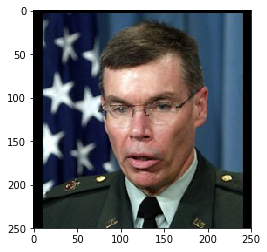

bottleneck_feature (1, 7, 7, 2048)
predicted_vector (1, 133)
This dog look like a Affenpinscher


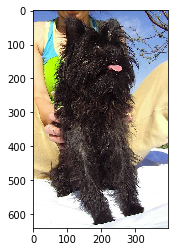

bottleneck_feature (1, 7, 7, 2048)
predicted_vector (1, 133)
This human look like a American_water_spaniel


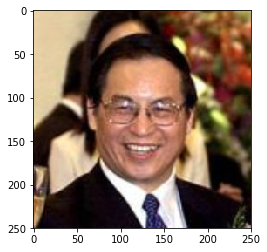

bottleneck_feature (1, 7, 7, 2048)
predicted_vector (1, 133)
This dog look like a Black_russian_terrier


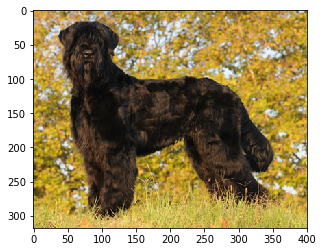

bottleneck_feature (1, 7, 7, 2048)
predicted_vector (1, 133)
This human look like a American_water_spaniel


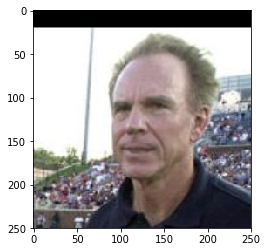

bottleneck_feature (1, 7, 7, 2048)
predicted_vector (1, 133)
This dog look like a Brittany


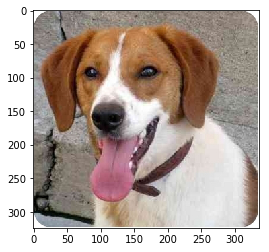

In [34]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

for i in range(3):
    index = int(np.random.choice(len(human_files_short), 1, replace=True))
    human_dog_or_none(human_files_short[index])
    human_dog_or_none(dog_files_short[index])